In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 172014
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 171110


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,11,47,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408
5,5,322430009004,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,53,46,2,7.0,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,-0.876000,2012,0.048068


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [12]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

[Local] Box Scores are not available, generating them from scratch...
[1/6644] Getting game information for ESPN game_id: 322432006...
[1/6644] Started processing game information for ESPN game_id: 322432006...
[1/6644] Completed processing game information for ESPN game_id: 322432006.
[1/6644] Aggreggated game_id 322432006 to master data copy.
[2/6644] Getting game information for ESPN game_id: 322430238...
[2/6644] Started processing game information for ESPN game_id: 322430238...
[2/6644] Completed processing game information for ESPN game_id: 322430238.
[2/6644] Aggreggated game_id 322430238 to master data copy.
[3/6644] Getting game information for ESPN game_id: 322432050...
[3/6644] Started processing game information for ESPN game_id: 322432050...
[3/6644] Completed processing game information for ESPN game_id: 322432050.
[3/6644] Aggreggated game_id 322432050 to master data copy.
[4/6644] Getting game information for ESPN game_id: 322432117...
[4/6644] Started processing game i

[36/6644] Completed processing game information for ESPN game_id: 322450057.
[36/6644] Aggreggated game_id 322450057 to master data copy.
[37/6644] Getting game information for ESPN game_id: 322450275...
[37/6644] Started processing game information for ESPN game_id: 322450275...
[37/6644] Skipping checking game_id 322450275 bc one of the teams isn't FBS.
[38/6644] Getting game information for ESPN game_id: 322450158...
[38/6644] Started processing game information for ESPN game_id: 322450158...
[38/6644] Completed processing game information for ESPN game_id: 322450158.
[38/6644] Aggreggated game_id 322450158 to master data copy.
[39/6644] Getting game information for ESPN game_id: 322450103...
[39/6644] Started processing game information for ESPN game_id: 322450103...
[39/6644] Completed processing game information for ESPN game_id: 322450103.
[39/6644] Aggreggated game_id 322450103 to master data copy.
[40/6644] Getting game information for ESPN game_id: 322452459...
[40/6644] Star

[71/6644] Completed processing game information for ESPN game_id: 322452483.
[71/6644] Aggreggated game_id 322452483 to master data copy.
[72/6644] Getting game information for ESPN game_id: 322450264...
[72/6644] Started processing game information for ESPN game_id: 322450264...
[72/6644] Completed processing game information for ESPN game_id: 322450264.
[72/6644] Aggreggated game_id 322450264 to master data copy.
[73/6644] Getting game information for ESPN game_id: 322450012...
[73/6644] Started processing game information for ESPN game_id: 322450012...
[73/6644] Completed processing game information for ESPN game_id: 322450012.
[73/6644] Aggreggated game_id 322450012 to master data copy.
[74/6644] Getting game information for ESPN game_id: 322460097...
[74/6644] Started processing game information for ESPN game_id: 322460097...
[74/6644] Completed processing game information for ESPN game_id: 322460097.
[74/6644] Aggreggated game_id 322460097 to master data copy.
[75/6644] Getting g

[104/6644] Completed processing game information for ESPN game_id: 322522117.
[104/6644] Aggreggated game_id 322522117 to master data copy.
[105/6644] Getting game information for ESPN game_id: 322520183...
[105/6644] Started processing game information for ESPN game_id: 322520183...
[105/6644] Completed processing game information for ESPN game_id: 322520183.
[105/6644] Aggreggated game_id 322520183 to master data copy.
[106/6644] Getting game information for ESPN game_id: 322520130...
[106/6644] Started processing game information for ESPN game_id: 322520130...
[106/6644] Completed processing game information for ESPN game_id: 322520130.
[106/6644] Aggreggated game_id 322520130 to master data copy.
[107/6644] Getting game information for ESPN game_id: 322520164...
[107/6644] Started processing game information for ESPN game_id: 322520164...
[107/6644] Skipping checking game_id 322520164 bc one of the teams isn't FBS.
[108/6644] Getting game information for ESPN game_id: 322522294...


[137/6644] Completed processing game information for ESPN game_id: 322520021.
[137/6644] Aggreggated game_id 322520021 to master data copy.
[138/6644] Getting game information for ESPN game_id: 322520142...
[138/6644] Started processing game information for ESPN game_id: 322520142...
[138/6644] Completed processing game information for ESPN game_id: 322520142.
[138/6644] Aggreggated game_id 322520142 to master data copy.
[139/6644] Getting game information for ESPN game_id: 322520026...
[139/6644] Started processing game information for ESPN game_id: 322520026...
[139/6644] Completed processing game information for ESPN game_id: 322520026.
[139/6644] Aggreggated game_id 322520026 to master data copy.
[140/6644] Getting game information for ESPN game_id: 322520248...
[140/6644] Started processing game information for ESPN game_id: 322520248...
[140/6644] Completed processing game information for ESPN game_id: 322520248.
[140/6644] Aggreggated game_id 322520248 to master data copy.
[141/

[169/6644] Completed processing game information for ESPN game_id: 322590213.
[169/6644] Aggreggated game_id 322590213 to master data copy.
[170/6644] Getting game information for ESPN game_id: 322592006...
[170/6644] Started processing game information for ESPN game_id: 322592006...
[170/6644] Skipping checking game_id 322592006 bc one of the teams isn't FBS.
[171/6644] Getting game information for ESPN game_id: 322590097...
[171/6644] Started processing game information for ESPN game_id: 322590097...
[171/6644] Completed processing game information for ESPN game_id: 322590097.
[171/6644] Aggreggated game_id 322590097 to master data copy.
[172/6644] Getting game information for ESPN game_id: 322592572...
[172/6644] Started processing game information for ESPN game_id: 322592572...
Could not find drive data for game_id 322592572 locally, checking CFB Data API
Could not find drive data for game_id 322592572 on CFB Data API, bailing out
[172/6644] Got 'None' for game_id 322592572's box s

[202/6644] Completed processing game information for ESPN game_id: 322590024.
[202/6644] Aggreggated game_id 322590024 to master data copy.
[203/6644] Getting game information for ESPN game_id: 322590127...
[203/6644] Started processing game information for ESPN game_id: 322590127...
[203/6644] Completed processing game information for ESPN game_id: 322590127.
[203/6644] Aggreggated game_id 322590127 to master data copy.
[204/6644] Getting game information for ESPN game_id: 322590099...
[204/6644] Started processing game information for ESPN game_id: 322590099...
[204/6644] Skipping checking game_id 322590099 bc one of the teams isn't FBS.
[205/6644] Getting game information for ESPN game_id: 322590023...
[205/6644] Started processing game information for ESPN game_id: 322590023...
[205/6644] Completed processing game information for ESPN game_id: 322590023.
[205/6644] Aggreggated game_id 322590023 to master data copy.
[206/6644] Getting game information for ESPN game_id: 322590021...


[232/6644] Completed processing game information for ESPN game_id: 322662711.
[232/6644] Aggreggated game_id 322662711 to master data copy.
[233/6644] Getting game information for ESPN game_id: 322660059...
[233/6644] Started processing game information for ESPN game_id: 322660059...
[233/6644] Completed processing game information for ESPN game_id: 322660059.
[233/6644] Aggreggated game_id 322660059 to master data copy.
[234/6644] Getting game information for ESPN game_id: 322660213...
[234/6644] Started processing game information for ESPN game_id: 322660213...
[234/6644] Completed processing game information for ESPN game_id: 322660213.
[234/6644] Aggreggated game_id 322660213 to master data copy.
[235/6644] Getting game information for ESPN game_id: 322660221...
[235/6644] Started processing game information for ESPN game_id: 322660221...
[235/6644] Skipping checking game_id 322660221 bc one of the teams isn't FBS.
[236/6644] Getting game information for ESPN game_id: 322662579...


[263/6644] Completed processing game information for ESPN game_id: 322662633.
[263/6644] Aggreggated game_id 322662633 to master data copy.
[264/6644] Getting game information for ESPN game_id: 322660087...
[264/6644] Started processing game information for ESPN game_id: 322660087...
[264/6644] Completed processing game information for ESPN game_id: 322660087.
[264/6644] Aggreggated game_id 322660087 to master data copy.
[265/6644] Getting game information for ESPN game_id: 322660061...
[265/6644] Started processing game information for ESPN game_id: 322660061...
[265/6644] Completed processing game information for ESPN game_id: 322660061.
[265/6644] Aggreggated game_id 322660061 to master data copy.
[266/6644] Getting game information for ESPN game_id: 322660201...
[266/6644] Started processing game information for ESPN game_id: 322660201...
[266/6644] Completed processing game information for ESPN game_id: 322660201.
[266/6644] Aggreggated game_id 322660201 to master data copy.
[267/

[293/6644] Completed processing game information for ESPN game_id: 322732006.
[293/6644] Aggreggated game_id 322732006 to master data copy.
[294/6644] Getting game information for ESPN game_id: 322730005...
[294/6644] Started processing game information for ESPN game_id: 322730005...
[294/6644] Completed processing game information for ESPN game_id: 322730005.
[294/6644] Aggreggated game_id 322730005 to master data copy.
[295/6644] Getting game information for ESPN game_id: 322732509...
[295/6644] Started processing game information for ESPN game_id: 322732509...
[295/6644] Completed processing game information for ESPN game_id: 322732509.
[295/6644] Aggreggated game_id 322732509 to master data copy.
[296/6644] Getting game information for ESPN game_id: 322732426...
[296/6644] Started processing game information for ESPN game_id: 322732426...
[296/6644] Completed processing game information for ESPN game_id: 322732426.
[296/6644] Aggreggated game_id 322732426 to master data copy.
[297/

[323/6644] Completed processing game information for ESPN game_id: 322730328.
[323/6644] Aggreggated game_id 322730328 to master data copy.
[324/6644] Getting game information for ESPN game_id: 322732572...
[324/6644] Started processing game information for ESPN game_id: 322732572...
[324/6644] Completed processing game information for ESPN game_id: 322732572.
[324/6644] Aggreggated game_id 322732572 to master data copy.
[325/6644] Getting game information for ESPN game_id: 322730166...
[325/6644] Started processing game information for ESPN game_id: 322730166...
[325/6644] Completed processing game information for ESPN game_id: 322730166.
[325/6644] Aggreggated game_id 322730166 to master data copy.
[326/6644] Getting game information for ESPN game_id: 322730158...
[326/6644] Started processing game information for ESPN game_id: 322730158...
[326/6644] Completed processing game information for ESPN game_id: 322730158.
[326/6644] Aggreggated game_id 322730158 to master data copy.
[327/

[352/6644] Completed processing game information for ESPN game_id: 322800150.
[352/6644] Aggreggated game_id 322800150 to master data copy.
[353/6644] Getting game information for ESPN game_id: 322802050...
[353/6644] Started processing game information for ESPN game_id: 322802050...
[353/6644] Completed processing game information for ESPN game_id: 322802050.
[353/6644] Aggreggated game_id 322802050 to master data copy.
[354/6644] Getting game information for ESPN game_id: 322802649...
[354/6644] Started processing game information for ESPN game_id: 322802649...
[354/6644] Completed processing game information for ESPN game_id: 322802649.
[354/6644] Aggreggated game_id 322802649 to master data copy.
[355/6644] Getting game information for ESPN game_id: 322800024...
[355/6644] Started processing game information for ESPN game_id: 322800024...
[355/6644] Completed processing game information for ESPN game_id: 322800024.
[355/6644] Aggreggated game_id 322800024 to master data copy.
[356/

[382/6644] Completed processing game information for ESPN game_id: 322802638.
[382/6644] Aggreggated game_id 322802638 to master data copy.
[383/6644] Getting game information for ESPN game_id: 322800021...
[383/6644] Started processing game information for ESPN game_id: 322800021...
[383/6644] Completed processing game information for ESPN game_id: 322800021.
[383/6644] Aggreggated game_id 322800021 to master data copy.
[384/6644] Getting game information for ESPN game_id: 322800025...
[384/6644] Started processing game information for ESPN game_id: 322800025...
[384/6644] Completed processing game information for ESPN game_id: 322800025.
[384/6644] Aggreggated game_id 322800025 to master data copy.
[385/6644] Getting game information for ESPN game_id: 322802483...
[385/6644] Started processing game information for ESPN game_id: 322802483...
[385/6644] Completed processing game information for ESPN game_id: 322802483.
[385/6644] Aggreggated game_id 322802483 to master data copy.
[386/

[412/6644] Completed processing game information for ESPN game_id: 322870130.
[412/6644] Aggreggated game_id 322870130 to master data copy.
[413/6644] Getting game information for ESPN game_id: 322872305...
[413/6644] Started processing game information for ESPN game_id: 322872305...
[413/6644] Completed processing game information for ESPN game_id: 322872305.
[413/6644] Aggreggated game_id 322872305 to master data copy.
[414/6644] Getting game information for ESPN game_id: 322870252...
[414/6644] Started processing game information for ESPN game_id: 322870252...
[414/6644] Completed processing game information for ESPN game_id: 322870252.
[414/6644] Aggreggated game_id 322870252 to master data copy.
[415/6644] Getting game information for ESPN game_id: 322872459...
[415/6644] Started processing game information for ESPN game_id: 322872459...
[415/6644] Completed processing game information for ESPN game_id: 322872459.
[415/6644] Aggreggated game_id 322872459 to master data copy.
[416/

[442/6644] Aggreggated game_id 322922567 to master data copy.
[443/6644] Getting game information for ESPN game_id: 322920009...
[443/6644] Started processing game information for ESPN game_id: 322920009...
[443/6644] Completed processing game information for ESPN game_id: 322920009.
[443/6644] Aggreggated game_id 322920009 to master data copy.
[444/6644] Getting game information for ESPN game_id: 322930183...
[444/6644] Started processing game information for ESPN game_id: 322930183...
[444/6644] Completed processing game information for ESPN game_id: 322930183.
[444/6644] Aggreggated game_id 322930183 to master data copy.
[445/6644] Getting game information for ESPN game_id: 322942006...
[445/6644] Started processing game information for ESPN game_id: 322942006...
[445/6644] Completed processing game information for ESPN game_id: 322942006.
[445/6644] Aggreggated game_id 322942006 to master data copy.
[446/6644] Getting game information for ESPN game_id: 322940245...
[446/6644] Start

[473/6644] Completed processing game information for ESPN game_id: 322940006.
[473/6644] Aggreggated game_id 322940006 to master data copy.
[474/6644] Getting game information for ESPN game_id: 322940077...
[474/6644] Started processing game information for ESPN game_id: 322940077...
[474/6644] Completed processing game information for ESPN game_id: 322940077.
[474/6644] Aggreggated game_id 322940077 to master data copy.
[475/6644] Getting game information for ESPN game_id: 322940098...
[475/6644] Started processing game information for ESPN game_id: 322940098...
[475/6644] Completed processing game information for ESPN game_id: 322940098.
[475/6644] Aggreggated game_id 322940098 to master data copy.
[476/6644] Getting game information for ESPN game_id: 322940030...
[476/6644] Started processing game information for ESPN game_id: 322940030...
[476/6644] Completed processing game information for ESPN game_id: 322940030.
[476/6644] Aggreggated game_id 322940030 to master data copy.
[477/

[503/6644] Completed processing game information for ESPN game_id: 323010356.
[503/6644] Aggreggated game_id 323010356 to master data copy.
[504/6644] Getting game information for ESPN game_id: 323012711...
[504/6644] Started processing game information for ESPN game_id: 323012711...
[504/6644] Completed processing game information for ESPN game_id: 323012711.
[504/6644] Aggreggated game_id 323012711 to master data copy.
[505/6644] Getting game information for ESPN game_id: 323012579...
[505/6644] Started processing game information for ESPN game_id: 323012579...
[505/6644] Completed processing game information for ESPN game_id: 323012579.
[505/6644] Aggreggated game_id 323012579 to master data copy.
[506/6644] Getting game information for ESPN game_id: 323012305...
[506/6644] Started processing game information for ESPN game_id: 323012305...
[506/6644] Completed processing game information for ESPN game_id: 323012305.
[506/6644] Aggreggated game_id 323012305 to master data copy.
[507/

[533/6644] Completed processing game information for ESPN game_id: 323012084.
[533/6644] Aggreggated game_id 323012084 to master data copy.
[534/6644] Getting game information for ESPN game_id: 323012117...
[534/6644] Started processing game information for ESPN game_id: 323012117...
[534/6644] Completed processing game information for ESPN game_id: 323012117.
[534/6644] Aggreggated game_id 323012117 to master data copy.
[535/6644] Getting game information for ESPN game_id: 323010023...
[535/6644] Started processing game information for ESPN game_id: 323010023...
[535/6644] Completed processing game information for ESPN game_id: 323010023.
[535/6644] Aggreggated game_id 323010023 to master data copy.
[536/6644] Getting game information for ESPN game_id: 323010248...
[536/6644] Started processing game information for ESPN game_id: 323010248...
[536/6644] Completed processing game information for ESPN game_id: 323010248.
[536/6644] Aggreggated game_id 323010248 to master data copy.
[537/

[563/6644] Completed processing game information for ESPN game_id: 323080344.
[563/6644] Aggreggated game_id 323080344 to master data copy.
[564/6644] Getting game information for ESPN game_id: 323080096...
[564/6644] Started processing game information for ESPN game_id: 323080096...
[564/6644] Completed processing game information for ESPN game_id: 323080096.
[564/6644] Aggreggated game_id 323080096 to master data copy.
[565/6644] Getting game information for ESPN game_id: 323080151...
[565/6644] Started processing game information for ESPN game_id: 323080151...
[565/6644] Completed processing game information for ESPN game_id: 323080151.
[565/6644] Aggreggated game_id 323080151 to master data copy.
[566/6644] Getting game information for ESPN game_id: 323080135...
[566/6644] Started processing game information for ESPN game_id: 323080135...
[566/6644] Completed processing game information for ESPN game_id: 323080135.
[566/6644] Aggreggated game_id 323080135 to master data copy.
[567/

[593/6644] Completed processing game information for ESPN game_id: 323080154.
[593/6644] Aggreggated game_id 323080154 to master data copy.
[594/6644] Getting game information for ESPN game_id: 323082433...
[594/6644] Started processing game information for ESPN game_id: 323082433...
[594/6644] Completed processing game information for ESPN game_id: 323082433.
[594/6644] Aggreggated game_id 323082433 to master data copy.
[595/6644] Getting game information for ESPN game_id: 323082439...
[595/6644] Started processing game information for ESPN game_id: 323082439...
[595/6644] Completed processing game information for ESPN game_id: 323082439.
[595/6644] Aggreggated game_id 323082439 to master data copy.
[596/6644] Getting game information for ESPN game_id: 323082348...
[596/6644] Started processing game information for ESPN game_id: 323082348...
[596/6644] Completed processing game information for ESPN game_id: 323082348.
[596/6644] Aggreggated game_id 323082348 to master data copy.
[597/

[623/6644] Completed processing game information for ESPN game_id: 323150183.
[623/6644] Aggreggated game_id 323150183 to master data copy.
[624/6644] Getting game information for ESPN game_id: 323150164...
[624/6644] Started processing game information for ESPN game_id: 323150164...
[624/6644] Completed processing game information for ESPN game_id: 323150164.
[624/6644] Aggreggated game_id 323150164 to master data copy.
[625/6644] Getting game information for ESPN game_id: 323152294...
[625/6644] Started processing game information for ESPN game_id: 323152294...
[625/6644] Completed processing game information for ESPN game_id: 323152294.
[625/6644] Aggreggated game_id 323152294 to master data copy.
[626/6644] Getting game information for ESPN game_id: 323150057...
[626/6644] Started processing game information for ESPN game_id: 323150057...
[626/6644] Completed processing game information for ESPN game_id: 323150057.
[626/6644] Aggreggated game_id 323150057 to master data copy.
[627/

[652/6644] Completed processing game information for ESPN game_id: 323152638.
[652/6644] Aggreggated game_id 323152638 to master data copy.
[653/6644] Getting game information for ESPN game_id: 323152567...
[653/6644] Started processing game information for ESPN game_id: 323152567...
[653/6644] Completed processing game information for ESPN game_id: 323152567.
[653/6644] Aggreggated game_id 323152567 to master data copy.
[654/6644] Getting game information for ESPN game_id: 323150235...
[654/6644] Started processing game information for ESPN game_id: 323150235...
[654/6644] Completed processing game information for ESPN game_id: 323150235.
[654/6644] Aggreggated game_id 323150235 to master data copy.
[655/6644] Getting game information for ESPN game_id: 323150145...
[655/6644] Started processing game information for ESPN game_id: 323150145...
[655/6644] Completed processing game information for ESPN game_id: 323150145.
[655/6644] Aggreggated game_id 323150145 to master data copy.
[656/

Could not find drive data for game_id 400368353 locally, checking CFB Data API
Could not find play by play data for game_id 400368353 locally, checking CFB Data API
[682/6644] Completed processing game information for ESPN game_id: 400368353.
[682/6644] Aggreggated game_id 400368353 to master data copy.
[683/6644] Getting game information for ESPN game_id: 323220344...
[683/6644] Started processing game information for ESPN game_id: 323220344...
[683/6644] Completed processing game information for ESPN game_id: 323220344.
[683/6644] Aggreggated game_id 323220344 to master data copy.
[684/6644] Getting game information for ESPN game_id: 323220333...
[684/6644] Started processing game information for ESPN game_id: 323220333...
[684/6644] Skipping checking game_id 323220333 bc one of the teams isn't FBS.
[685/6644] Getting game information for ESPN game_id: 323220103...
[685/6644] Started processing game information for ESPN game_id: 323220103...
[685/6644] Completed processing game infor

[712/6644] Completed processing game information for ESPN game_id: 323220059.
[712/6644] Aggreggated game_id 323220059 to master data copy.
[713/6644] Getting game information for ESPN game_id: 323220006...
[713/6644] Started processing game information for ESPN game_id: 323220006...
[713/6644] Completed processing game information for ESPN game_id: 323220006.
[713/6644] Aggreggated game_id 323220006 to master data copy.
[714/6644] Getting game information for ESPN game_id: 323222439...
[714/6644] Started processing game information for ESPN game_id: 323222439...
[714/6644] Completed processing game information for ESPN game_id: 323222439.
[714/6644] Aggreggated game_id 323222439 to master data copy.
[715/6644] Getting game information for ESPN game_id: 323222433...
[715/6644] Started processing game information for ESPN game_id: 323222433...
[715/6644] Completed processing game information for ESPN game_id: 323222433.
[715/6644] Aggreggated game_id 323222433 to master data copy.
[716/

[743/6644] Completed processing game information for ESPN game_id: 323280066.
[743/6644] Aggreggated game_id 323280066 to master data copy.
[744/6644] Getting game information for ESPN game_id: 323282132...
[744/6644] Started processing game information for ESPN game_id: 323282132...
[744/6644] Completed processing game information for ESPN game_id: 323282132.
[744/6644] Aggreggated game_id 323282132 to master data copy.
[745/6644] Getting game information for ESPN game_id: 323280012...
[745/6644] Started processing game information for ESPN game_id: 323280012...
[745/6644] Completed processing game information for ESPN game_id: 323280012.
[745/6644] Aggreggated game_id 323280012 to master data copy.
[746/6644] Getting game information for ESPN game_id: 323292567...
[746/6644] Started processing game information for ESPN game_id: 323292567...
[746/6644] Completed processing game information for ESPN game_id: 323292567.
[746/6644] Aggreggated game_id 323292567 to master data copy.
[747/

[773/6644] Completed processing game information for ESPN game_id: 323290248.
[773/6644] Aggreggated game_id 323290248 to master data copy.
[774/6644] Getting game information for ESPN game_id: 323292393...
[774/6644] Started processing game information for ESPN game_id: 323292393...
[774/6644] Completed processing game information for ESPN game_id: 323292393.
[774/6644] Aggreggated game_id 323292393 to master data copy.
[775/6644] Getting game information for ESPN game_id: 323290235...
[775/6644] Started processing game information for ESPN game_id: 323290235...
[775/6644] Completed processing game information for ESPN game_id: 323290235.
[775/6644] Aggreggated game_id 323290235 to master data copy.
[776/6644] Getting game information for ESPN game_id: 323290309...
[776/6644] Started processing game information for ESPN game_id: 323290309...
[776/6644] Completed processing game information for ESPN game_id: 323290309.
[776/6644] Aggreggated game_id 323290309 to master data copy.
[777/

[803/6644] Completed processing game information for ESPN game_id: 323360059.
[803/6644] Aggreggated game_id 323360059 to master data copy.
[804/6644] Getting game information for ESPN game_id: 323360275...
[804/6644] Started processing game information for ESPN game_id: 323360275...
[804/6644] Completed processing game information for ESPN game_id: 323360275.
[804/6644] Aggreggated game_id 323360275 to master data copy.
[805/6644] Getting game information for ESPN game_id: 323360062...
[805/6644] Started processing game information for ESPN game_id: 323360062...
[805/6644] Completed processing game information for ESPN game_id: 323360062.
[805/6644] Aggreggated game_id 323360062 to master data copy.
[806/6644] Getting game information for ESPN game_id: 323430349...
[806/6644] Started processing game information for ESPN game_id: 323430349...
[806/6644] Completed processing game information for ESPN game_id: 323430349.
[806/6644] Aggreggated game_id 323430349 to master data copy.
[807/

[839/6644] Completed processing game information for ESPN game_id: 332430057.
[839/6644] Aggreggated game_id 332430057 to master data copy.
[840/6644] Getting game information for ESPN game_id: 332430120...
[840/6644] Started processing game information for ESPN game_id: 332430120...
[840/6644] Completed processing game information for ESPN game_id: 332430120.
[840/6644] Aggreggated game_id 332430120 to master data copy.
[841/6644] Getting game information for ESPN game_id: 332430152...
[841/6644] Started processing game information for ESPN game_id: 332430152...
[841/6644] Completed processing game information for ESPN game_id: 332430152.
[841/6644] Aggreggated game_id 332430152 to master data copy.
[842/6644] Getting game information for ESPN game_id: 332430245...
[842/6644] Started processing game information for ESPN game_id: 332430245...
[842/6644] Completed processing game information for ESPN game_id: 332430245.
[842/6644] Aggreggated game_id 332430245 to master data copy.
[843/

[871/6644] Completed processing game information for ESPN game_id: 332430167.
[871/6644] Aggreggated game_id 332430167 to master data copy.
[872/6644] Getting game information for ESPN game_id: 332430228...
[872/6644] Started processing game information for ESPN game_id: 332430228...
[872/6644] Completed processing game information for ESPN game_id: 332430228.
[872/6644] Aggreggated game_id 332430228 to master data copy.
[873/6644] Getting game information for ESPN game_id: 332430158...
[873/6644] Started processing game information for ESPN game_id: 332430158...
[873/6644] Completed processing game information for ESPN game_id: 332430158.
[873/6644] Aggreggated game_id 332430158 to master data copy.
[874/6644] Getting game information for ESPN game_id: 332430066...
[874/6644] Started processing game information for ESPN game_id: 332430066...
[874/6644] Skipping checking game_id 332430066 bc one of the teams isn't FBS.
[875/6644] Getting game information for ESPN game_id: 332432628...


[910/6644] Completed processing game information for ESPN game_id: 332502005.
[910/6644] Aggreggated game_id 332502005 to master data copy.
[911/6644] Getting game information for ESPN game_id: 332500344...
[911/6644] Started processing game information for ESPN game_id: 332500344...
[911/6644] Skipping checking game_id 332500344 bc one of the teams isn't FBS.
[912/6644] Getting game information for ESPN game_id: 332500194...
[912/6644] Started processing game information for ESPN game_id: 332500194...
[912/6644] Completed processing game information for ESPN game_id: 332500194.
[912/6644] Aggreggated game_id 332500194 to master data copy.
[913/6644] Getting game information for ESPN game_id: 332500239...
[913/6644] Started processing game information for ESPN game_id: 332500239...
[913/6644] Completed processing game information for ESPN game_id: 332500239.
[913/6644] Aggreggated game_id 332500239 to master data copy.
[914/6644] Getting game information for ESPN game_id: 332502655...


[945/6644] Completed processing game information for ESPN game_id: 332500099.
[945/6644] Aggreggated game_id 332500099 to master data copy.
[946/6644] Getting game information for ESPN game_id: 332500166...
[946/6644] Started processing game information for ESPN game_id: 332500166...
[946/6644] Completed processing game information for ESPN game_id: 332500166.
[946/6644] Aggreggated game_id 332500166 to master data copy.
[947/6644] Getting game information for ESPN game_id: 332502638...
[947/6644] Started processing game information for ESPN game_id: 332502638...
[947/6644] Completed processing game information for ESPN game_id: 332502638.
[947/6644] Aggreggated game_id 332502638 to master data copy.
[948/6644] Getting game information for ESPN game_id: 332502567...
[948/6644] Started processing game information for ESPN game_id: 332502567...
[948/6644] Skipping checking game_id 332502567 bc one of the teams isn't FBS.
[949/6644] Getting game information for ESPN game_id: 332500130...


[976/6644] Completed processing game information for ESPN game_id: 332570030.
[976/6644] Aggreggated game_id 332570030 to master data copy.
[977/6644] Getting game information for ESPN game_id: 332572084...
[977/6644] Started processing game information for ESPN game_id: 332572084...
[977/6644] Skipping checking game_id 332572084 bc one of the teams isn't FBS.
[978/6644] Getting game information for ESPN game_id: 332570245...
[978/6644] Started processing game information for ESPN game_id: 332570245...
[978/6644] Completed processing game information for ESPN game_id: 332570245.
[978/6644] Aggreggated game_id 332570245 to master data copy.
[979/6644] Getting game information for ESPN game_id: 332570036...
[979/6644] Started processing game information for ESPN game_id: 332570036...
[979/6644] Skipping checking game_id 332570036 bc one of the teams isn't FBS.
[980/6644] Getting game information for ESPN game_id: 332572483...
[980/6644] Started processing game information for ESPN game_i

[1008/6644] Completed processing game information for ESPN game_id: 332570251.
[1008/6644] Aggreggated game_id 332570251 to master data copy.
[1009/6644] Getting game information for ESPN game_id: 332570195...
[1009/6644] Started processing game information for ESPN game_id: 332570195...
[1009/6644] Completed processing game information for ESPN game_id: 332570195.
[1009/6644] Aggreggated game_id 332570195 to master data copy.
[1010/6644] Getting game information for ESPN game_id: 332570166...
[1010/6644] Started processing game information for ESPN game_id: 332570166...
[1010/6644] Completed processing game information for ESPN game_id: 332570166.
[1010/6644] Aggreggated game_id 332570166 to master data copy.
[1011/6644] Getting game information for ESPN game_id: 332570328...
[1011/6644] Started processing game information for ESPN game_id: 332570328...
[1011/6644] Skipping checking game_id 332570328 bc one of the teams isn't FBS.
[1012/6644] Getting game information for ESPN game_id:

[1041/6644] Completed processing game information for ESPN game_id: 332640275.
[1041/6644] Aggreggated game_id 332640275 to master data copy.
[1042/6644] Getting game information for ESPN game_id: 332640120...
[1042/6644] Started processing game information for ESPN game_id: 332640120...
[1042/6644] Completed processing game information for ESPN game_id: 332640120.
[1042/6644] Aggreggated game_id 332640120 to master data copy.
[1043/6644] Getting game information for ESPN game_id: 332640189...
[1043/6644] Started processing game information for ESPN game_id: 332640189...
[1043/6644] Skipping checking game_id 332640189 bc one of the teams isn't FBS.
[1044/6644] Getting game information for ESPN game_id: 332640164...
[1044/6644] Started processing game information for ESPN game_id: 332640164...
[1044/6644] Completed processing game information for ESPN game_id: 332640164.
[1044/6644] Aggreggated game_id 332640164 to master data copy.
[1045/6644] Getting game information for ESPN game_id:

[1074/6644] Completed processing game information for ESPN game_id: 332640252.
[1074/6644] Aggreggated game_id 332640252 to master data copy.
[1075/6644] Getting game information for ESPN game_id: 332640026...
[1075/6644] Started processing game information for ESPN game_id: 332640026...
[1075/6644] Completed processing game information for ESPN game_id: 332640026.
[1075/6644] Aggreggated game_id 332640026 to master data copy.
[1076/6644] Getting game information for ESPN game_id: 332640265...
[1076/6644] Started processing game information for ESPN game_id: 332640265...
[1076/6644] Skipping checking game_id 332640265 bc one of the teams isn't FBS.
[1077/6644] Getting game information for ESPN game_id: 332690202...
[1077/6644] Started processing game information for ESPN game_id: 332690202...
[1077/6644] Completed processing game information for ESPN game_id: 332690202.
[1077/6644] Aggreggated game_id 332690202 to master data copy.
[1078/6644] Getting game information for ESPN game_id:

[1104/6644] Completed processing game information for ESPN game_id: 332712348.
[1104/6644] Aggreggated game_id 332712348 to master data copy.
[1105/6644] Getting game information for ESPN game_id: 332710070...
[1105/6644] Started processing game information for ESPN game_id: 332710070...
[1105/6644] Skipping checking game_id 332710070 bc one of the teams isn't FBS.
[1106/6644] Getting game information for ESPN game_id: 332710295...
[1106/6644] Started processing game information for ESPN game_id: 332710295...
[1106/6644] Skipping checking game_id 332710295 bc one of the teams isn't FBS.
[1107/6644] Getting game information for ESPN game_id: 332710333...
[1107/6644] Started processing game information for ESPN game_id: 332710333...
[1107/6644] Completed processing game information for ESPN game_id: 332710333.
[1107/6644] Aggreggated game_id 332710333 to master data copy.
[1108/6644] Getting game information for ESPN game_id: 332712433...
[1108/6644] Started processing game information f

[1134/6644] Completed processing game information for ESPN game_id: 332780052.
[1134/6644] Aggreggated game_id 332780052 to master data copy.
[1135/6644] Getting game information for ESPN game_id: 332782084...
[1135/6644] Started processing game information for ESPN game_id: 332782084...
[1135/6644] Completed processing game information for ESPN game_id: 332782084.
[1135/6644] Aggreggated game_id 332782084 to master data copy.
[1136/6644] Getting game information for ESPN game_id: 332780258...
[1136/6644] Started processing game information for ESPN game_id: 332780258...
[1136/6644] Completed processing game information for ESPN game_id: 332780258.
[1136/6644] Aggreggated game_id 332780258 to master data copy.
[1137/6644] Getting game information for ESPN game_id: 332780158...
[1137/6644] Started processing game information for ESPN game_id: 332780158...
[1137/6644] Completed processing game information for ESPN game_id: 332780158.
[1137/6644] Aggreggated game_id 332780158 to master da

[1165/6644] Completed processing game information for ESPN game_id: 332780038.
[1165/6644] Aggreggated game_id 332780038 to master data copy.
[1166/6644] Getting game information for ESPN game_id: 332780295...
[1166/6644] Started processing game information for ESPN game_id: 332780295...
[1166/6644] Completed processing game information for ESPN game_id: 332780295.
[1166/6644] Aggreggated game_id 332780295 to master data copy.
[1167/6644] Getting game information for ESPN game_id: 332780002...
[1167/6644] Started processing game information for ESPN game_id: 332780002...
[1167/6644] Completed processing game information for ESPN game_id: 332780002.
[1167/6644] Aggreggated game_id 332780002 to master data copy.
[1168/6644] Getting game information for ESPN game_id: 332780344...
[1168/6644] Started processing game information for ESPN game_id: 332780344...
[1168/6644] Completed processing game information for ESPN game_id: 332780344.
[1168/6644] Aggreggated game_id 332780344 to master da

[1195/6644] Completed processing game information for ESPN game_id: 332850248.
[1195/6644] Aggreggated game_id 332850248 to master data copy.
[1196/6644] Getting game information for ESPN game_id: 332850008...
[1196/6644] Started processing game information for ESPN game_id: 332850008...
[1196/6644] Completed processing game information for ESPN game_id: 332850008.
[1196/6644] Aggreggated game_id 332850008 to master data copy.
[1197/6644] Getting game information for ESPN game_id: 332850150...
[1197/6644] Started processing game information for ESPN game_id: 332850150...
[1197/6644] Completed processing game information for ESPN game_id: 332850150.
[1197/6644] Aggreggated game_id 332850150 to master data copy.
[1198/6644] Getting game information for ESPN game_id: 332850195...
[1198/6644] Started processing game information for ESPN game_id: 332850195...
[1198/6644] Completed processing game information for ESPN game_id: 332850195.
[1198/6644] Aggreggated game_id 332850195 to master da

[1224/6644] Completed processing game information for ESPN game_id: 332852229.
[1224/6644] Aggreggated game_id 332852229 to master data copy.
[1225/6644] Getting game information for ESPN game_id: 332850344...
[1225/6644] Started processing game information for ESPN game_id: 332850344...
[1225/6644] Completed processing game information for ESPN game_id: 332850344.
[1225/6644] Aggreggated game_id 332850344 to master data copy.
[1226/6644] Getting game information for ESPN game_id: 332850328...
[1226/6644] Started processing game information for ESPN game_id: 332850328...
[1226/6644] Completed processing game information for ESPN game_id: 332850328.
[1226/6644] Aggreggated game_id 332850328 to master data copy.
[1227/6644] Getting game information for ESPN game_id: 332852439...
[1227/6644] Started processing game information for ESPN game_id: 332852439...
[1227/6644] Completed processing game information for ESPN game_id: 332852439.
[1227/6644] Aggreggated game_id 332852439 to master da

[1254/6644] Completed processing game information for ESPN game_id: 332922117.
[1254/6644] Aggreggated game_id 332922117 to master data copy.
[1255/6644] Getting game information for ESPN game_id: 332920006...
[1255/6644] Started processing game information for ESPN game_id: 332920006...
[1255/6644] Completed processing game information for ESPN game_id: 332920006.
[1255/6644] Aggreggated game_id 332920006 to master data copy.
[1256/6644] Getting game information for ESPN game_id: 332920248...
[1256/6644] Started processing game information for ESPN game_id: 332920248...
[1256/6644] Completed processing game information for ESPN game_id: 332920248.
[1256/6644] Aggreggated game_id 332920248 to master data copy.
[1257/6644] Getting game information for ESPN game_id: 332922305...
[1257/6644] Started processing game information for ESPN game_id: 332922305...
[1257/6644] Completed processing game information for ESPN game_id: 332922305.
[1257/6644] Aggreggated game_id 332922305 to master da

[1284/6644] Completed processing game information for ESPN game_id: 332970344.
[1284/6644] Aggreggated game_id 332970344 to master data copy.
[1285/6644] Getting game information for ESPN game_id: 332980252...
[1285/6644] Started processing game information for ESPN game_id: 332980252...
[1285/6644] Completed processing game information for ESPN game_id: 332980252.
[1285/6644] Aggreggated game_id 332980252 to master data copy.
[1286/6644] Getting game information for ESPN game_id: 332990135...
[1286/6644] Started processing game information for ESPN game_id: 332990135...
[1286/6644] Completed processing game information for ESPN game_id: 332990135.
[1286/6644] Aggreggated game_id 332990135 to master data copy.
[1287/6644] Getting game information for ESPN game_id: 332992390...
[1287/6644] Started processing game information for ESPN game_id: 332992390...
[1287/6644] Completed processing game information for ESPN game_id: 332992390.
[1287/6644] Aggreggated game_id 332992390 to master da

[1313/6644] Completed processing game information for ESPN game_id: 332990098.
[1313/6644] Aggreggated game_id 332990098 to master data copy.
[1314/6644] Getting game information for ESPN game_id: 332990030...
[1314/6644] Started processing game information for ESPN game_id: 332990030...
[1314/6644] Completed processing game information for ESPN game_id: 332990030.
[1314/6644] Aggreggated game_id 332990030 to master data copy.
[1315/6644] Getting game information for ESPN game_id: 332990201...
[1315/6644] Started processing game information for ESPN game_id: 332990201...
[1315/6644] Completed processing game information for ESPN game_id: 332990201.
[1315/6644] Aggreggated game_id 332990201 to master data copy.
[1316/6644] Getting game information for ESPN game_id: 332992636...
[1316/6644] Started processing game information for ESPN game_id: 332992636...
[1316/6644] Completed processing game information for ESPN game_id: 332992636.
[1316/6644] Aggreggated game_id 332992636 to master da

[1344/6644] Completed processing game information for ESPN game_id: 333062294.
[1344/6644] Aggreggated game_id 333062294 to master data copy.
[1345/6644] Getting game information for ESPN game_id: 333062005...
[1345/6644] Started processing game information for ESPN game_id: 333062005...
[1345/6644] Completed processing game information for ESPN game_id: 333062005.
[1345/6644] Aggreggated game_id 333062005 to master data copy.
[1346/6644] Getting game information for ESPN game_id: 333062509...
[1346/6644] Started processing game information for ESPN game_id: 333062509...
[1346/6644] Completed processing game information for ESPN game_id: 333062509.
[1346/6644] Aggreggated game_id 333062509 to master data copy.
[1347/6644] Getting game information for ESPN game_id: 333060276...
[1347/6644] Started processing game information for ESPN game_id: 333060276...
[1347/6644] Completed processing game information for ESPN game_id: 333060276.
[1347/6644] Aggreggated game_id 333060276 to master da

[1374/6644] Completed processing game information for ESPN game_id: 333060309.
[1374/6644] Aggreggated game_id 333060309 to master data copy.
[1375/6644] Getting game information for ESPN game_id: 333060008...
[1375/6644] Started processing game information for ESPN game_id: 333060008...
[1375/6644] Completed processing game information for ESPN game_id: 333060008.
[1375/6644] Aggreggated game_id 333060008 to master data copy.
[1376/6644] Getting game information for ESPN game_id: 333062229...
[1376/6644] Started processing game information for ESPN game_id: 333062229...
[1376/6644] Completed processing game information for ESPN game_id: 333062229.
[1376/6644] Aggreggated game_id 333062229 to master data copy.
[1377/6644] Getting game information for ESPN game_id: 333060059...
[1377/6644] Started processing game information for ESPN game_id: 333060059...
[1377/6644] Completed processing game information for ESPN game_id: 333060059.
[1377/6644] Aggreggated game_id 333060059 to master da

[1403/6644] Completed processing game information for ESPN game_id: 333130135.
[1403/6644] Aggreggated game_id 333130135 to master data copy.
[1404/6644] Getting game information for ESPN game_id: 333130276...
[1404/6644] Started processing game information for ESPN game_id: 333130276...
[1404/6644] Completed processing game information for ESPN game_id: 333130276.
[1404/6644] Aggreggated game_id 333130276 to master data copy.
[1405/6644] Getting game information for ESPN game_id: 333132132...
[1405/6644] Started processing game information for ESPN game_id: 333132132...
[1405/6644] Completed processing game information for ESPN game_id: 333132132.
[1405/6644] Aggreggated game_id 333132132 to master data copy.
[1406/6644] Getting game information for ESPN game_id: 333130349...
[1406/6644] Started processing game information for ESPN game_id: 333130349...
[1406/6644] Completed processing game information for ESPN game_id: 333130349.
[1406/6644] Aggreggated game_id 333130349 to master da

[1433/6644] Completed processing game information for ESPN game_id: 333132348.
[1433/6644] Aggreggated game_id 333132348 to master data copy.
[1434/6644] Getting game information for ESPN game_id: 333132433...
[1434/6644] Started processing game information for ESPN game_id: 333132433...
[1434/6644] Completed processing game information for ESPN game_id: 333132433.
[1434/6644] Aggreggated game_id 333132433 to master data copy.
[1435/6644] Getting game information for ESPN game_id: 333130264...
[1435/6644] Started processing game information for ESPN game_id: 333130264...
[1435/6644] Completed processing game information for ESPN game_id: 333130264.
[1435/6644] Aggreggated game_id 333130264 to master data copy.
[1436/6644] Getting game information for ESPN game_id: 333132439...
[1436/6644] Started processing game information for ESPN game_id: 333132439...
[1436/6644] Completed processing game information for ESPN game_id: 333132439.
[1436/6644] Aggreggated game_id 333132439 to master da

[1464/6644] Completed processing game information for ESPN game_id: 333200113.
[1464/6644] Aggreggated game_id 333200113 to master data copy.
[1465/6644] Getting game information for ESPN game_id: 333202247...
[1465/6644] Started processing game information for ESPN game_id: 333202247...
[1465/6644] Completed processing game information for ESPN game_id: 333202247.
[1465/6644] Aggreggated game_id 333202247 to master data copy.
[1466/6644] Getting game information for ESPN game_id: 333200012...
[1466/6644] Started processing game information for ESPN game_id: 333200012...
[1466/6644] Completed processing game information for ESPN game_id: 333200012.
[1466/6644] Aggreggated game_id 333200012 to master data copy.
[1467/6644] Getting game information for ESPN game_id: 333200151...
[1467/6644] Started processing game information for ESPN game_id: 333200151...
[1467/6644] Completed processing game information for ESPN game_id: 333200151.
[1467/6644] Aggreggated game_id 333200151 to master da

[1494/6644] Completed processing game information for ESPN game_id: 333230193.
[1494/6644] Aggreggated game_id 333230193 to master data copy.
[1495/6644] Getting game information for ESPN game_id: 333230195...
[1495/6644] Started processing game information for ESPN game_id: 333230195...
[1495/6644] Completed processing game information for ESPN game_id: 333230195.
[1495/6644] Aggreggated game_id 333230195 to master data copy.
[1496/6644] Getting game information for ESPN game_id: 333242649...
[1496/6644] Started processing game information for ESPN game_id: 333242649...
[1496/6644] Completed processing game information for ESPN game_id: 333242649.
[1496/6644] Aggreggated game_id 333242649 to master data copy.
[1497/6644] Getting game information for ESPN game_id: 333250005...
[1497/6644] Started processing game information for ESPN game_id: 333250005...
[1497/6644] Completed processing game information for ESPN game_id: 333250005.
[1497/6644] Aggreggated game_id 333250005 to master da

[1524/6644] Aggreggated game_id 333270194 to master data copy.
[1525/6644] Getting game information for ESPN game_id: 333270012...
[1525/6644] Started processing game information for ESPN game_id: 333270012...
[1525/6644] Completed processing game information for ESPN game_id: 333270012.
[1525/6644] Aggreggated game_id 333270012 to master data copy.
[1526/6644] Getting game information for ESPN game_id: 333270099...
[1526/6644] Started processing game information for ESPN game_id: 333270099...
[1526/6644] Completed processing game information for ESPN game_id: 333270099.
[1526/6644] Aggreggated game_id 333270099 to master data copy.
[1527/6644] Getting game information for ESPN game_id: 333270135...
[1527/6644] Started processing game information for ESPN game_id: 333270135...
[1527/6644] Completed processing game information for ESPN game_id: 333270135.
[1527/6644] Aggreggated game_id 333270135 to master data copy.
[1528/6644] Getting game information for ESPN game_id: 333272655...
[1

[1553/6644] Completed processing game information for ESPN game_id: 333302459.
[1553/6644] Aggreggated game_id 333302459 to master data copy.
[1554/6644] Getting game information for ESPN game_id: 333320344...
[1554/6644] Started processing game information for ESPN game_id: 333320344...
[1554/6644] Completed processing game information for ESPN game_id: 333320344.
[1554/6644] Aggreggated game_id 333320344 to master data copy.
[1555/6644] Getting game information for ESPN game_id: 333320251...
[1555/6644] Started processing game information for ESPN game_id: 333320251...
[1555/6644] Completed processing game information for ESPN game_id: 333320251.
[1555/6644] Aggreggated game_id 333320251 to master data copy.
[1556/6644] Getting game information for ESPN game_id: 333332006...
[1556/6644] Started processing game information for ESPN game_id: 333332006...
[1556/6644] Completed processing game information for ESPN game_id: 333332006.
[1556/6644] Aggreggated game_id 333332006 to master da

[1582/6644] Completed processing game information for ESPN game_id: 333340036.
[1582/6644] Aggreggated game_id 333340036 to master data copy.
[1583/6644] Getting game information for ESPN game_id: 333340254...
[1583/6644] Started processing game information for ESPN game_id: 333340254...
[1583/6644] Completed processing game information for ESPN game_id: 333340254.
[1583/6644] Aggreggated game_id 333340254 to master data copy.
[1584/6644] Getting game information for ESPN game_id: 333340328...
[1584/6644] Started processing game information for ESPN game_id: 333340328...
[1584/6644] Completed processing game information for ESPN game_id: 333340328.
[1584/6644] Aggreggated game_id 333340328 to master data copy.
[1585/6644] Getting game information for ESPN game_id: 333342247...
[1585/6644] Started processing game information for ESPN game_id: 333342247...
[1585/6644] Completed processing game information for ESPN game_id: 333342247.
[1585/6644] Aggreggated game_id 333342247 to master da

[1612/6644] Completed processing game information for ESPN game_id: 333392132.
[1612/6644] Aggreggated game_id 333392132 to master data copy.
[1613/6644] Getting game information for ESPN game_id: 333402459...
[1613/6644] Started processing game information for ESPN game_id: 333402459...
[1613/6644] Completed processing game information for ESPN game_id: 333402459.
[1613/6644] Aggreggated game_id 333402459 to master data copy.
[1614/6644] Getting game information for ESPN game_id: 333410242...
[1614/6644] Started processing game information for ESPN game_id: 333410242...
[1614/6644] Completed processing game information for ESPN game_id: 333410242.
[1614/6644] Aggreggated game_id 333410242 to master data copy.
[1615/6644] Getting game information for ESPN game_id: 333410197...
[1615/6644] Started processing game information for ESPN game_id: 333410197...
[1615/6644] Completed processing game information for ESPN game_id: 333410197.
[1615/6644] Aggreggated game_id 333410197 to master da

Could not find drive data for game_id 400547641 locally, checking CFB Data API
Could not find drive data for game_id 400547641 bc of issues with 2016 and 2014 data source, bailing out
[1642/6644] Got 'None' for game_id 400547641's box score, skipping processing.
[1643/6644] Getting game information for ESPN game_id: 400548003...
[1643/6644] Started processing game information for ESPN game_id: 400548003...
Could not find drive data for game_id 400548003 locally, checking CFB Data API
Could not find drive data for game_id 400548003 bc of issues with 2016 and 2014 data source, bailing out
[1643/6644] Got 'None' for game_id 400548003's box score, skipping processing.
[1644/6644] Getting game information for ESPN game_id: 400547952...
[1644/6644] Started processing game information for ESPN game_id: 400547952...
[1644/6644] Skipping checking game_id 400547952 bc one of the teams isn't FBS.
[1645/6644] Getting game information for ESPN game_id: 400547815...
[1645/6644] Started processing ga

Could not find drive data for game_id 400547654 locally, checking CFB Data API
Could not find drive data for game_id 400547654 bc of issues with 2016 and 2014 data source, bailing out
[1743/6644] Got 'None' for game_id 400547654's box score, skipping processing.
[1744/6644] Getting game information for ESPN game_id: 400547929...
[1744/6644] Started processing game information for ESPN game_id: 400547929...
Could not find drive data for game_id 400547929 locally, checking CFB Data API
Could not find drive data for game_id 400547929 bc of issues with 2016 and 2014 data source, bailing out
[1744/6644] Got 'None' for game_id 400547929's box score, skipping processing.
[1745/6644] Getting game information for ESPN game_id: 400547961...
[1745/6644] Started processing game information for ESPN game_id: 400547961...
Could not find drive data for game_id 400547961 locally, checking CFB Data API
Could not find drive data for game_id 400547961 bc of issues with 2016 and 2014 data source, bailing 

Could not find drive data for game_id 400548020 locally, checking CFB Data API
Could not find drive data for game_id 400548020 bc of issues with 2016 and 2014 data source, bailing out
[1826/6644] Got 'None' for game_id 400548020's box score, skipping processing.
[1827/6644] Getting game information for ESPN game_id: 400547831...
[1827/6644] Started processing game information for ESPN game_id: 400547831...
Could not find drive data for game_id 400547831 locally, checking CFB Data API
Could not find drive data for game_id 400547831 bc of issues with 2016 and 2014 data source, bailing out
[1827/6644] Got 'None' for game_id 400547831's box score, skipping processing.
[1828/6644] Getting game information for ESPN game_id: 400548388...
[1828/6644] Started processing game information for ESPN game_id: 400548388...
Could not find drive data for game_id 400548388 locally, checking CFB Data API
Could not find drive data for game_id 400548388 bc of issues with 2016 and 2014 data source, bailing 

Could not find drive data for game_id 400548269 locally, checking CFB Data API
Could not find drive data for game_id 400548269 bc of issues with 2016 and 2014 data source, bailing out
[1902/6644] Got 'None' for game_id 400548269's box score, skipping processing.
[1903/6644] Getting game information for ESPN game_id: 400548036...
[1903/6644] Started processing game information for ESPN game_id: 400548036...
Could not find drive data for game_id 400548036 locally, checking CFB Data API
Could not find drive data for game_id 400548036 bc of issues with 2016 and 2014 data source, bailing out
[1903/6644] Got 'None' for game_id 400548036's box score, skipping processing.
[1904/6644] Getting game information for ESPN game_id: 400548200...
[1904/6644] Started processing game information for ESPN game_id: 400548200...
Could not find drive data for game_id 400548200 locally, checking CFB Data API
Could not find drive data for game_id 400548200 bc of issues with 2016 and 2014 data source, bailing 

Could not find drive data for game_id 400547863 locally, checking CFB Data API
Could not find drive data for game_id 400547863 bc of issues with 2016 and 2014 data source, bailing out
[1968/6644] Got 'None' for game_id 400547863's box score, skipping processing.
[1969/6644] Getting game information for ESPN game_id: 400547797...
[1969/6644] Started processing game information for ESPN game_id: 400547797...
Could not find drive data for game_id 400547797 locally, checking CFB Data API
Could not find drive data for game_id 400547797 bc of issues with 2016 and 2014 data source, bailing out
[1969/6644] Got 'None' for game_id 400547797's box score, skipping processing.
[1970/6644] Getting game information for ESPN game_id: 400548122...
[1970/6644] Started processing game information for ESPN game_id: 400548122...
Could not find drive data for game_id 400548122 locally, checking CFB Data API
Could not find drive data for game_id 400548122 bc of issues with 2016 and 2014 data source, bailing 

Could not find drive data for game_id 400548132 locally, checking CFB Data API
Could not find drive data for game_id 400548132 bc of issues with 2016 and 2014 data source, bailing out
[2033/6644] Got 'None' for game_id 400548132's box score, skipping processing.
[2034/6644] Getting game information for ESPN game_id: 400548426...
[2034/6644] Started processing game information for ESPN game_id: 400548426...
Could not find drive data for game_id 400548426 locally, checking CFB Data API
Could not find drive data for game_id 400548426 bc of issues with 2016 and 2014 data source, bailing out
[2034/6644] Got 'None' for game_id 400548426's box score, skipping processing.
[2035/6644] Getting game information for ESPN game_id: 400548464...
[2035/6644] Started processing game information for ESPN game_id: 400548464...
[2035/6644] Skipping checking game_id 400548464 bc one of the teams isn't FBS.
[2036/6644] Getting game information for ESPN game_id: 400548047...
[2036/6644] Started processing ga

Could not find drive data for game_id 400548137 locally, checking CFB Data API
Could not find drive data for game_id 400548137 bc of issues with 2016 and 2014 data source, bailing out
[2101/6644] Got 'None' for game_id 400548137's box score, skipping processing.
[2102/6644] Getting game information for ESPN game_id: 400548050...
[2102/6644] Started processing game information for ESPN game_id: 400548050...
Could not find drive data for game_id 400548050 locally, checking CFB Data API
Could not find drive data for game_id 400548050 bc of issues with 2016 and 2014 data source, bailing out
[2102/6644] Got 'None' for game_id 400548050's box score, skipping processing.
[2103/6644] Getting game information for ESPN game_id: 400548286...
[2103/6644] Started processing game information for ESPN game_id: 400548286...
Could not find drive data for game_id 400548286 locally, checking CFB Data API
Could not find drive data for game_id 400548286 bc of issues with 2016 and 2014 data source, bailing 

Could not find drive data for game_id 400548291 locally, checking CFB Data API
Could not find drive data for game_id 400548291 bc of issues with 2016 and 2014 data source, bailing out
[2165/6644] Got 'None' for game_id 400548291's box score, skipping processing.
[2166/6644] Getting game information for ESPN game_id: 400548223...
[2166/6644] Started processing game information for ESPN game_id: 400548223...
Could not find drive data for game_id 400548223 locally, checking CFB Data API
Could not find drive data for game_id 400548223 bc of issues with 2016 and 2014 data source, bailing out
[2166/6644] Got 'None' for game_id 400548223's box score, skipping processing.
[2167/6644] Getting game information for ESPN game_id: 400547768...
[2167/6644] Started processing game information for ESPN game_id: 400547768...
Could not find drive data for game_id 400547768 locally, checking CFB Data API
Could not find drive data for game_id 400547768 bc of issues with 2016 and 2014 data source, bailing 

Could not find drive data for game_id 400547708 locally, checking CFB Data API
Could not find drive data for game_id 400547708 bc of issues with 2016 and 2014 data source, bailing out
[2230/6644] Got 'None' for game_id 400547708's box score, skipping processing.
[2231/6644] Getting game information for ESPN game_id: 400548071...
[2231/6644] Started processing game information for ESPN game_id: 400548071...
Could not find drive data for game_id 400548071 locally, checking CFB Data API
Could not find drive data for game_id 400548071 bc of issues with 2016 and 2014 data source, bailing out
[2231/6644] Got 'None' for game_id 400548071's box score, skipping processing.
[2232/6644] Getting game information for ESPN game_id: 400548069...
[2232/6644] Started processing game information for ESPN game_id: 400548069...
Could not find drive data for game_id 400548069 locally, checking CFB Data API
Could not find drive data for game_id 400548069 bc of issues with 2016 and 2014 data source, bailing 

Could not find drive data for game_id 400547711 locally, checking CFB Data API
Could not find drive data for game_id 400547711 bc of issues with 2016 and 2014 data source, bailing out
[2297/6644] Got 'None' for game_id 400547711's box score, skipping processing.
[2298/6644] Getting game information for ESPN game_id: 400547890...
[2298/6644] Started processing game information for ESPN game_id: 400547890...
Could not find drive data for game_id 400547890 locally, checking CFB Data API
Could not find drive data for game_id 400547890 bc of issues with 2016 and 2014 data source, bailing out
[2298/6644] Got 'None' for game_id 400547890's box score, skipping processing.
[2299/6644] Getting game information for ESPN game_id: 400548073...
[2299/6644] Started processing game information for ESPN game_id: 400548073...
Could not find drive data for game_id 400548073 locally, checking CFB Data API
Could not find drive data for game_id 400548073 bc of issues with 2016 and 2014 data source, bailing 

Could not find drive data for game_id 400548315 locally, checking CFB Data API
Could not find drive data for game_id 400548315 bc of issues with 2016 and 2014 data source, bailing out
[2366/6644] Got 'None' for game_id 400548315's box score, skipping processing.
[2367/6644] Getting game information for ESPN game_id: 400548313...
[2367/6644] Started processing game information for ESPN game_id: 400548313...
Could not find drive data for game_id 400548313 locally, checking CFB Data API
Could not find drive data for game_id 400548313 bc of issues with 2016 and 2014 data source, bailing out
[2367/6644] Got 'None' for game_id 400548313's box score, skipping processing.
[2368/6644] Getting game information for ESPN game_id: 400548329...
[2368/6644] Started processing game information for ESPN game_id: 400548329...
[2368/6644] Skipping checking game_id 400548329 bc one of the teams isn't FBS.
[2369/6644] Getting game information for ESPN game_id: 400548080...
[2369/6644] Started processing ga

Could not find drive data for game_id 400548322 locally, checking CFB Data API
Could not find drive data for game_id 400548322 bc of issues with 2016 and 2014 data source, bailing out
[2430/6644] Got 'None' for game_id 400548322's box score, skipping processing.
[2431/6644] Getting game information for ESPN game_id: 400548457...
[2431/6644] Started processing game information for ESPN game_id: 400548457...
Could not find drive data for game_id 400548457 locally, checking CFB Data API
Could not find drive data for game_id 400548457 bc of issues with 2016 and 2014 data source, bailing out
[2431/6644] Got 'None' for game_id 400548457's box score, skipping processing.
[2432/6644] Getting game information for ESPN game_id: 400548251...
[2432/6644] Started processing game information for ESPN game_id: 400548251...
Could not find drive data for game_id 400548251 locally, checking CFB Data API
Could not find drive data for game_id 400548251 bc of issues with 2016 and 2014 data source, bailing 

[2456/6644] Completed processing game information for ESPN game_id: 400603840.
[2456/6644] Aggreggated game_id 400603840 to master data copy.
[2457/6644] Getting game information for ESPN game_id: 400763593...
[2457/6644] Started processing game information for ESPN game_id: 400763593...
[2457/6644] Completed processing game information for ESPN game_id: 400763593.
[2457/6644] Aggreggated game_id 400763593 to master data copy.
[2458/6644] Getting game information for ESPN game_id: 400756896...
[2458/6644] Started processing game information for ESPN game_id: 400756896...
[2458/6644] Skipping checking game_id 400756896 bc one of the teams isn't FBS.
[2459/6644] Getting game information for ESPN game_id: 400787299...
[2459/6644] Started processing game information for ESPN game_id: 400787299...
[2459/6644] Skipping checking game_id 400787299 bc one of the teams isn't FBS.
[2460/6644] Getting game information for ESPN game_id: 400763399...
[2460/6644] Started processing game information f

[2494/6644] Completed processing game information for ESPN game_id: 400603828.
[2494/6644] Aggreggated game_id 400603828 to master data copy.
[2495/6644] Getting game information for ESPN game_id: 400756904...
[2495/6644] Started processing game information for ESPN game_id: 400756904...
[2495/6644] Completed processing game information for ESPN game_id: 400756904.
[2495/6644] Aggreggated game_id 400756904 to master data copy.
[2496/6644] Getting game information for ESPN game_id: 400603829...
[2496/6644] Started processing game information for ESPN game_id: 400603829...
[2496/6644] Completed processing game information for ESPN game_id: 400603829.
[2496/6644] Aggreggated game_id 400603829 to master data copy.
[2497/6644] Getting game information for ESPN game_id: 400787111...
[2497/6644] Started processing game information for ESPN game_id: 400787111...
[2497/6644] Skipping checking game_id 400787111 bc one of the teams isn't FBS.
[2498/6644] Getting game information for ESPN game_id:

[2528/6644] Completed processing game information for ESPN game_id: 400603830.
[2528/6644] Aggreggated game_id 400603830 to master data copy.
[2529/6644] Getting game information for ESPN game_id: 400756886...
[2529/6644] Started processing game information for ESPN game_id: 400756886...
[2529/6644] Skipping checking game_id 400756886 bc one of the teams isn't FBS.
[2530/6644] Getting game information for ESPN game_id: 400603827...
[2530/6644] Started processing game information for ESPN game_id: 400603827...
[2530/6644] Completed processing game information for ESPN game_id: 400603827.
[2530/6644] Aggreggated game_id 400603827 to master data copy.
[2531/6644] Getting game information for ESPN game_id: 400791346...
[2531/6644] Started processing game information for ESPN game_id: 400791346...
[2531/6644] Skipping checking game_id 400791346 bc one of the teams isn't FBS.
[2532/6644] Getting game information for ESPN game_id: 400763400...
[2532/6644] Started processing game information f

[2562/6644] Completed processing game information for ESPN game_id: 400763415.
[2562/6644] Aggreggated game_id 400763415 to master data copy.
[2563/6644] Getting game information for ESPN game_id: 400763416...
[2563/6644] Started processing game information for ESPN game_id: 400763416...
[2563/6644] Completed processing game information for ESPN game_id: 400763416.
[2563/6644] Aggreggated game_id 400763416 to master data copy.
[2564/6644] Getting game information for ESPN game_id: 400763412...
[2564/6644] Started processing game information for ESPN game_id: 400763412...
[2564/6644] Skipping checking game_id 400763412 bc one of the teams isn't FBS.
[2565/6644] Getting game information for ESPN game_id: 400756918...
[2565/6644] Started processing game information for ESPN game_id: 400756918...
[2565/6644] Skipping checking game_id 400756918 bc one of the teams isn't FBS.
[2566/6644] Getting game information for ESPN game_id: 400757021...
[2566/6644] Started processing game information f

[2593/6644] Completed processing game information for ESPN game_id: 400763597.
[2593/6644] Aggreggated game_id 400763597 to master data copy.
[2594/6644] Getting game information for ESPN game_id: 400763595...
[2594/6644] Started processing game information for ESPN game_id: 400763595...
[2594/6644] Completed processing game information for ESPN game_id: 400763595.
[2594/6644] Aggreggated game_id 400763595 to master data copy.
[2595/6644] Getting game information for ESPN game_id: 400603864...
[2595/6644] Started processing game information for ESPN game_id: 400603864...
[2595/6644] Completed processing game information for ESPN game_id: 400603864.
[2595/6644] Aggreggated game_id 400603864 to master data copy.
[2596/6644] Getting game information for ESPN game_id: 400787416...
[2596/6644] Started processing game information for ESPN game_id: 400787416...
[2596/6644] Skipping checking game_id 400787416 bc one of the teams isn't FBS.
[2597/6644] Getting game information for ESPN game_id:

[2624/6644] Completed processing game information for ESPN game_id: 400763600.
[2624/6644] Aggreggated game_id 400763600 to master data copy.
[2625/6644] Getting game information for ESPN game_id: 400763418...
[2625/6644] Started processing game information for ESPN game_id: 400763418...
[2625/6644] Completed processing game information for ESPN game_id: 400763418.
[2625/6644] Aggreggated game_id 400763418 to master data copy.
[2626/6644] Getting game information for ESPN game_id: 400603858...
[2626/6644] Started processing game information for ESPN game_id: 400603858...
[2626/6644] Completed processing game information for ESPN game_id: 400603858.
[2626/6644] Aggreggated game_id 400603858 to master data copy.
[2627/6644] Getting game information for ESPN game_id: 400603856...
[2627/6644] Started processing game information for ESPN game_id: 400603856...
[2627/6644] Completed processing game information for ESPN game_id: 400603856.
[2627/6644] Aggreggated game_id 400603856 to master da

[2658/6644] Completed processing game information for ESPN game_id: 400603852.
[2658/6644] Aggreggated game_id 400603852 to master data copy.
[2659/6644] Getting game information for ESPN game_id: 400763601...
[2659/6644] Started processing game information for ESPN game_id: 400763601...
[2659/6644] Skipping checking game_id 400763601 bc one of the teams isn't FBS.
[2660/6644] Getting game information for ESPN game_id: 400764868...
[2660/6644] Started processing game information for ESPN game_id: 400764868...
[2660/6644] Skipping checking game_id 400764868 bc one of the teams isn't FBS.
[2661/6644] Getting game information for ESPN game_id: 400757028...
[2661/6644] Started processing game information for ESPN game_id: 400757028...
[2661/6644] Completed processing game information for ESPN game_id: 400757028.
[2661/6644] Aggreggated game_id 400757028 to master data copy.
[2662/6644] Getting game information for ESPN game_id: 400763603...
[2662/6644] Started processing game information f

[2690/6644] Completed processing game information for ESPN game_id: 400763520.
[2690/6644] Aggreggated game_id 400763520 to master data copy.
[2691/6644] Getting game information for ESPN game_id: 400764871...
[2691/6644] Started processing game information for ESPN game_id: 400764871...
[2691/6644] Completed processing game information for ESPN game_id: 400764871.
[2691/6644] Aggreggated game_id 400764871 to master data copy.
[2692/6644] Getting game information for ESPN game_id: 400603845...
[2692/6644] Started processing game information for ESPN game_id: 400603845...
[2692/6644] Skipping checking game_id 400603845 bc one of the teams isn't FBS.
[2693/6644] Getting game information for ESPN game_id: 400756933...
[2693/6644] Started processing game information for ESPN game_id: 400756933...
[2693/6644] Completed processing game information for ESPN game_id: 400756933.
[2693/6644] Aggreggated game_id 400756933 to master data copy.
[2694/6644] Getting game information for ESPN game_id:

[2721/6644] Completed processing game information for ESPN game_id: 400763425.
[2721/6644] Aggreggated game_id 400763425 to master data copy.
[2722/6644] Getting game information for ESPN game_id: 400757040...
[2722/6644] Started processing game information for ESPN game_id: 400757040...
[2722/6644] Completed processing game information for ESPN game_id: 400757040.
[2722/6644] Aggreggated game_id 400757040 to master data copy.
[2723/6644] Getting game information for ESPN game_id: 400760493...
[2723/6644] Started processing game information for ESPN game_id: 400760493...
[2723/6644] Completed processing game information for ESPN game_id: 400760493.
[2723/6644] Aggreggated game_id 400760493 to master data copy.
[2724/6644] Getting game information for ESPN game_id: 400756934...
[2724/6644] Started processing game information for ESPN game_id: 400756934...
[2724/6644] Skipping checking game_id 400756934 bc one of the teams isn't FBS.
[2725/6644] Getting game information for ESPN game_id:

[2752/6644] Completed processing game information for ESPN game_id: 400763428.
[2752/6644] Aggreggated game_id 400763428 to master data copy.
[2753/6644] Getting game information for ESPN game_id: 400763532...
[2753/6644] Started processing game information for ESPN game_id: 400763532...
[2753/6644] Completed processing game information for ESPN game_id: 400763532.
[2753/6644] Aggreggated game_id 400763532 to master data copy.
[2754/6644] Getting game information for ESPN game_id: 400763533...
[2754/6644] Started processing game information for ESPN game_id: 400763533...
[2754/6644] Completed processing game information for ESPN game_id: 400763533.
[2754/6644] Aggreggated game_id 400763533 to master data copy.
[2755/6644] Getting game information for ESPN game_id: 400763530...
[2755/6644] Started processing game information for ESPN game_id: 400763530...
[2755/6644] Completed processing game information for ESPN game_id: 400763530.
[2755/6644] Aggreggated game_id 400763530 to master da

[2781/6644] Completed processing game information for ESPN game_id: 400603877.
[2781/6644] Aggreggated game_id 400603877 to master data copy.
[2782/6644] Getting game information for ESPN game_id: 400764877...
[2782/6644] Started processing game information for ESPN game_id: 400764877...
[2782/6644] Completed processing game information for ESPN game_id: 400764877.
[2782/6644] Aggreggated game_id 400764877 to master data copy.
[2783/6644] Getting game information for ESPN game_id: 400763528...
[2783/6644] Started processing game information for ESPN game_id: 400763528...
[2783/6644] Completed processing game information for ESPN game_id: 400763528.
[2783/6644] Aggreggated game_id 400763528 to master data copy.
[2784/6644] Getting game information for ESPN game_id: 400603878...
[2784/6644] Started processing game information for ESPN game_id: 400603878...
[2784/6644] Completed processing game information for ESPN game_id: 400603878.
[2784/6644] Aggreggated game_id 400603878 to master da

[2810/6644] Completed processing game information for ESPN game_id: 400763432.
[2810/6644] Aggreggated game_id 400763432 to master data copy.
[2811/6644] Getting game information for ESPN game_id: 400756949...
[2811/6644] Started processing game information for ESPN game_id: 400756949...
[2811/6644] Completed processing game information for ESPN game_id: 400756949.
[2811/6644] Aggreggated game_id 400756949 to master data copy.
[2812/6644] Getting game information for ESPN game_id: 400763622...
[2812/6644] Started processing game information for ESPN game_id: 400763622...
[2812/6644] Completed processing game information for ESPN game_id: 400763622.
[2812/6644] Aggreggated game_id 400763622 to master data copy.
[2813/6644] Getting game information for ESPN game_id: 400763434...
[2813/6644] Started processing game information for ESPN game_id: 400763434...
[2813/6644] Completed processing game information for ESPN game_id: 400763434.
[2813/6644] Aggreggated game_id 400763434 to master da

[2840/6644] Completed processing game information for ESPN game_id: 400757046.
[2840/6644] Aggreggated game_id 400757046 to master data copy.
[2841/6644] Getting game information for ESPN game_id: 400763624...
[2841/6644] Started processing game information for ESPN game_id: 400763624...
[2841/6644] Skipping checking game_id 400763624 bc one of the teams isn't FBS.
[2842/6644] Getting game information for ESPN game_id: 400757049...
[2842/6644] Started processing game information for ESPN game_id: 400757049...
[2842/6644] Completed processing game information for ESPN game_id: 400757049.
[2842/6644] Aggreggated game_id 400757049 to master data copy.
[2843/6644] Getting game information for ESPN game_id: 400764883...
[2843/6644] Started processing game information for ESPN game_id: 400764883...
[2843/6644] Completed processing game information for ESPN game_id: 400764883.
[2843/6644] Aggreggated game_id 400764883 to master data copy.
[2844/6644] Getting game information for ESPN game_id:

[2869/6644] Completed processing game information for ESPN game_id: 400763439.
[2869/6644] Aggreggated game_id 400763439 to master data copy.
[2870/6644] Getting game information for ESPN game_id: 400603895...
[2870/6644] Started processing game information for ESPN game_id: 400603895...
[2870/6644] Completed processing game information for ESPN game_id: 400603895.
[2870/6644] Aggreggated game_id 400603895 to master data copy.
[2871/6644] Getting game information for ESPN game_id: 400760495...
[2871/6644] Started processing game information for ESPN game_id: 400760495...
[2871/6644] Skipping checking game_id 400760495 bc one of the teams isn't FBS.
[2872/6644] Getting game information for ESPN game_id: 400756954...
[2872/6644] Started processing game information for ESPN game_id: 400756954...
[2872/6644] Completed processing game information for ESPN game_id: 400756954.
[2872/6644] Aggreggated game_id 400756954 to master data copy.
[2873/6644] Getting game information for ESPN game_id:

[2899/6644] Completed processing game information for ESPN game_id: 400603896.
[2899/6644] Aggreggated game_id 400603896 to master data copy.
[2900/6644] Getting game information for ESPN game_id: 400757055...
[2900/6644] Started processing game information for ESPN game_id: 400757055...
[2900/6644] Completed processing game information for ESPN game_id: 400757055.
[2900/6644] Aggreggated game_id 400757055 to master data copy.
[2901/6644] Getting game information for ESPN game_id: 400787264...
[2901/6644] Started processing game information for ESPN game_id: 400787264...
[2901/6644] Completed processing game information for ESPN game_id: 400787264.
[2901/6644] Aggreggated game_id 400787264 to master data copy.
[2902/6644] Getting game information for ESPN game_id: 400787452...
[2902/6644] Started processing game information for ESPN game_id: 400787452...
[2902/6644] Completed processing game information for ESPN game_id: 400787452.
[2902/6644] Aggreggated game_id 400787452 to master da

[2929/6644] Completed processing game information for ESPN game_id: 400756965.
[2929/6644] Aggreggated game_id 400756965 to master data copy.
[2930/6644] Getting game information for ESPN game_id: 400763632...
[2930/6644] Started processing game information for ESPN game_id: 400763632...
[2930/6644] Completed processing game information for ESPN game_id: 400763632.
[2930/6644] Aggreggated game_id 400763632 to master data copy.
[2931/6644] Getting game information for ESPN game_id: 400763444...
[2931/6644] Started processing game information for ESPN game_id: 400763444...
[2931/6644] Completed processing game information for ESPN game_id: 400763444.
[2931/6644] Aggreggated game_id 400763444 to master data copy.
[2932/6644] Getting game information for ESPN game_id: 400756964...
[2932/6644] Started processing game information for ESPN game_id: 400756964...
[2932/6644] Completed processing game information for ESPN game_id: 400756964.
[2932/6644] Aggreggated game_id 400756964 to master da

[2960/6644] Completed processing game information for ESPN game_id: 400763633.
[2960/6644] Aggreggated game_id 400763633 to master data copy.
[2961/6644] Getting game information for ESPN game_id: 400763636...
[2961/6644] Started processing game information for ESPN game_id: 400763636...
[2961/6644] Completed processing game information for ESPN game_id: 400763636.
[2961/6644] Aggreggated game_id 400763636 to master data copy.
[2962/6644] Getting game information for ESPN game_id: 400787269...
[2962/6644] Started processing game information for ESPN game_id: 400787269...
[2962/6644] Completed processing game information for ESPN game_id: 400787269.
[2962/6644] Aggreggated game_id 400787269 to master data copy.
[2963/6644] Getting game information for ESPN game_id: 400787458...
[2963/6644] Started processing game information for ESPN game_id: 400787458...
[2963/6644] Completed processing game information for ESPN game_id: 400787458.
[2963/6644] Aggreggated game_id 400787458 to master da

[2990/6644] Completed processing game information for ESPN game_id: 400763555.
[2990/6644] Aggreggated game_id 400763555 to master data copy.
[2991/6644] Getting game information for ESPN game_id: 400763556...
[2991/6644] Started processing game information for ESPN game_id: 400763556...
[2991/6644] Completed processing game information for ESPN game_id: 400763556.
[2991/6644] Aggreggated game_id 400763556 to master data copy.
[2992/6644] Getting game information for ESPN game_id: 400756971...
[2992/6644] Started processing game information for ESPN game_id: 400756971...
[2992/6644] Completed processing game information for ESPN game_id: 400756971.
[2992/6644] Aggreggated game_id 400756971 to master data copy.
[2993/6644] Getting game information for ESPN game_id: 400756968...
[2993/6644] Started processing game information for ESPN game_id: 400756968...
[2993/6644] Completed processing game information for ESPN game_id: 400756968.
[2993/6644] Aggreggated game_id 400756968 to master da

[3020/6644] Completed processing game information for ESPN game_id: 400764898.
[3020/6644] Aggreggated game_id 400764898 to master data copy.
[3021/6644] Getting game information for ESPN game_id: 400603875...
[3021/6644] Started processing game information for ESPN game_id: 400603875...
[3021/6644] Completed processing game information for ESPN game_id: 400603875.
[3021/6644] Aggreggated game_id 400603875 to master data copy.
[3022/6644] Getting game information for ESPN game_id: 400763585...
[3022/6644] Started processing game information for ESPN game_id: 400763585...
[3022/6644] Completed processing game information for ESPN game_id: 400763585.
[3022/6644] Aggreggated game_id 400763585 to master data copy.
[3023/6644] Getting game information for ESPN game_id: 400787462...
[3023/6644] Started processing game information for ESPN game_id: 400787462...
[3023/6644] Skipping checking game_id 400787462 bc one of the teams isn't FBS.
[3024/6644] Getting game information for ESPN game_id:

[3048/6644] Completed processing game information for ESPN game_id: 400756978.
[3048/6644] Aggreggated game_id 400756978 to master data copy.
[3049/6644] Getting game information for ESPN game_id: 400756976...
[3049/6644] Started processing game information for ESPN game_id: 400756976...
[3049/6644] Completed processing game information for ESPN game_id: 400756976.
[3049/6644] Aggreggated game_id 400756976 to master data copy.
[3050/6644] Getting game information for ESPN game_id: 400756973...
[3050/6644] Started processing game information for ESPN game_id: 400756973...
[3050/6644] Completed processing game information for ESPN game_id: 400756973.
[3050/6644] Aggreggated game_id 400756973 to master data copy.
[3051/6644] Getting game information for ESPN game_id: 400757070...
[3051/6644] Started processing game information for ESPN game_id: 400757070...
[3051/6644] Completed processing game information for ESPN game_id: 400757070.
[3051/6644] Aggreggated game_id 400757070 to master da

[3078/6644] Completed processing game information for ESPN game_id: 400763450.
[3078/6644] Aggreggated game_id 400763450 to master data copy.
[3079/6644] Getting game information for ESPN game_id: 400603910...
[3079/6644] Started processing game information for ESPN game_id: 400603910...
[3079/6644] Completed processing game information for ESPN game_id: 400603910.
[3079/6644] Aggreggated game_id 400603910 to master data copy.
[3080/6644] Getting game information for ESPN game_id: 400764902...
[3080/6644] Started processing game information for ESPN game_id: 400764902...
[3080/6644] Completed processing game information for ESPN game_id: 400764902.
[3080/6644] Aggreggated game_id 400764902 to master data copy.
[3081/6644] Getting game information for ESPN game_id: 400757071...
[3081/6644] Started processing game information for ESPN game_id: 400757071...
[3081/6644] Completed processing game information for ESPN game_id: 400757071.
[3081/6644] Aggreggated game_id 400757071 to master da

[3108/6644] Completed processing game information for ESPN game_id: 400756982.
[3108/6644] Aggreggated game_id 400756982 to master data copy.
[3109/6644] Getting game information for ESPN game_id: 400787280...
[3109/6644] Started processing game information for ESPN game_id: 400787280...
[3109/6644] Completed processing game information for ESPN game_id: 400787280.
[3109/6644] Aggreggated game_id 400787280 to master data copy.
[3110/6644] Getting game information for ESPN game_id: 400763649...
[3110/6644] Started processing game information for ESPN game_id: 400763649...
[3110/6644] Completed processing game information for ESPN game_id: 400763649.
[3110/6644] Aggreggated game_id 400763649 to master data copy.
[3111/6644] Getting game information for ESPN game_id: 400757075...
[3111/6644] Started processing game information for ESPN game_id: 400757075...
[3111/6644] Completed processing game information for ESPN game_id: 400757075.
[3111/6644] Aggreggated game_id 400757075 to master da

[3137/6644] Completed processing game information for ESPN game_id: 400764907.
[3137/6644] Aggreggated game_id 400764907 to master data copy.
[3138/6644] Getting game information for ESPN game_id: 400763566...
[3138/6644] Started processing game information for ESPN game_id: 400763566...
[3138/6644] Completed processing game information for ESPN game_id: 400763566.
[3138/6644] Aggreggated game_id 400763566 to master data copy.
[3139/6644] Getting game information for ESPN game_id: 400763454...
[3139/6644] Started processing game information for ESPN game_id: 400763454...
[3139/6644] Completed processing game information for ESPN game_id: 400763454.
[3139/6644] Aggreggated game_id 400763454 to master data copy.
[3140/6644] Getting game information for ESPN game_id: 400757074...
[3140/6644] Started processing game information for ESPN game_id: 400757074...
[3140/6644] Completed processing game information for ESPN game_id: 400757074.
[3140/6644] Aggreggated game_id 400757074 to master da

[3166/6644] Completed processing game information for ESPN game_id: 400756993.
[3166/6644] Aggreggated game_id 400756993 to master data copy.
[3167/6644] Getting game information for ESPN game_id: 400756990...
[3167/6644] Started processing game information for ESPN game_id: 400756990...
[3167/6644] Completed processing game information for ESPN game_id: 400756990.
[3167/6644] Aggreggated game_id 400756990 to master data copy.
[3168/6644] Getting game information for ESPN game_id: 400787359...
[3168/6644] Started processing game information for ESPN game_id: 400787359...
[3168/6644] Completed processing game information for ESPN game_id: 400787359.
[3168/6644] Aggreggated game_id 400787359 to master data copy.
[3169/6644] Getting game information for ESPN game_id: 400787475...
[3169/6644] Started processing game information for ESPN game_id: 400787475...
[3169/6644] Completed processing game information for ESPN game_id: 400787475.
[3169/6644] Aggreggated game_id 400787475 to master da

[3195/6644] Completed processing game information for ESPN game_id: 400764916.
[3195/6644] Aggreggated game_id 400764916 to master data copy.
[3196/6644] Getting game information for ESPN game_id: 400603927...
[3196/6644] Started processing game information for ESPN game_id: 400603927...
[3196/6644] Completed processing game information for ESPN game_id: 400603927.
[3196/6644] Aggreggated game_id 400603927 to master data copy.
[3197/6644] Getting game information for ESPN game_id: 400603926...
[3197/6644] Started processing game information for ESPN game_id: 400603926...
[3197/6644] Completed processing game information for ESPN game_id: 400603926.
[3197/6644] Aggreggated game_id 400603926 to master data copy.
[3198/6644] Getting game information for ESPN game_id: 400763462...
[3198/6644] Started processing game information for ESPN game_id: 400763462...
[3198/6644] Completed processing game information for ESPN game_id: 400763462.
[3198/6644] Aggreggated game_id 400763462 to master da

[3224/6644] Completed processing game information for ESPN game_id: 400763464.
[3224/6644] Aggreggated game_id 400763464 to master data copy.
[3225/6644] Getting game information for ESPN game_id: 400764922...
[3225/6644] Started processing game information for ESPN game_id: 400764922...
[3225/6644] Completed processing game information for ESPN game_id: 400764922.
[3225/6644] Aggreggated game_id 400764922 to master data copy.
[3226/6644] Getting game information for ESPN game_id: 400603919...
[3226/6644] Started processing game information for ESPN game_id: 400603919...
[3226/6644] Completed processing game information for ESPN game_id: 400603919.
[3226/6644] Aggreggated game_id 400603919 to master data copy.
[3227/6644] Getting game information for ESPN game_id: 400763578...
[3227/6644] Started processing game information for ESPN game_id: 400763578...
[3227/6644] Completed processing game information for ESPN game_id: 400763578.
[3227/6644] Aggreggated game_id 400763578 to master da

[3253/6644] Completed processing game information for ESPN game_id: 400787297.
[3253/6644] Aggreggated game_id 400787297 to master data copy.
[3254/6644] Getting game information for ESPN game_id: 400763465...
[3254/6644] Started processing game information for ESPN game_id: 400763465...
[3254/6644] Completed processing game information for ESPN game_id: 400763465.
[3254/6644] Aggreggated game_id 400763465 to master data copy.
[3255/6644] Getting game information for ESPN game_id: 400603920...
[3255/6644] Started processing game information for ESPN game_id: 400603920...
[3255/6644] Completed processing game information for ESPN game_id: 400603920.
[3255/6644] Aggreggated game_id 400603920 to master data copy.
[3256/6644] Getting game information for ESPN game_id: 400787479...
[3256/6644] Started processing game information for ESPN game_id: 400787479...
[3256/6644] Completed processing game information for ESPN game_id: 400787479.
[3256/6644] Aggreggated game_id 400787479 to master da

[3282/6644] Completed processing game information for ESPN game_id: 400852682.
[3282/6644] Aggreggated game_id 400852682 to master data copy.
[3283/6644] Getting game information for ESPN game_id: 400852676...
[3283/6644] Started processing game information for ESPN game_id: 400852676...
[3283/6644] Completed processing game information for ESPN game_id: 400852676.
[3283/6644] Aggreggated game_id 400852676 to master data copy.
[3284/6644] Getting game information for ESPN game_id: 400760500...
[3284/6644] Started processing game information for ESPN game_id: 400760500...
[3284/6644] Completed processing game information for ESPN game_id: 400760500.
[3284/6644] Aggreggated game_id 400760500 to master data copy.
[3285/6644] Getting game information for ESPN game_id: 400869090...
[3285/6644] Started processing game information for ESPN game_id: 400869090...
[3285/6644] Completed processing game information for ESPN game_id: 400869090.
[3285/6644] Aggreggated game_id 400869090 to master da

[3316/6644] Completed processing game information for ESPN game_id: 400869507.
[3316/6644] Aggreggated game_id 400869507 to master data copy.
[3317/6644] Getting game information for ESPN game_id: 400868975...
[3317/6644] Started processing game information for ESPN game_id: 400868975...
[3317/6644] Completed processing game information for ESPN game_id: 400868975.
[3317/6644] Aggreggated game_id 400868975 to master data copy.
[3318/6644] Getting game information for ESPN game_id: 400869260...
[3318/6644] Started processing game information for ESPN game_id: 400869260...
[3318/6644] Completed processing game information for ESPN game_id: 400869260.
[3318/6644] Aggreggated game_id 400869260 to master data copy.
[3319/6644] Getting game information for ESPN game_id: 400869509...
[3319/6644] Started processing game information for ESPN game_id: 400869509...
[3319/6644] Skipping checking game_id 400869509 bc one of the teams isn't FBS.
[3320/6644] Getting game information for ESPN game_id:

[3351/6644] Completed processing game information for ESPN game_id: 400869183.
[3351/6644] Aggreggated game_id 400869183 to master data copy.
[3352/6644] Getting game information for ESPN game_id: 400869506...
[3352/6644] Started processing game information for ESPN game_id: 400869506...
[3352/6644] Skipping checking game_id 400869506 bc one of the teams isn't FBS.
[3353/6644] Getting game information for ESPN game_id: 400869504...
[3353/6644] Started processing game information for ESPN game_id: 400869504...
[3353/6644] Skipping checking game_id 400869504 bc one of the teams isn't FBS.
[3354/6644] Getting game information for ESPN game_id: 400869508...
[3354/6644] Started processing game information for ESPN game_id: 400869508...
[3354/6644] Skipping checking game_id 400869508 bc one of the teams isn't FBS.
[3355/6644] Getting game information for ESPN game_id: 400868957...
[3355/6644] Started processing game information for ESPN game_id: 400868957...
[3355/6644] Completed processing 

[3384/6644] Completed processing game information for ESPN game_id: 400869187.
[3384/6644] Aggreggated game_id 400869187 to master data copy.
[3385/6644] Getting game information for ESPN game_id: 400868958...
[3385/6644] Started processing game information for ESPN game_id: 400868958...
[3385/6644] Completed processing game information for ESPN game_id: 400868958.
[3385/6644] Aggreggated game_id 400868958 to master data copy.
[3386/6644] Getting game information for ESPN game_id: 400869435...
[3386/6644] Started processing game information for ESPN game_id: 400869435...
[3386/6644] Completed processing game information for ESPN game_id: 400869435.
[3386/6644] Aggreggated game_id 400869435 to master data copy.
[3387/6644] Getting game information for ESPN game_id: 400869430...
[3387/6644] Started processing game information for ESPN game_id: 400869430...
[3387/6644] Completed processing game information for ESPN game_id: 400869430.
[3387/6644] Aggreggated game_id 400869430 to master da

[3418/6644] Completed processing game information for ESPN game_id: 400868981.
[3418/6644] Aggreggated game_id 400868981 to master data copy.
[3419/6644] Getting game information for ESPN game_id: 400869612...
[3419/6644] Started processing game information for ESPN game_id: 400869612...
[3419/6644] Completed processing game information for ESPN game_id: 400869612.
[3419/6644] Aggreggated game_id 400869612 to master data copy.
[3420/6644] Getting game information for ESPN game_id: 400869357...
[3420/6644] Started processing game information for ESPN game_id: 400869357...
[3420/6644] Completed processing game information for ESPN game_id: 400869357.
[3420/6644] Aggreggated game_id 400869357 to master data copy.
[3421/6644] Getting game information for ESPN game_id: 400869811...
[3421/6644] Started processing game information for ESPN game_id: 400869811...
[3421/6644] Completed processing game information for ESPN game_id: 400869811.
[3421/6644] Aggreggated game_id 400869811 to master da

[3449/6644] Completed processing game information for ESPN game_id: 400869193.
[3449/6644] Aggreggated game_id 400869193 to master data copy.
[3450/6644] Getting game information for ESPN game_id: 400869109...
[3450/6644] Started processing game information for ESPN game_id: 400869109...
[3450/6644] Completed processing game information for ESPN game_id: 400869109.
[3450/6644] Aggreggated game_id 400869109 to master data copy.
[3451/6644] Getting game information for ESPN game_id: 400869657...
[3451/6644] Started processing game information for ESPN game_id: 400869657...
[3451/6644] Completed processing game information for ESPN game_id: 400869657.
[3451/6644] Aggreggated game_id 400869657 to master data copy.
[3452/6644] Getting game information for ESPN game_id: 400869440...
[3452/6644] Started processing game information for ESPN game_id: 400869440...
[3452/6644] Completed processing game information for ESPN game_id: 400869440.
[3452/6644] Aggreggated game_id 400869440 to master da

[3480/6644] Completed processing game information for ESPN game_id: 400869443.
[3480/6644] Aggreggated game_id 400869443 to master data copy.
[3481/6644] Getting game information for ESPN game_id: 400869437...
[3481/6644] Started processing game information for ESPN game_id: 400869437...
[3481/6644] Completed processing game information for ESPN game_id: 400869437.
[3481/6644] Aggreggated game_id 400869437 to master data copy.
[3482/6644] Getting game information for ESPN game_id: 400869191...
[3482/6644] Started processing game information for ESPN game_id: 400869191...
[3482/6644] Skipping checking game_id 400869191 bc one of the teams isn't FBS.
[3483/6644] Getting game information for ESPN game_id: 400869194...
[3483/6644] Started processing game information for ESPN game_id: 400869194...
[3483/6644] Skipping checking game_id 400869194 bc one of the teams isn't FBS.
[3484/6644] Getting game information for ESPN game_id: 400869284...
[3484/6644] Started processing game information f

[3510/6644] Completed processing game information for ESPN game_id: 400868924.
[3510/6644] Aggreggated game_id 400868924 to master data copy.
[3511/6644] Getting game information for ESPN game_id: 400869117...
[3511/6644] Started processing game information for ESPN game_id: 400869117...
[3511/6644] Completed processing game information for ESPN game_id: 400869117.
[3511/6644] Aggreggated game_id 400869117 to master data copy.
[3512/6644] Getting game information for ESPN game_id: 400869112...
[3512/6644] Started processing game information for ESPN game_id: 400869112...
[3512/6644] Completed processing game information for ESPN game_id: 400869112.
[3512/6644] Aggreggated game_id 400869112 to master data copy.
[3513/6644] Getting game information for ESPN game_id: 400869108...
[3513/6644] Started processing game information for ESPN game_id: 400869108...
[3513/6644] Completed processing game information for ESPN game_id: 400869108.
[3513/6644] Aggreggated game_id 400869108 to master da

[3541/6644] Completed processing game information for ESPN game_id: 400869449.
[3541/6644] Aggreggated game_id 400869449 to master data copy.
[3542/6644] Getting game information for ESPN game_id: 400869368...
[3542/6644] Started processing game information for ESPN game_id: 400869368...
[3542/6644] Completed processing game information for ESPN game_id: 400869368.
[3542/6644] Aggreggated game_id 400869368 to master data copy.
[3543/6644] Getting game information for ESPN game_id: 400869452...
[3543/6644] Started processing game information for ESPN game_id: 400869452...
[3543/6644] Completed processing game information for ESPN game_id: 400869452.
[3543/6644] Aggreggated game_id 400869452 to master data copy.
[3544/6644] Getting game information for ESPN game_id: 400869006...
[3544/6644] Started processing game information for ESPN game_id: 400869006...
[3544/6644] Skipping checking game_id 400869006 bc one of the teams isn't FBS.
[3545/6644] Getting game information for ESPN game_id:

[3572/6644] Completed processing game information for ESPN game_id: 400869119.
[3572/6644] Aggreggated game_id 400869119 to master data copy.
[3573/6644] Getting game information for ESPN game_id: 400869527...
[3573/6644] Started processing game information for ESPN game_id: 400869527...
[3573/6644] Completed processing game information for ESPN game_id: 400869527.
[3573/6644] Aggreggated game_id 400869527 to master data copy.
[3574/6644] Getting game information for ESPN game_id: 400869598...
[3574/6644] Started processing game information for ESPN game_id: 400869598...
[3574/6644] Completed processing game information for ESPN game_id: 400869598.
[3574/6644] Aggreggated game_id 400869598 to master data copy.
[3575/6644] Getting game information for ESPN game_id: 400869124...
[3575/6644] Started processing game information for ESPN game_id: 400869124...
[3575/6644] Completed processing game information for ESPN game_id: 400869124.
[3575/6644] Aggreggated game_id 400869124 to master da

[3601/6644] Completed processing game information for ESPN game_id: 400869665.
[3601/6644] Aggreggated game_id 400869665 to master data copy.
[3602/6644] Getting game information for ESPN game_id: 400869664...
[3602/6644] Started processing game information for ESPN game_id: 400869664...
[3602/6644] Completed processing game information for ESPN game_id: 400869664.
[3602/6644] Aggreggated game_id 400869664 to master data copy.
[3603/6644] Getting game information for ESPN game_id: 400869013...
[3603/6644] Started processing game information for ESPN game_id: 400869013...
[3603/6644] Completed processing game information for ESPN game_id: 400869013.
[3603/6644] Aggreggated game_id 400869013 to master data copy.
[3604/6644] Getting game information for ESPN game_id: 400869455...
[3604/6644] Started processing game information for ESPN game_id: 400869455...
[3604/6644] Completed processing game information for ESPN game_id: 400869455.
[3604/6644] Aggreggated game_id 400869455 to master da

[3631/6644] Completed processing game information for ESPN game_id: 400869207.
[3631/6644] Aggreggated game_id 400869207 to master data copy.
[3632/6644] Getting game information for ESPN game_id: 400869210...
[3632/6644] Started processing game information for ESPN game_id: 400869210...
[3632/6644] Completed processing game information for ESPN game_id: 400869210.
[3632/6644] Aggreggated game_id 400869210 to master data copy.
[3633/6644] Getting game information for ESPN game_id: 400869125...
[3633/6644] Started processing game information for ESPN game_id: 400869125...
[3633/6644] Completed processing game information for ESPN game_id: 400869125.
[3633/6644] Aggreggated game_id 400869125 to master data copy.
[3634/6644] Getting game information for ESPN game_id: 400869211...
[3634/6644] Started processing game information for ESPN game_id: 400869211...
[3634/6644] Completed processing game information for ESPN game_id: 400869211.
[3634/6644] Aggreggated game_id 400869211 to master da

[3660/6644] Completed processing game information for ESPN game_id: 400869213.
[3660/6644] Aggreggated game_id 400869213 to master data copy.
[3661/6644] Getting game information for ESPN game_id: 400869459...
[3661/6644] Started processing game information for ESPN game_id: 400869459...
[3661/6644] Completed processing game information for ESPN game_id: 400869459.
[3661/6644] Aggreggated game_id 400869459 to master data copy.
[3662/6644] Getting game information for ESPN game_id: 400868927...
[3662/6644] Started processing game information for ESPN game_id: 400868927...
[3662/6644] Completed processing game information for ESPN game_id: 400868927.
[3662/6644] Aggreggated game_id 400868927 to master data copy.
[3663/6644] Getting game information for ESPN game_id: 400869643...
[3663/6644] Started processing game information for ESPN game_id: 400869643...
[3663/6644] Completed processing game information for ESPN game_id: 400869643.
[3663/6644] Aggreggated game_id 400869643 to master da

[3689/6644] Completed processing game information for ESPN game_id: 400869825.
[3689/6644] Aggreggated game_id 400869825 to master data copy.
[3690/6644] Getting game information for ESPN game_id: 400869461...
[3690/6644] Started processing game information for ESPN game_id: 400869461...
[3690/6644] Completed processing game information for ESPN game_id: 400869461.
[3690/6644] Aggreggated game_id 400869461 to master data copy.
[3691/6644] Getting game information for ESPN game_id: 400869538...
[3691/6644] Started processing game information for ESPN game_id: 400869538...
[3691/6644] Completed processing game information for ESPN game_id: 400869538.
[3691/6644] Aggreggated game_id 400869538 to master data copy.
[3692/6644] Getting game information for ESPN game_id: 400869221...
[3692/6644] Started processing game information for ESPN game_id: 400869221...
[3692/6644] Completed processing game information for ESPN game_id: 400869221.
[3692/6644] Aggreggated game_id 400869221 to master da

[3718/6644] Aggreggated game_id 400869672 to master data copy.
[3719/6644] Getting game information for ESPN game_id: 400869827...
[3719/6644] Started processing game information for ESPN game_id: 400869827...
[3719/6644] Completed processing game information for ESPN game_id: 400869827.
[3719/6644] Aggreggated game_id 400869827 to master data copy.
[3720/6644] Getting game information for ESPN game_id: 400869028...
[3720/6644] Started processing game information for ESPN game_id: 400869028...
[3720/6644] Completed processing game information for ESPN game_id: 400869028.
[3720/6644] Aggreggated game_id 400869028 to master data copy.
[3721/6644] Getting game information for ESPN game_id: 400869466...
[3721/6644] Started processing game information for ESPN game_id: 400869466...
[3721/6644] Completed processing game information for ESPN game_id: 400869466.
[3721/6644] Aggreggated game_id 400869466 to master data copy.
[3722/6644] Getting game information for ESPN game_id: 400869025...
[3

[3747/6644] Completed processing game information for ESPN game_id: 400869140.
[3747/6644] Aggreggated game_id 400869140 to master data copy.
[3748/6644] Getting game information for ESPN game_id: 400869230...
[3748/6644] Started processing game information for ESPN game_id: 400869230...
[3748/6644] Completed processing game information for ESPN game_id: 400869230.
[3748/6644] Aggreggated game_id 400869230 to master data copy.
[3749/6644] Getting game information for ESPN game_id: 400869469...
[3749/6644] Started processing game information for ESPN game_id: 400869469...
[3749/6644] Completed processing game information for ESPN game_id: 400869469.
[3749/6644] Aggreggated game_id 400869469 to master data copy.
[3750/6644] Getting game information for ESPN game_id: 400869674...
[3750/6644] Started processing game information for ESPN game_id: 400869674...
[3750/6644] Completed processing game information for ESPN game_id: 400869674.
[3750/6644] Aggreggated game_id 400869674 to master da

[3777/6644] Completed processing game information for ESPN game_id: 400869142.
[3777/6644] Aggreggated game_id 400869142 to master data copy.
[3778/6644] Getting game information for ESPN game_id: 400869033...
[3778/6644] Started processing game information for ESPN game_id: 400869033...
[3778/6644] Completed processing game information for ESPN game_id: 400869033.
[3778/6644] Aggreggated game_id 400869033 to master data copy.
[3779/6644] Getting game information for ESPN game_id: 400869226...
[3779/6644] Started processing game information for ESPN game_id: 400869226...
[3779/6644] Completed processing game information for ESPN game_id: 400869226.
[3779/6644] Aggreggated game_id 400869226 to master data copy.
[3780/6644] Getting game information for ESPN game_id: 400869386...
[3780/6644] Started processing game information for ESPN game_id: 400869386...
[3780/6644] Completed processing game information for ESPN game_id: 400869386.
[3780/6644] Aggreggated game_id 400869386 to master da

[3805/6644] Aggreggated game_id 400869548 to master data copy.
[3806/6644] Getting game information for ESPN game_id: 400869234...
[3806/6644] Started processing game information for ESPN game_id: 400869234...
[3806/6644] Completed processing game information for ESPN game_id: 400869234.
[3806/6644] Aggreggated game_id 400869234 to master data copy.
[3807/6644] Getting game information for ESPN game_id: 400869231...
[3807/6644] Started processing game information for ESPN game_id: 400869231...
[3807/6644] Completed processing game information for ESPN game_id: 400869231.
[3807/6644] Aggreggated game_id 400869231 to master data copy.
[3808/6644] Getting game information for ESPN game_id: 400869592...
[3808/6644] Started processing game information for ESPN game_id: 400869592...
[3808/6644] Completed processing game information for ESPN game_id: 400869592.
[3808/6644] Aggreggated game_id 400869592 to master data copy.
[3809/6644] Getting game information for ESPN game_id: 400869681...
[3

[3836/6644] Completed processing game information for ESPN game_id: 400869601.
[3836/6644] Aggreggated game_id 400869601 to master data copy.
[3837/6644] Getting game information for ESPN game_id: 400869232...
[3837/6644] Started processing game information for ESPN game_id: 400869232...
[3837/6644] Completed processing game information for ESPN game_id: 400869232.
[3837/6644] Aggreggated game_id 400869232 to master data copy.
[3838/6644] Getting game information for ESPN game_id: 400869393...
[3838/6644] Started processing game information for ESPN game_id: 400869393...
[3838/6644] Completed processing game information for ESPN game_id: 400869393.
[3838/6644] Aggreggated game_id 400869393 to master data copy.
[3839/6644] Getting game information for ESPN game_id: 400869394...
[3839/6644] Started processing game information for ESPN game_id: 400869394...
[3839/6644] Completed processing game information for ESPN game_id: 400869394.
[3839/6644] Aggreggated game_id 400869394 to master da

[3866/6644] Completed processing game information for ESPN game_id: 400869042.
[3866/6644] Aggreggated game_id 400869042 to master data copy.
[3867/6644] Getting game information for ESPN game_id: 400869687...
[3867/6644] Started processing game information for ESPN game_id: 400869687...
[3867/6644] Completed processing game information for ESPN game_id: 400869687.
[3867/6644] Aggreggated game_id 400869687 to master data copy.
[3868/6644] Getting game information for ESPN game_id: 400869045...
[3868/6644] Started processing game information for ESPN game_id: 400869045...
[3868/6644] Completed processing game information for ESPN game_id: 400869045.
[3868/6644] Aggreggated game_id 400869045 to master data copy.
[3869/6644] Getting game information for ESPN game_id: 400869639...
[3869/6644] Started processing game information for ESPN game_id: 400869639...
[3869/6644] Completed processing game information for ESPN game_id: 400869639.
[3869/6644] Aggreggated game_id 400869639 to master da

[3896/6644] Completed processing game information for ESPN game_id: 400869841.
[3896/6644] Aggreggated game_id 400869841 to master data copy.
[3897/6644] Getting game information for ESPN game_id: 400921256...
[3897/6644] Started processing game information for ESPN game_id: 400921256...
[3897/6644] Completed processing game information for ESPN game_id: 400921256.
[3897/6644] Aggreggated game_id 400921256 to master data copy.
[3898/6644] Getting game information for ESPN game_id: 400869840...
[3898/6644] Started processing game information for ESPN game_id: 400869840...
[3898/6644] Skipping checking game_id 400869840 bc one of the teams isn't FBS.
[3899/6644] Getting game information for ESPN game_id: 400869400...
[3899/6644] Started processing game information for ESPN game_id: 400869400...
[3899/6644] Completed processing game information for ESPN game_id: 400869400.
[3899/6644] Aggreggated game_id 400869400 to master data copy.
[3900/6644] Getting game information for ESPN game_id:

[3925/6644] Aggreggated game_id 400869692 to master data copy.
[3926/6644] Getting game information for ESPN game_id: 400869689...
[3926/6644] Started processing game information for ESPN game_id: 400869689...
[3926/6644] Completed processing game information for ESPN game_id: 400869689.
[3926/6644] Aggreggated game_id 400869689 to master data copy.
[3927/6644] Getting game information for ESPN game_id: 400868883...
[3927/6644] Started processing game information for ESPN game_id: 400868883...
[3927/6644] Completed processing game information for ESPN game_id: 400868883.
[3927/6644] Aggreggated game_id 400868883 to master data copy.
[3928/6644] Getting game information for ESPN game_id: 400869631...
[3928/6644] Started processing game information for ESPN game_id: 400869631...
[3928/6644] Completed processing game information for ESPN game_id: 400869631.
[3928/6644] Aggreggated game_id 400869631 to master data copy.
[3929/6644] Getting game information for ESPN game_id: 400869054...
[3

[3955/6644] Completed processing game information for ESPN game_id: 400869406.
[3955/6644] Aggreggated game_id 400869406 to master data copy.
[3956/6644] Getting game information for ESPN game_id: 400869159...
[3956/6644] Started processing game information for ESPN game_id: 400869159...
[3956/6644] Completed processing game information for ESPN game_id: 400869159.
[3956/6644] Aggreggated game_id 400869159 to master data copy.
[3957/6644] Getting game information for ESPN game_id: 400869846...
[3957/6644] Started processing game information for ESPN game_id: 400869846...
[3957/6644] Skipping checking game_id 400869846 bc one of the teams isn't FBS.
[3958/6644] Getting game information for ESPN game_id: 400869405...
[3958/6644] Started processing game information for ESPN game_id: 400869405...
[3958/6644] Completed processing game information for ESPN game_id: 400869405.
[3958/6644] Aggreggated game_id 400869405 to master data copy.
[3959/6644] Getting game information for ESPN game_id:

[3984/6644] Completed processing game information for ESPN game_id: 400869698.
[3984/6644] Aggreggated game_id 400869698 to master data copy.
[3985/6644] Getting game information for ESPN game_id: 400869623...
[3985/6644] Started processing game information for ESPN game_id: 400869623...
[3985/6644] Completed processing game information for ESPN game_id: 400869623.
[3985/6644] Aggreggated game_id 400869623 to master data copy.
[3986/6644] Getting game information for ESPN game_id: 400869697...
[3986/6644] Started processing game information for ESPN game_id: 400869697...
[3986/6644] Completed processing game information for ESPN game_id: 400869697.
[3986/6644] Aggreggated game_id 400869697 to master data copy.
[3987/6644] Getting game information for ESPN game_id: 400868920...
[3987/6644] Started processing game information for ESPN game_id: 400868920...
[3987/6644] Skipping checking game_id 400868920 bc one of the teams isn't FBS.
[3988/6644] Getting game information for ESPN game_id:

[4013/6644] Completed processing game information for ESPN game_id: 400869695.
[4013/6644] Aggreggated game_id 400869695 to master data copy.
[4014/6644] Getting game information for ESPN game_id: 400922541...
[4014/6644] Started processing game information for ESPN game_id: 400922541...
[4014/6644] Completed processing game information for ESPN game_id: 400922541.
[4014/6644] Aggreggated game_id 400922541 to master data copy.
[4015/6644] Getting game information for ESPN game_id: 400869063...
[4015/6644] Started processing game information for ESPN game_id: 400869063...
[4015/6644] Skipping checking game_id 400869063 bc one of the teams isn't FBS.
[4016/6644] Getting game information for ESPN game_id: 400869249...
[4016/6644] Started processing game information for ESPN game_id: 400869249...
[4016/6644] Completed processing game information for ESPN game_id: 400869249.
[4016/6644] Aggreggated game_id 400869249 to master data copy.
[4017/6644] Getting game information for ESPN game_id:

[4043/6644] Completed processing game information for ESPN game_id: 400869568.
[4043/6644] Aggreggated game_id 400869568 to master data copy.
[4044/6644] Getting game information for ESPN game_id: 400869497...
[4044/6644] Started processing game information for ESPN game_id: 400869497...
[4044/6644] Completed processing game information for ESPN game_id: 400869497.
[4044/6644] Aggreggated game_id 400869497 to master data copy.
[4045/6644] Getting game information for ESPN game_id: 400869339...
[4045/6644] Started processing game information for ESPN game_id: 400869339...
[4045/6644] Completed processing game information for ESPN game_id: 400869339.
[4045/6644] Aggreggated game_id 400869339 to master data copy.
[4046/6644] Getting game information for ESPN game_id: 400869073...
[4046/6644] Started processing game information for ESPN game_id: 400869073...
[4046/6644] Completed processing game information for ESPN game_id: 400869073.
[4046/6644] Aggreggated game_id 400869073 to master da

[4071/6644] Completed processing game information for ESPN game_id: 400869703.
[4071/6644] Aggreggated game_id 400869703 to master data copy.
[4072/6644] Getting game information for ESPN game_id: 400869702...
[4072/6644] Started processing game information for ESPN game_id: 400869702...
[4072/6644] Completed processing game information for ESPN game_id: 400869702.
[4072/6644] Aggreggated game_id 400869702 to master data copy.
[4073/6644] Getting game information for ESPN game_id: 400868956...
[4073/6644] Started processing game information for ESPN game_id: 400868956...
[4073/6644] Completed processing game information for ESPN game_id: 400868956.
[4073/6644] Aggreggated game_id 400868956 to master data copy.
[4074/6644] Getting game information for ESPN game_id: 400869596...
[4074/6644] Started processing game information for ESPN game_id: 400869596...
[4074/6644] Completed processing game information for ESPN game_id: 400869596.
[4074/6644] Aggreggated game_id 400869596 to master da

[4100/6644] Completed processing game information for ESPN game_id: 400926941.
[4100/6644] Aggreggated game_id 400926941 to master data copy.
[4101/6644] Getting game information for ESPN game_id: 400926942...
[4101/6644] Started processing game information for ESPN game_id: 400926942...
[4101/6644] Completed processing game information for ESPN game_id: 400926942.
[4101/6644] Aggreggated game_id 400926942 to master data copy.
[4102/6644] Getting game information for ESPN game_id: 400869611...
[4102/6644] Started processing game information for ESPN game_id: 400869611...
[4102/6644] Completed processing game information for ESPN game_id: 400869611.
[4102/6644] Aggreggated game_id 400869611 to master data copy.
[4103/6644] Getting game information for ESPN game_id: 400926948...
[4103/6644] Started processing game information for ESPN game_id: 400926948...
[4103/6644] Completed processing game information for ESPN game_id: 400926948.
[4103/6644] Aggreggated game_id 400926948 to master da

[4132/6644] Completed processing game information for ESPN game_id: 400935229.
[4132/6644] Aggreggated game_id 400935229 to master data copy.
[4133/6644] Getting game information for ESPN game_id: 400933828...
[4133/6644] Started processing game information for ESPN game_id: 400933828...
[4133/6644] Skipping checking game_id 400933828 bc one of the teams isn't FBS.
[4134/6644] Getting game information for ESPN game_id: 400944827...
[4134/6644] Started processing game information for ESPN game_id: 400944827...
[4134/6644] Skipping checking game_id 400944827 bc one of the teams isn't FBS.
[4135/6644] Getting game information for ESPN game_id: 400941789...
[4135/6644] Started processing game information for ESPN game_id: 400941789...
[4135/6644] Completed processing game information for ESPN game_id: 400941789.
[4135/6644] Aggreggated game_id 400941789 to master data copy.
[4136/6644] Getting game information for ESPN game_id: 400935247...
[4136/6644] Started processing game information f

[4163/6644] Completed processing game information for ESPN game_id: 400934573.
[4163/6644] Aggreggated game_id 400934573 to master data copy.
[4164/6644] Getting game information for ESPN game_id: 400944830...
[4164/6644] Started processing game information for ESPN game_id: 400944830...
[4164/6644] Completed processing game information for ESPN game_id: 400944830.
[4164/6644] Aggreggated game_id 400944830 to master data copy.
[4165/6644] Getting game information for ESPN game_id: 400933832...
[4165/6644] Started processing game information for ESPN game_id: 400933832...
[4165/6644] Completed processing game information for ESPN game_id: 400933832.
[4165/6644] Aggreggated game_id 400933832 to master data copy.
[4166/6644] Getting game information for ESPN game_id: 400941791...
[4166/6644] Started processing game information for ESPN game_id: 400941791...
[4166/6644] Skipping checking game_id 400941791 bc one of the teams isn't FBS.
[4167/6644] Getting game information for ESPN game_id:

[4205/6644] Completed processing game information for ESPN game_id: 400933838.
[4205/6644] Aggreggated game_id 400933838 to master data copy.
[4206/6644] Getting game information for ESPN game_id: 400934497...
[4206/6644] Started processing game information for ESPN game_id: 400934497...
[4206/6644] Completed processing game information for ESPN game_id: 400934497.
[4206/6644] Aggreggated game_id 400934497 to master data copy.
[4207/6644] Getting game information for ESPN game_id: 400933840...
[4207/6644] Started processing game information for ESPN game_id: 400933840...
[4207/6644] Completed processing game information for ESPN game_id: 400933840.
[4207/6644] Aggreggated game_id 400933840 to master data copy.
[4208/6644] Getting game information for ESPN game_id: 400945253...
[4208/6644] Started processing game information for ESPN game_id: 400945253...
[4208/6644] Skipping checking game_id 400945253 bc one of the teams isn't FBS.
[4209/6644] Getting game information for ESPN game_id:

[4238/6644] Completed processing game information for ESPN game_id: 400938602.
[4238/6644] Aggreggated game_id 400938602 to master data copy.
[4239/6644] Getting game information for ESPN game_id: 400935246...
[4239/6644] Started processing game information for ESPN game_id: 400935246...
[4239/6644] Completed processing game information for ESPN game_id: 400935246.
[4239/6644] Aggreggated game_id 400935246 to master data copy.
[4240/6644] Getting game information for ESPN game_id: 400935244...
[4240/6644] Started processing game information for ESPN game_id: 400935244...
[4240/6644] Completed processing game information for ESPN game_id: 400935244.
[4240/6644] Aggreggated game_id 400935244 to master data copy.
[4241/6644] Getting game information for ESPN game_id: 400934504...
[4241/6644] Started processing game information for ESPN game_id: 400934504...
[4241/6644] Completed processing game information for ESPN game_id: 400934504.
[4241/6644] Aggreggated game_id 400934504 to master da

[4270/6644] Completed processing game information for ESPN game_id: 400944834.
[4270/6644] Aggreggated game_id 400944834 to master data copy.
[4271/6644] Getting game information for ESPN game_id: 400935266...
[4271/6644] Started processing game information for ESPN game_id: 400935266...
[4271/6644] Skipping checking game_id 400935266 bc one of the teams isn't FBS.
[4272/6644] Getting game information for ESPN game_id: 400938603...
[4272/6644] Started processing game information for ESPN game_id: 400938603...
[4272/6644] Completed processing game information for ESPN game_id: 400938603.
[4272/6644] Aggreggated game_id 400938603 to master data copy.
[4273/6644] Getting game information for ESPN game_id: 400935260...
[4273/6644] Started processing game information for ESPN game_id: 400935260...
[4273/6644] Completed processing game information for ESPN game_id: 400935260.
[4273/6644] Aggreggated game_id 400935260 to master data copy.
[4274/6644] Getting game information for ESPN game_id:

[4300/6644] Aggreggated game_id 400934510 to master data copy.
[4301/6644] Getting game information for ESPN game_id: 400933856...
[4301/6644] Started processing game information for ESPN game_id: 400933856...
[4301/6644] Completed processing game information for ESPN game_id: 400933856.
[4301/6644] Aggreggated game_id 400933856 to master data copy.
[4302/6644] Getting game information for ESPN game_id: 400935349...
[4302/6644] Started processing game information for ESPN game_id: 400935349...
[4302/6644] Completed processing game information for ESPN game_id: 400935349.
[4302/6644] Aggreggated game_id 400935349 to master data copy.
[4303/6644] Getting game information for ESPN game_id: 400937466...
[4303/6644] Started processing game information for ESPN game_id: 400937466...
[4303/6644] Completed processing game information for ESPN game_id: 400937466.
[4303/6644] Aggreggated game_id 400937466 to master data copy.
[4304/6644] Getting game information for ESPN game_id: 400937464...
[4

[4333/6644] Completed processing game information for ESPN game_id: 400935355.
[4333/6644] Aggreggated game_id 400935355 to master data copy.
[4334/6644] Getting game information for ESPN game_id: 400937461...
[4334/6644] Started processing game information for ESPN game_id: 400937461...
[4334/6644] Completed processing game information for ESPN game_id: 400937461.
[4334/6644] Aggreggated game_id 400937461 to master data copy.
[4335/6644] Getting game information for ESPN game_id: 400934512...
[4335/6644] Started processing game information for ESPN game_id: 400934512...
[4335/6644] Completed processing game information for ESPN game_id: 400934512.
[4335/6644] Aggreggated game_id 400934512 to master data copy.
[4336/6644] Getting game information for ESPN game_id: 400944837...
[4336/6644] Started processing game information for ESPN game_id: 400944837...
[4336/6644] Completed processing game information for ESPN game_id: 400944837.
[4336/6644] Aggreggated game_id 400944837 to master da

[4362/6644] Completed processing game information for ESPN game_id: 400933869.
[4362/6644] Aggreggated game_id 400933869 to master data copy.
[4363/6644] Getting game information for ESPN game_id: 400937470...
[4363/6644] Started processing game information for ESPN game_id: 400937470...
[4363/6644] Completed processing game information for ESPN game_id: 400937470.
[4363/6644] Aggreggated game_id 400937470 to master data copy.
[4364/6644] Getting game information for ESPN game_id: 400937475...
[4364/6644] Started processing game information for ESPN game_id: 400937475...
[4364/6644] Completed processing game information for ESPN game_id: 400937475.
[4364/6644] Aggreggated game_id 400937475 to master data copy.
[4365/6644] Getting game information for ESPN game_id: 400935359...
[4365/6644] Started processing game information for ESPN game_id: 400935359...
[4365/6644] Completed processing game information for ESPN game_id: 400935359.
[4365/6644] Aggreggated game_id 400935359 to master da

[4391/6644] Completed processing game information for ESPN game_id: 400938615.
[4391/6644] Aggreggated game_id 400938615 to master data copy.
[4392/6644] Getting game information for ESPN game_id: 400945260...
[4392/6644] Started processing game information for ESPN game_id: 400945260...
[4392/6644] Completed processing game information for ESPN game_id: 400945260.
[4392/6644] Aggreggated game_id 400945260 to master data copy.
[4393/6644] Getting game information for ESPN game_id: 400938620...
[4393/6644] Started processing game information for ESPN game_id: 400938620...
[4393/6644] Completed processing game information for ESPN game_id: 400938620.
[4393/6644] Aggreggated game_id 400938620 to master data copy.
[4394/6644] Getting game information for ESPN game_id: 400933868...
[4394/6644] Started processing game information for ESPN game_id: 400933868...
[4394/6644] Completed processing game information for ESPN game_id: 400933868.
[4394/6644] Aggreggated game_id 400933868 to master da

[4421/6644] Completed processing game information for ESPN game_id: 400933878.
[4421/6644] Aggreggated game_id 400933878 to master data copy.
[4422/6644] Getting game information for ESPN game_id: 400944986...
[4422/6644] Started processing game information for ESPN game_id: 400944986...
[4422/6644] Completed processing game information for ESPN game_id: 400944986.
[4422/6644] Aggreggated game_id 400944986 to master data copy.
[4423/6644] Getting game information for ESPN game_id: 400941813...
[4423/6644] Started processing game information for ESPN game_id: 400941813...
[4423/6644] Completed processing game information for ESPN game_id: 400941813.
[4423/6644] Aggreggated game_id 400941813 to master data copy.
[4424/6644] Getting game information for ESPN game_id: 400937484...
[4424/6644] Started processing game information for ESPN game_id: 400937484...
[4424/6644] Skipping checking game_id 400937484 bc one of the teams isn't FBS.
[4425/6644] Getting game information for ESPN game_id:

[4451/6644] Completed processing game information for ESPN game_id: 400945265.
[4451/6644] Aggreggated game_id 400945265 to master data copy.
[4452/6644] Getting game information for ESPN game_id: 400945266...
[4452/6644] Started processing game information for ESPN game_id: 400945266...
[4452/6644] Completed processing game information for ESPN game_id: 400945266.
[4452/6644] Aggreggated game_id 400945266 to master data copy.
[4453/6644] Getting game information for ESPN game_id: 400935286...
[4453/6644] Started processing game information for ESPN game_id: 400935286...
[4453/6644] Completed processing game information for ESPN game_id: 400935286.
[4453/6644] Aggreggated game_id 400935286 to master data copy.
[4454/6644] Getting game information for ESPN game_id: 400935287...
[4454/6644] Started processing game information for ESPN game_id: 400935287...
[4454/6644] Completed processing game information for ESPN game_id: 400935287.
[4454/6644] Aggreggated game_id 400935287 to master da

[4480/6644] Completed processing game information for ESPN game_id: 400934577.
[4480/6644] Aggreggated game_id 400934577 to master data copy.
[4481/6644] Getting game information for ESPN game_id: 400933882...
[4481/6644] Started processing game information for ESPN game_id: 400933882...
[4481/6644] Completed processing game information for ESPN game_id: 400933882.
[4481/6644] Aggreggated game_id 400933882 to master data copy.
[4482/6644] Getting game information for ESPN game_id: 400935376...
[4482/6644] Started processing game information for ESPN game_id: 400935376...
[4482/6644] Completed processing game information for ESPN game_id: 400935376.
[4482/6644] Aggreggated game_id 400935376 to master data copy.
[4483/6644] Getting game information for ESPN game_id: 400944850...
[4483/6644] Started processing game information for ESPN game_id: 400944850...
[4483/6644] Completed processing game information for ESPN game_id: 400944850.
[4483/6644] Aggreggated game_id 400944850 to master da

[4509/6644] Completed processing game information for ESPN game_id: 400935373.
[4509/6644] Aggreggated game_id 400935373 to master data copy.
[4510/6644] Getting game information for ESPN game_id: 400935289...
[4510/6644] Started processing game information for ESPN game_id: 400935289...
[4510/6644] Completed processing game information for ESPN game_id: 400935289.
[4510/6644] Aggreggated game_id 400935289 to master data copy.
[4511/6644] Getting game information for ESPN game_id: 400935291...
[4511/6644] Started processing game information for ESPN game_id: 400935291...
[4511/6644] Completed processing game information for ESPN game_id: 400935291.
[4511/6644] Aggreggated game_id 400935291 to master data copy.
[4512/6644] Getting game information for ESPN game_id: 400945270...
[4512/6644] Started processing game information for ESPN game_id: 400945270...
[4512/6644] Completed processing game information for ESPN game_id: 400945270.
[4512/6644] Aggreggated game_id 400945270 to master da

[4538/6644] Aggreggated game_id 400933890 to master data copy.
[4539/6644] Getting game information for ESPN game_id: 400937496...
[4539/6644] Started processing game information for ESPN game_id: 400937496...
[4539/6644] Completed processing game information for ESPN game_id: 400937496.
[4539/6644] Aggreggated game_id 400937496 to master data copy.
[4540/6644] Getting game information for ESPN game_id: 400935377...
[4540/6644] Started processing game information for ESPN game_id: 400935377...
[4540/6644] Completed processing game information for ESPN game_id: 400935377.
[4540/6644] Aggreggated game_id 400935377 to master data copy.
[4541/6644] Getting game information for ESPN game_id: 400944997...
[4541/6644] Started processing game information for ESPN game_id: 400944997...
[4541/6644] Completed processing game information for ESPN game_id: 400944997.
[4541/6644] Aggreggated game_id 400944997 to master data copy.
[4542/6644] Getting game information for ESPN game_id: 400944998...
[4

[4568/6644] Completed processing game information for ESPN game_id: 400945274.
[4568/6644] Aggreggated game_id 400945274 to master data copy.
[4569/6644] Getting game information for ESPN game_id: 400945273...
[4569/6644] Started processing game information for ESPN game_id: 400945273...
[4569/6644] Completed processing game information for ESPN game_id: 400945273.
[4569/6644] Aggreggated game_id 400945273 to master data copy.
[4570/6644] Getting game information for ESPN game_id: 400935296...
[4570/6644] Started processing game information for ESPN game_id: 400935296...
[4570/6644] Completed processing game information for ESPN game_id: 400935296.
[4570/6644] Aggreggated game_id 400935296 to master data copy.
[4571/6644] Getting game information for ESPN game_id: 400935299...
[4571/6644] Started processing game information for ESPN game_id: 400935299...
[4571/6644] Completed processing game information for ESPN game_id: 400935299.
[4571/6644] Aggreggated game_id 400935299 to master da

[4597/6644] Completed processing game information for ESPN game_id: 400945001.
[4597/6644] Aggreggated game_id 400945001 to master data copy.
[4598/6644] Getting game information for ESPN game_id: 400933893...
[4598/6644] Started processing game information for ESPN game_id: 400933893...
[4598/6644] Completed processing game information for ESPN game_id: 400933893.
[4598/6644] Aggreggated game_id 400933893 to master data copy.
[4599/6644] Getting game information for ESPN game_id: 400937502...
[4599/6644] Started processing game information for ESPN game_id: 400937502...
[4599/6644] Completed processing game information for ESPN game_id: 400937502.
[4599/6644] Aggreggated game_id 400937502 to master data copy.
[4600/6644] Getting game information for ESPN game_id: 400937503...
[4600/6644] Started processing game information for ESPN game_id: 400937503...
[4600/6644] Completed processing game information for ESPN game_id: 400937503.
[4600/6644] Aggreggated game_id 400937503 to master da

[4627/6644] Completed processing game information for ESPN game_id: 400945279.
[4627/6644] Aggreggated game_id 400945279 to master data copy.
[4628/6644] Getting game information for ESPN game_id: 400945282...
[4628/6644] Started processing game information for ESPN game_id: 400945282...
[4628/6644] Completed processing game information for ESPN game_id: 400945282.
[4628/6644] Aggreggated game_id 400945282 to master data copy.
[4629/6644] Getting game information for ESPN game_id: 400935303...
[4629/6644] Started processing game information for ESPN game_id: 400935303...
[4629/6644] Completed processing game information for ESPN game_id: 400935303.
[4629/6644] Aggreggated game_id 400935303 to master data copy.
[4630/6644] Getting game information for ESPN game_id: 400945006...
[4630/6644] Started processing game information for ESPN game_id: 400945006...
[4630/6644] Completed processing game information for ESPN game_id: 400945006.
[4630/6644] Aggreggated game_id 400945006 to master da

[4656/6644] Completed processing game information for ESPN game_id: 400935392.
[4656/6644] Aggreggated game_id 400935392 to master data copy.
[4657/6644] Getting game information for ESPN game_id: 400935389...
[4657/6644] Started processing game information for ESPN game_id: 400935389...
[4657/6644] Completed processing game information for ESPN game_id: 400935389.
[4657/6644] Aggreggated game_id 400935389 to master data copy.
[4658/6644] Getting game information for ESPN game_id: 400935307...
[4658/6644] Started processing game information for ESPN game_id: 400935307...
[4658/6644] Completed processing game information for ESPN game_id: 400935307.
[4658/6644] Aggreggated game_id 400935307 to master data copy.
[4659/6644] Getting game information for ESPN game_id: 400934579...
[4659/6644] Started processing game information for ESPN game_id: 400934579...
[4659/6644] Completed processing game information for ESPN game_id: 400934579.
[4659/6644] Aggreggated game_id 400934579 to master da

[4685/6644] Completed processing game information for ESPN game_id: 400945287.
[4685/6644] Aggreggated game_id 400945287 to master data copy.
[4686/6644] Getting game information for ESPN game_id: 400945009...
[4686/6644] Started processing game information for ESPN game_id: 400945009...
[4686/6644] Completed processing game information for ESPN game_id: 400945009.
[4686/6644] Aggreggated game_id 400945009 to master data copy.
[4687/6644] Getting game information for ESPN game_id: 400945008...
[4687/6644] Started processing game information for ESPN game_id: 400945008...
[4687/6644] Completed processing game information for ESPN game_id: 400945008.
[4687/6644] Aggreggated game_id 400945008 to master data copy.
[4688/6644] Getting game information for ESPN game_id: 400945010...
[4688/6644] Started processing game information for ESPN game_id: 400945010...
[4688/6644] Completed processing game information for ESPN game_id: 400945010.
[4688/6644] Aggreggated game_id 400945010 to master da

[4714/6644] Completed processing game information for ESPN game_id: 400985386.
[4714/6644] Aggreggated game_id 400985386 to master data copy.
[4715/6644] Getting game information for ESPN game_id: 400935402...
[4715/6644] Started processing game information for ESPN game_id: 400935402...
[4715/6644] Completed processing game information for ESPN game_id: 400935402.
[4715/6644] Aggreggated game_id 400935402 to master data copy.
[4716/6644] Getting game information for ESPN game_id: 400938649...
[4716/6644] Started processing game information for ESPN game_id: 400938649...
[4716/6644] Completed processing game information for ESPN game_id: 400938649.
[4716/6644] Aggreggated game_id 400938649 to master data copy.
[4717/6644] Getting game information for ESPN game_id: 400935400...
[4717/6644] Started processing game information for ESPN game_id: 400935400...
[4717/6644] Completed processing game information for ESPN game_id: 400935400.
[4717/6644] Aggreggated game_id 400935400 to master da

[4743/6644] Completed processing game information for ESPN game_id: 400935313.
[4743/6644] Aggreggated game_id 400935313 to master data copy.
[4744/6644] Getting game information for ESPN game_id: 400945294...
[4744/6644] Started processing game information for ESPN game_id: 400945294...
[4744/6644] Completed processing game information for ESPN game_id: 400945294.
[4744/6644] Aggreggated game_id 400945294 to master data copy.
[4745/6644] Getting game information for ESPN game_id: 400945292...
[4745/6644] Started processing game information for ESPN game_id: 400945292...
[4745/6644] Completed processing game information for ESPN game_id: 400945292.
[4745/6644] Aggreggated game_id 400945292 to master data copy.
[4746/6644] Getting game information for ESPN game_id: 400935311...
[4746/6644] Started processing game information for ESPN game_id: 400935311...
[4746/6644] Completed processing game information for ESPN game_id: 400935311.
[4746/6644] Aggreggated game_id 400935311 to master da

[4772/6644] Completed processing game information for ESPN game_id: 400937519.
[4772/6644] Aggreggated game_id 400937519 to master data copy.
[4773/6644] Getting game information for ESPN game_id: 400934547...
[4773/6644] Started processing game information for ESPN game_id: 400934547...
[4773/6644] Completed processing game information for ESPN game_id: 400934547.
[4773/6644] Aggreggated game_id 400934547 to master data copy.
[4774/6644] Getting game information for ESPN game_id: 400937518...
[4774/6644] Started processing game information for ESPN game_id: 400937518...
[4774/6644] Completed processing game information for ESPN game_id: 400937518.
[4774/6644] Aggreggated game_id 400937518 to master data copy.
[4775/6644] Getting game information for ESPN game_id: 400935404...
[4775/6644] Started processing game information for ESPN game_id: 400935404...
[4775/6644] Completed processing game information for ESPN game_id: 400935404.
[4775/6644] Aggreggated game_id 400935404 to master da

[4802/6644] Completed processing game information for ESPN game_id: 400935318.
[4802/6644] Aggreggated game_id 400935318 to master data copy.
[4803/6644] Getting game information for ESPN game_id: 400935317...
[4803/6644] Started processing game information for ESPN game_id: 400935317...
[4803/6644] Completed processing game information for ESPN game_id: 400935317.
[4803/6644] Aggreggated game_id 400935317 to master data copy.
[4804/6644] Getting game information for ESPN game_id: 400945295...
[4804/6644] Started processing game information for ESPN game_id: 400945295...
[4804/6644] Completed processing game information for ESPN game_id: 400945295.
[4804/6644] Aggreggated game_id 400945295 to master data copy.
[4805/6644] Getting game information for ESPN game_id: 400945296...
[4805/6644] Started processing game information for ESPN game_id: 400945296...
[4805/6644] Completed processing game information for ESPN game_id: 400945296.
[4805/6644] Aggreggated game_id 400945296 to master da

[4833/6644] Completed processing game information for ESPN game_id: 400934551.
[4833/6644] Aggreggated game_id 400934551 to master data copy.
[4834/6644] Getting game information for ESPN game_id: 400935322...
[4834/6644] Started processing game information for ESPN game_id: 400935322...
[4834/6644] Completed processing game information for ESPN game_id: 400935322.
[4834/6644] Aggreggated game_id 400935322 to master data copy.
[4835/6644] Getting game information for ESPN game_id: 400938661...
[4835/6644] Started processing game information for ESPN game_id: 400938661...
[4835/6644] Completed processing game information for ESPN game_id: 400938661.
[4835/6644] Aggreggated game_id 400938661 to master data copy.
[4836/6644] Getting game information for ESPN game_id: 400937526...
[4836/6644] Started processing game information for ESPN game_id: 400937526...
[4836/6644] Skipping checking game_id 400937526 bc one of the teams isn't FBS.
[4837/6644] Getting game information for ESPN game_id:

[4863/6644] Aggreggated game_id 400935321 to master data copy.
[4864/6644] Getting game information for ESPN game_id: 400933928...
[4864/6644] Started processing game information for ESPN game_id: 400933928...
[4864/6644] Completed processing game information for ESPN game_id: 400933928.
[4864/6644] Aggreggated game_id 400933928 to master data copy.
[4865/6644] Getting game information for ESPN game_id: 400937527...
[4865/6644] Started processing game information for ESPN game_id: 400937527...
[4865/6644] Completed processing game information for ESPN game_id: 400937527.
[4865/6644] Aggreggated game_id 400937527 to master data copy.
[4866/6644] Getting game information for ESPN game_id: 400935323...
[4866/6644] Started processing game information for ESPN game_id: 400935323...
[4866/6644] Completed processing game information for ESPN game_id: 400935323.
[4866/6644] Aggreggated game_id 400935323 to master data copy.
[4867/6644] Getting game information for ESPN game_id: 400933929...
[4

[4893/6644] Completed processing game information for ESPN game_id: 400935420.
[4893/6644] Aggreggated game_id 400935420 to master data copy.
[4894/6644] Getting game information for ESPN game_id: 400934559...
[4894/6644] Started processing game information for ESPN game_id: 400934559...
[4894/6644] Completed processing game information for ESPN game_id: 400934559.
[4894/6644] Aggreggated game_id 400934559 to master data copy.
[4895/6644] Getting game information for ESPN game_id: 400941852...
[4895/6644] Started processing game information for ESPN game_id: 400941852...
[4895/6644] Completed processing game information for ESPN game_id: 400941852.
[4895/6644] Aggreggated game_id 400941852 to master data copy.
[4896/6644] Getting game information for ESPN game_id: 400935422...
[4896/6644] Started processing game information for ESPN game_id: 400935422...
[4896/6644] Completed processing game information for ESPN game_id: 400935422.
[4896/6644] Aggreggated game_id 400935422 to master da

[4923/6644] Completed processing game information for ESPN game_id: 400944881.
[4923/6644] Aggreggated game_id 400944881 to master data copy.
[4924/6644] Getting game information for ESPN game_id: 400945309...
[4924/6644] Started processing game information for ESPN game_id: 400945309...
[4924/6644] Completed processing game information for ESPN game_id: 400945309.
[4924/6644] Aggreggated game_id 400945309 to master data copy.
[4925/6644] Getting game information for ESPN game_id: 400935327...
[4925/6644] Started processing game information for ESPN game_id: 400935327...
[4925/6644] Completed processing game information for ESPN game_id: 400935327.
[4925/6644] Aggreggated game_id 400935327 to master data copy.
[4926/6644] Getting game information for ESPN game_id: 400933936...
[4926/6644] Started processing game information for ESPN game_id: 400933936...
[4926/6644] Completed processing game information for ESPN game_id: 400933936.
[4926/6644] Aggreggated game_id 400933936 to master da

[4953/6644] Completed processing game information for ESPN game_id: 401022510.
[4953/6644] Aggreggated game_id 401022510 to master data copy.
[4954/6644] Getting game information for ESPN game_id: 401013437...
[4954/6644] Started processing game information for ESPN game_id: 401013437...
[4954/6644] Completed processing game information for ESPN game_id: 401013437.
[4954/6644] Aggreggated game_id 401013437 to master data copy.
[4955/6644] Getting game information for ESPN game_id: 401013328...
[4955/6644] Started processing game information for ESPN game_id: 401013328...
[4955/6644] Completed processing game information for ESPN game_id: 401013328.
[4955/6644] Aggreggated game_id 401013328 to master data copy.
[4956/6644] Getting game information for ESPN game_id: 401020671...
[4956/6644] Started processing game information for ESPN game_id: 401020671...
[4956/6644] Skipping checking game_id 401020671 bc one of the teams isn't FBS.
[4957/6644] Getting game information for ESPN game_id:

[4985/6644] Aggreggated game_id 401014977 to master data copy.
[4986/6644] Getting game information for ESPN game_id: 401013088...
[4986/6644] Started processing game information for ESPN game_id: 401013088...
[4986/6644] Skipping checking game_id 401013088 bc one of the teams isn't FBS.
[4987/6644] Getting game information for ESPN game_id: 401013090...
[4987/6644] Started processing game information for ESPN game_id: 401013090...
[4987/6644] Skipping checking game_id 401013090 bc one of the teams isn't FBS.
[4988/6644] Getting game information for ESPN game_id: 401013087...
[4988/6644] Started processing game information for ESPN game_id: 401013087...
[4988/6644] Completed processing game information for ESPN game_id: 401013087.
[4988/6644] Aggreggated game_id 401013087 to master data copy.
[4989/6644] Getting game information for ESPN game_id: 401022514...
[4989/6644] Started processing game information for ESPN game_id: 401022514...
[4989/6644] Skipping checking game_id 401022514 b

[5022/6644] Completed processing game information for ESPN game_id: 401012259.
[5022/6644] Aggreggated game_id 401012259 to master data copy.
[5023/6644] Getting game information for ESPN game_id: 401014980...
[5023/6644] Started processing game information for ESPN game_id: 401014980...
[5023/6644] Skipping checking game_id 401014980 bc one of the teams isn't FBS.
[5024/6644] Getting game information for ESPN game_id: 401014976...
[5024/6644] Started processing game information for ESPN game_id: 401014976...
[5024/6644] Completed processing game information for ESPN game_id: 401014976.
[5024/6644] Aggreggated game_id 401014976 to master data copy.
[5025/6644] Getting game information for ESPN game_id: 401012249...
[5025/6644] Started processing game information for ESPN game_id: 401012249...
[5025/6644] Skipping checking game_id 401012249 bc one of the teams isn't FBS.
[5026/6644] Getting game information for ESPN game_id: 401012888...
[5026/6644] Started processing game information f

[5056/6644] Completed processing game information for ESPN game_id: 401013049.
[5056/6644] Aggreggated game_id 401013049 to master data copy.
[5057/6644] Getting game information for ESPN game_id: 401013106...
[5057/6644] Started processing game information for ESPN game_id: 401013106...
[5057/6644] Skipping checking game_id 401013106 bc one of the teams isn't FBS.
[5058/6644] Getting game information for ESPN game_id: 401020678...
[5058/6644] Started processing game information for ESPN game_id: 401020678...
[5058/6644] Skipping checking game_id 401020678 bc one of the teams isn't FBS.
[5059/6644] Getting game information for ESPN game_id: 401019479...
[5059/6644] Started processing game information for ESPN game_id: 401019479...
[5059/6644] Completed processing game information for ESPN game_id: 401019479.
[5059/6644] Aggreggated game_id 401019479 to master data copy.
[5060/6644] Getting game information for ESPN game_id: 401012821...
[5060/6644] Started processing game information f

[5093/6644] Completed processing game information for ESPN game_id: 401013329.
[5093/6644] Aggreggated game_id 401013329 to master data copy.
[5094/6644] Getting game information for ESPN game_id: 401012262...
[5094/6644] Started processing game information for ESPN game_id: 401012262...
[5094/6644] Skipping checking game_id 401012262 bc one of the teams isn't FBS.
[5095/6644] Getting game information for ESPN game_id: 401014992...
[5095/6644] Started processing game information for ESPN game_id: 401014992...
[5095/6644] Skipping checking game_id 401014992 bc one of the teams isn't FBS.
[5096/6644] Getting game information for ESPN game_id: 401012263...
[5096/6644] Started processing game information for ESPN game_id: 401012263...
[5096/6644] Completed processing game information for ESPN game_id: 401012263.
[5096/6644] Aggreggated game_id 401012263 to master data copy.
[5097/6644] Getting game information for ESPN game_id: 401014987...
[5097/6644] Started processing game information f

[5124/6644] Completed processing game information for ESPN game_id: 401013039.
[5124/6644] Aggreggated game_id 401013039 to master data copy.
[5125/6644] Getting game information for ESPN game_id: 401013350...
[5125/6644] Started processing game information for ESPN game_id: 401013350...
[5125/6644] Completed processing game information for ESPN game_id: 401013350.
[5125/6644] Aggreggated game_id 401013350 to master data copy.
[5126/6644] Getting game information for ESPN game_id: 401013111...
[5126/6644] Started processing game information for ESPN game_id: 401013111...
[5126/6644] Completed processing game information for ESPN game_id: 401013111.
[5126/6644] Aggreggated game_id 401013111 to master data copy.
[5127/6644] Getting game information for ESPN game_id: 401012275...
[5127/6644] Started processing game information for ESPN game_id: 401012275...
[5127/6644] Completed processing game information for ESPN game_id: 401012275.
[5127/6644] Aggreggated game_id 401012275 to master da

[5154/6644] Completed processing game information for ESPN game_id: 401013323.
[5154/6644] Aggreggated game_id 401013323 to master data copy.
[5155/6644] Getting game information for ESPN game_id: 401013117...
[5155/6644] Started processing game information for ESPN game_id: 401013117...
[5155/6644] Completed processing game information for ESPN game_id: 401013117.
[5155/6644] Aggreggated game_id 401013117 to master data copy.
[5156/6644] Getting game information for ESPN game_id: 401012743...
[5156/6644] Started processing game information for ESPN game_id: 401012743...
[5156/6644] Completed processing game information for ESPN game_id: 401012743.
[5156/6644] Aggreggated game_id 401012743 to master data copy.
[5157/6644] Getting game information for ESPN game_id: 401012741...
[5157/6644] Started processing game information for ESPN game_id: 401012741...
[5157/6644] Skipping checking game_id 401012741 bc one of the teams isn't FBS.
[5158/6644] Getting game information for ESPN game_id:

[5185/6644] Completed processing game information for ESPN game_id: 401012807.
[5185/6644] Aggreggated game_id 401012807 to master data copy.
[5186/6644] Getting game information for ESPN game_id: 401012748...
[5186/6644] Started processing game information for ESPN game_id: 401012748...
[5186/6644] Completed processing game information for ESPN game_id: 401012748.
[5186/6644] Aggreggated game_id 401012748 to master data copy.
[5187/6644] Getting game information for ESPN game_id: 401012823...
[5187/6644] Started processing game information for ESPN game_id: 401012823...
[5187/6644] Completed processing game information for ESPN game_id: 401012823.
[5187/6644] Aggreggated game_id 401012823 to master data copy.
[5188/6644] Getting game information for ESPN game_id: 401019495...
[5188/6644] Started processing game information for ESPN game_id: 401019495...
[5188/6644] Completed processing game information for ESPN game_id: 401019495.
[5188/6644] Aggreggated game_id 401019495 to master da

[5215/6644] Completed processing game information for ESPN game_id: 401013124.
[5215/6644] Aggreggated game_id 401013124 to master data copy.
[5216/6644] Getting game information for ESPN game_id: 401012291...
[5216/6644] Started processing game information for ESPN game_id: 401012291...
[5216/6644] Completed processing game information for ESPN game_id: 401012291.
[5216/6644] Aggreggated game_id 401012291 to master data copy.
[5217/6644] Getting game information for ESPN game_id: 401013127...
[5217/6644] Started processing game information for ESPN game_id: 401013127...
[5217/6644] Completed processing game information for ESPN game_id: 401013127.
[5217/6644] Aggreggated game_id 401013127 to master data copy.
[5218/6644] Getting game information for ESPN game_id: 401012750...
[5218/6644] Started processing game information for ESPN game_id: 401012750...
[5218/6644] Completed processing game information for ESPN game_id: 401012750.
[5218/6644] Aggreggated game_id 401012750 to master da

[5246/6644] Completed processing game information for ESPN game_id: 401019496.
[5246/6644] Aggreggated game_id 401019496 to master data copy.
[5247/6644] Getting game information for ESPN game_id: 401012752...
[5247/6644] Started processing game information for ESPN game_id: 401012752...
[5247/6644] Completed processing game information for ESPN game_id: 401012752.
[5247/6644] Aggreggated game_id 401012752 to master data copy.
[5248/6644] Getting game information for ESPN game_id: 401012293...
[5248/6644] Started processing game information for ESPN game_id: 401012293...
[5248/6644] Completed processing game information for ESPN game_id: 401012293.
[5248/6644] Aggreggated game_id 401012293 to master data copy.
[5249/6644] Getting game information for ESPN game_id: 401012292...
[5249/6644] Started processing game information for ESPN game_id: 401012292...
[5249/6644] Completed processing game information for ESPN game_id: 401012292.
[5249/6644] Aggreggated game_id 401012292 to master da

[5277/6644] Completed processing game information for ESPN game_id: 401012892.
[5277/6644] Aggreggated game_id 401012892 to master data copy.
[5278/6644] Getting game information for ESPN game_id: 401012298...
[5278/6644] Started processing game information for ESPN game_id: 401012298...
[5278/6644] Completed processing game information for ESPN game_id: 401012298.
[5278/6644] Aggreggated game_id 401012298 to master data copy.
[5279/6644] Getting game information for ESPN game_id: 401021666...
[5279/6644] Started processing game information for ESPN game_id: 401021666...
[5279/6644] Completed processing game information for ESPN game_id: 401021666.
[5279/6644] Aggreggated game_id 401021666 to master data copy.
[5280/6644] Getting game information for ESPN game_id: 401020688...
[5280/6644] Started processing game information for ESPN game_id: 401020688...
[5280/6644] Completed processing game information for ESPN game_id: 401020688.
[5280/6644] Aggreggated game_id 401020688 to master da

[5306/6644] Completed processing game information for ESPN game_id: 401015010.
[5306/6644] Aggreggated game_id 401015010 to master data copy.
[5307/6644] Getting game information for ESPN game_id: 401016407...
[5307/6644] Started processing game information for ESPN game_id: 401016407...
[5307/6644] Completed processing game information for ESPN game_id: 401016407.
[5307/6644] Aggreggated game_id 401016407 to master data copy.
[5308/6644] Getting game information for ESPN game_id: 401020752...
[5308/6644] Started processing game information for ESPN game_id: 401020752...
[5308/6644] Completed processing game information for ESPN game_id: 401020752.
[5308/6644] Aggreggated game_id 401020752 to master data copy.
[5309/6644] Getting game information for ESPN game_id: 401012300...
[5309/6644] Started processing game information for ESPN game_id: 401012300...
[5309/6644] Completed processing game information for ESPN game_id: 401012300.
[5309/6644] Aggreggated game_id 401012300 to master da

[5335/6644] Aggreggated game_id 401012855 to master data copy.
[5336/6644] Getting game information for ESPN game_id: 401012761...
[5336/6644] Started processing game information for ESPN game_id: 401012761...
[5336/6644] Completed processing game information for ESPN game_id: 401012761.
[5336/6644] Aggreggated game_id 401012761 to master data copy.
[5337/6644] Getting game information for ESPN game_id: 401022530...
[5337/6644] Started processing game information for ESPN game_id: 401022530...
[5337/6644] Completed processing game information for ESPN game_id: 401022530.
[5337/6644] Aggreggated game_id 401022530 to master data copy.
[5338/6644] Getting game information for ESPN game_id: 401012303...
[5338/6644] Started processing game information for ESPN game_id: 401012303...
[5338/6644] Completed processing game information for ESPN game_id: 401012303.
[5338/6644] Aggreggated game_id 401012303 to master data copy.
[5339/6644] Getting game information for ESPN game_id: 401015008...
[5

[5364/6644] Completed processing game information for ESPN game_id: 401012764.
[5364/6644] Aggreggated game_id 401012764 to master data copy.
[5365/6644] Getting game information for ESPN game_id: 401020756...
[5365/6644] Started processing game information for ESPN game_id: 401020756...
[5365/6644] Completed processing game information for ESPN game_id: 401020756.
[5365/6644] Aggreggated game_id 401020756 to master data copy.
[5366/6644] Getting game information for ESPN game_id: 401012825...
[5366/6644] Started processing game information for ESPN game_id: 401012825...
[5366/6644] Completed processing game information for ESPN game_id: 401012825.
[5366/6644] Aggreggated game_id 401012825 to master data copy.
[5367/6644] Getting game information for ESPN game_id: 401012856...
[5367/6644] Started processing game information for ESPN game_id: 401012856...
[5367/6644] Completed processing game information for ESPN game_id: 401012856.
[5367/6644] Aggreggated game_id 401012856 to master da

[5393/6644] Completed processing game information for ESPN game_id: 401013032.
[5393/6644] Aggreggated game_id 401013032 to master data copy.
[5394/6644] Getting game information for ESPN game_id: 401012311...
[5394/6644] Started processing game information for ESPN game_id: 401012311...
[5394/6644] Completed processing game information for ESPN game_id: 401012311.
[5394/6644] Aggreggated game_id 401012311 to master data copy.
[5395/6644] Getting game information for ESPN game_id: 401022535...
[5395/6644] Started processing game information for ESPN game_id: 401022535...
[5395/6644] Completed processing game information for ESPN game_id: 401022535.
[5395/6644] Aggreggated game_id 401022535 to master data copy.
[5396/6644] Getting game information for ESPN game_id: 401022536...
[5396/6644] Started processing game information for ESPN game_id: 401022536...
[5396/6644] Completed processing game information for ESPN game_id: 401022536.
[5396/6644] Aggreggated game_id 401022536 to master da

[5422/6644] Completed processing game information for ESPN game_id: 401012846.
[5422/6644] Aggreggated game_id 401012846 to master data copy.
[5423/6644] Getting game information for ESPN game_id: 401013068...
[5423/6644] Started processing game information for ESPN game_id: 401013068...
[5423/6644] Completed processing game information for ESPN game_id: 401013068.
[5423/6644] Aggreggated game_id 401013068 to master data copy.
[5424/6644] Getting game information for ESPN game_id: 401012810...
[5424/6644] Started processing game information for ESPN game_id: 401012810...
[5424/6644] Completed processing game information for ESPN game_id: 401012810.
[5424/6644] Aggreggated game_id 401012810 to master data copy.
[5425/6644] Getting game information for ESPN game_id: 401020763...
[5425/6644] Started processing game information for ESPN game_id: 401020763...
[5425/6644] Completed processing game information for ESPN game_id: 401020763.
[5425/6644] Aggreggated game_id 401020763 to master da

[5451/6644] Completed processing game information for ESPN game_id: 401012771.
[5451/6644] Aggreggated game_id 401012771 to master data copy.
[5452/6644] Getting game information for ESPN game_id: 401013443...
[5452/6644] Started processing game information for ESPN game_id: 401013443...
[5452/6644] Completed processing game information for ESPN game_id: 401013443.
[5452/6644] Aggreggated game_id 401013443 to master data copy.
[5453/6644] Getting game information for ESPN game_id: 401019511...
[5453/6644] Started processing game information for ESPN game_id: 401019511...
[5453/6644] Completed processing game information for ESPN game_id: 401019511.
[5453/6644] Aggreggated game_id 401019511 to master data copy.
[5454/6644] Getting game information for ESPN game_id: 401019509...
[5454/6644] Started processing game information for ESPN game_id: 401019509...
[5454/6644] Completed processing game information for ESPN game_id: 401019509.
[5454/6644] Aggreggated game_id 401019509 to master da

[5480/6644] Completed processing game information for ESPN game_id: 401012319.
[5480/6644] Aggreggated game_id 401012319 to master data copy.
[5481/6644] Getting game information for ESPN game_id: 401013364...
[5481/6644] Started processing game information for ESPN game_id: 401013364...
[5481/6644] Completed processing game information for ESPN game_id: 401013364.
[5481/6644] Aggreggated game_id 401013364 to master data copy.
[5482/6644] Getting game information for ESPN game_id: 401013372...
[5482/6644] Started processing game information for ESPN game_id: 401013372...
[5482/6644] Completed processing game information for ESPN game_id: 401013372.
[5482/6644] Aggreggated game_id 401013372 to master data copy.
[5483/6644] Getting game information for ESPN game_id: 401013155...
[5483/6644] Started processing game information for ESPN game_id: 401013155...
[5483/6644] Completed processing game information for ESPN game_id: 401013155.
[5483/6644] Aggreggated game_id 401013155 to master da

[5510/6644] Completed processing game information for ESPN game_id: 401013159.
[5510/6644] Aggreggated game_id 401013159 to master data copy.
[5511/6644] Getting game information for ESPN game_id: 401019516...
[5511/6644] Started processing game information for ESPN game_id: 401019516...
[5511/6644] Completed processing game information for ESPN game_id: 401019516.
[5511/6644] Aggreggated game_id 401019516 to master data copy.
[5512/6644] Getting game information for ESPN game_id: 401022544...
[5512/6644] Started processing game information for ESPN game_id: 401022544...
[5512/6644] Completed processing game information for ESPN game_id: 401022544.
[5512/6644] Aggreggated game_id 401022544 to master data copy.
[5513/6644] Getting game information for ESPN game_id: 401012779...
[5513/6644] Started processing game information for ESPN game_id: 401012779...
[5513/6644] Completed processing game information for ESPN game_id: 401012779.
[5513/6644] Aggreggated game_id 401012779 to master da

[5539/6644] Completed processing game information for ESPN game_id: 401012877.
[5539/6644] Aggreggated game_id 401012877 to master data copy.
[5540/6644] Getting game information for ESPN game_id: 401013045...
[5540/6644] Started processing game information for ESPN game_id: 401013045...
[5540/6644] Completed processing game information for ESPN game_id: 401013045.
[5540/6644] Aggreggated game_id 401013045 to master data copy.
[5541/6644] Getting game information for ESPN game_id: 401020774...
[5541/6644] Started processing game information for ESPN game_id: 401020774...
[5541/6644] Completed processing game information for ESPN game_id: 401020774.
[5541/6644] Aggreggated game_id 401020774 to master data copy.
[5542/6644] Getting game information for ESPN game_id: 401013034...
[5542/6644] Started processing game information for ESPN game_id: 401013034...
[5542/6644] Completed processing game information for ESPN game_id: 401013034.
[5542/6644] Aggreggated game_id 401013034 to master da

[5569/6644] Completed processing game information for ESPN game_id: 401021683.
[5569/6644] Aggreggated game_id 401021683 to master data copy.
[5570/6644] Getting game information for ESPN game_id: 401019519...
[5570/6644] Started processing game information for ESPN game_id: 401019519...
[5570/6644] Completed processing game information for ESPN game_id: 401019519.
[5570/6644] Aggreggated game_id 401019519 to master data copy.
[5571/6644] Getting game information for ESPN game_id: 401013163...
[5571/6644] Started processing game information for ESPN game_id: 401013163...
[5571/6644] Completed processing game information for ESPN game_id: 401013163.
[5571/6644] Aggreggated game_id 401013163 to master data copy.
[5572/6644] Getting game information for ESPN game_id: 401019522...
[5572/6644] Started processing game information for ESPN game_id: 401019522...
[5572/6644] Completed processing game information for ESPN game_id: 401019522.
[5572/6644] Aggreggated game_id 401019522 to master da

[5599/6644] Completed processing game information for ESPN game_id: 401012337.
[5599/6644] Aggreggated game_id 401012337 to master data copy.
[5600/6644] Getting game information for ESPN game_id: 401012859...
[5600/6644] Started processing game information for ESPN game_id: 401012859...
[5600/6644] Completed processing game information for ESPN game_id: 401012859.
[5600/6644] Aggreggated game_id 401012859 to master data copy.
[5601/6644] Getting game information for ESPN game_id: 401020778...
[5601/6644] Started processing game information for ESPN game_id: 401020778...
[5601/6644] Completed processing game information for ESPN game_id: 401020778.
[5601/6644] Aggreggated game_id 401020778 to master data copy.
[5602/6644] Getting game information for ESPN game_id: 401013077...
[5602/6644] Started processing game information for ESPN game_id: 401013077...
[5602/6644] Completed processing game information for ESPN game_id: 401013077.
[5602/6644] Aggreggated game_id 401013077 to master da

[5628/6644] Completed processing game information for ESPN game_id: 401022557.
[5628/6644] Aggreggated game_id 401022557 to master data copy.
[5629/6644] Getting game information for ESPN game_id: 401021688...
[5629/6644] Started processing game information for ESPN game_id: 401021688...
[5629/6644] Completed processing game information for ESPN game_id: 401021688.
[5629/6644] Aggreggated game_id 401021688 to master data copy.
[5630/6644] Getting game information for ESPN game_id: 401015039...
[5630/6644] Started processing game information for ESPN game_id: 401015039...
[5630/6644] Completed processing game information for ESPN game_id: 401015039.
[5630/6644] Aggreggated game_id 401015039 to master data copy.
[5631/6644] Getting game information for ESPN game_id: 401021690...
[5631/6644] Started processing game information for ESPN game_id: 401021690...
[5631/6644] Completed processing game information for ESPN game_id: 401021690.
[5631/6644] Aggreggated game_id 401021690 to master da

[5658/6644] Completed processing game information for ESPN game_id: 401012342.
[5658/6644] Aggreggated game_id 401012342 to master data copy.
[5659/6644] Getting game information for ESPN game_id: 401012878...
[5659/6644] Started processing game information for ESPN game_id: 401012878...
[5659/6644] Completed processing game information for ESPN game_id: 401012878.
[5659/6644] Aggreggated game_id 401012878 to master data copy.
[5660/6644] Getting game information for ESPN game_id: 401013375...
[5660/6644] Started processing game information for ESPN game_id: 401013375...
[5660/6644] Skipping checking game_id 401013375 bc one of the teams isn't FBS.
[5661/6644] Getting game information for ESPN game_id: 401013036...
[5661/6644] Started processing game information for ESPN game_id: 401013036...
[5661/6644] Completed processing game information for ESPN game_id: 401013036.
[5661/6644] Aggreggated game_id 401013036 to master data copy.
[5662/6644] Getting game information for ESPN game_id:

[5688/6644] Completed processing game information for ESPN game_id: 401021696.
[5688/6644] Aggreggated game_id 401021696 to master data copy.
[5689/6644] Getting game information for ESPN game_id: 401015046...
[5689/6644] Started processing game information for ESPN game_id: 401015046...
[5689/6644] Completed processing game information for ESPN game_id: 401015046.
[5689/6644] Aggreggated game_id 401015046 to master data copy.
[5690/6644] Getting game information for ESPN game_id: 401012791...
[5690/6644] Started processing game information for ESPN game_id: 401012791...
[5690/6644] Completed processing game information for ESPN game_id: 401012791.
[5690/6644] Aggreggated game_id 401012791 to master data copy.
[5691/6644] Getting game information for ESPN game_id: 401013327...
[5691/6644] Started processing game information for ESPN game_id: 401013327...
[5691/6644] Completed processing game information for ESPN game_id: 401013327.
[5691/6644] Aggreggated game_id 401013327 to master da

[5717/6644] Completed processing game information for ESPN game_id: 401022565.
[5717/6644] Aggreggated game_id 401022565 to master data copy.
[5718/6644] Getting game information for ESPN game_id: 401012349...
[5718/6644] Started processing game information for ESPN game_id: 401012349...
[5718/6644] Completed processing game information for ESPN game_id: 401012349.
[5718/6644] Aggreggated game_id 401012349 to master data copy.
[5719/6644] Getting game information for ESPN game_id: 401020790...
[5719/6644] Started processing game information for ESPN game_id: 401020790...
[5719/6644] Completed processing game information for ESPN game_id: 401020790.
[5719/6644] Aggreggated game_id 401020790 to master data copy.
[5720/6644] Getting game information for ESPN game_id: 401020789...
[5720/6644] Started processing game information for ESPN game_id: 401020789...
[5720/6644] Completed processing game information for ESPN game_id: 401020789.
[5720/6644] Aggreggated game_id 401020789 to master da

[5746/6644] Completed processing game information for ESPN game_id: 401021700.
[5746/6644] Aggreggated game_id 401021700 to master data copy.
[5747/6644] Getting game information for ESPN game_id: 401013447...
[5747/6644] Started processing game information for ESPN game_id: 401013447...
[5747/6644] Completed processing game information for ESPN game_id: 401013447.
[5747/6644] Aggreggated game_id 401013447 to master data copy.
[5748/6644] Getting game information for ESPN game_id: 401021697...
[5748/6644] Started processing game information for ESPN game_id: 401021697...
[5748/6644] Completed processing game information for ESPN game_id: 401021697.
[5748/6644] Aggreggated game_id 401021697 to master data copy.
[5749/6644] Getting game information for ESPN game_id: 401022567...
[5749/6644] Started processing game information for ESPN game_id: 401022567...
[5749/6644] Completed processing game information for ESPN game_id: 401022567.
[5749/6644] Aggreggated game_id 401022567 to master da

[5775/6644] Completed processing game information for ESPN game_id: 401022569.
[5775/6644] Aggreggated game_id 401022569 to master data copy.
[5776/6644] Getting game information for ESPN game_id: 401012802...
[5776/6644] Started processing game information for ESPN game_id: 401012802...
[5776/6644] Completed processing game information for ESPN game_id: 401012802.
[5776/6644] Aggreggated game_id 401012802 to master data copy.
[5777/6644] Getting game information for ESPN game_id: 401022566...
[5777/6644] Started processing game information for ESPN game_id: 401022566...
[5777/6644] Completed processing game information for ESPN game_id: 401022566.
[5777/6644] Aggreggated game_id 401022566 to master data copy.
[5778/6644] Getting game information for ESPN game_id: 401022568...
[5778/6644] Started processing game information for ESPN game_id: 401022568...
[5778/6644] Completed processing game information for ESPN game_id: 401022568.
[5778/6644] Aggreggated game_id 401022568 to master da

[5806/6644] Aggreggated game_id 401111653 to master data copy.
[5807/6644] Getting game information for ESPN game_id: 401114237...
[5807/6644] Started processing game information for ESPN game_id: 401114237...
[5807/6644] Skipping checking game_id 401114237 bc one of the teams isn't FBS.
[5808/6644] Getting game information for ESPN game_id: 401110731...
[5808/6644] Started processing game information for ESPN game_id: 401110731...
[5808/6644] Completed processing game information for ESPN game_id: 401110731.
[5808/6644] Aggreggated game_id 401110731 to master data copy.
[5809/6644] Getting game information for ESPN game_id: 401119253...
[5809/6644] Started processing game information for ESPN game_id: 401119253...
[5809/6644] Skipping checking game_id 401119253 bc one of the teams isn't FBS.
[5810/6644] Getting game information for ESPN game_id: 401112229...
[5810/6644] Started processing game information for ESPN game_id: 401112229...
[5810/6644] Skipping checking game_id 401112229 b

[5838/6644] Completed processing game information for ESPN game_id: 401119256.
[5838/6644] Aggreggated game_id 401119256 to master data copy.
[5839/6644] Getting game information for ESPN game_id: 401110729...
[5839/6644] Started processing game information for ESPN game_id: 401110729...
[5839/6644] Completed processing game information for ESPN game_id: 401110729.
[5839/6644] Aggreggated game_id 401110729 to master data copy.
[5840/6644] Getting game information for ESPN game_id: 401117857...
[5840/6644] Started processing game information for ESPN game_id: 401117857...
[5840/6644] Skipping checking game_id 401117857 bc one of the teams isn't FBS.
[5841/6644] Getting game information for ESPN game_id: 401112257...
[5841/6644] Started processing game information for ESPN game_id: 401112257...
[5841/6644] Skipping checking game_id 401112257 bc one of the teams isn't FBS.
[5842/6644] Getting game information for ESPN game_id: 401110730...
[5842/6644] Started processing game information f

[5873/6644] Completed processing game information for ESPN game_id: 401112135.
[5873/6644] Aggreggated game_id 401112135 to master data copy.
[5874/6644] Getting game information for ESPN game_id: 401112129...
[5874/6644] Started processing game information for ESPN game_id: 401112129...
[5874/6644] Skipping checking game_id 401112129 bc one of the teams isn't FBS.
[5875/6644] Getting game information for ESPN game_id: 401117496...
[5875/6644] Started processing game information for ESPN game_id: 401117496...
[5875/6644] Skipping checking game_id 401117496 bc one of the teams isn't FBS.
[5876/6644] Getting game information for ESPN game_id: 401117497...
[5876/6644] Started processing game information for ESPN game_id: 401117497...
[5876/6644] Skipping checking game_id 401117497 bc one of the teams isn't FBS.
[5877/6644] Getting game information for ESPN game_id: 401114228...
[5877/6644] Started processing game information for ESPN game_id: 401114228...
[5877/6644] Completed processing 

[5904/6644] Completed processing game information for ESPN game_id: 401112146.
[5904/6644] Aggreggated game_id 401112146 to master data copy.
[5905/6644] Getting game information for ESPN game_id: 401112158...
[5905/6644] Started processing game information for ESPN game_id: 401112158...
[5905/6644] Skipping checking game_id 401112158 bc one of the teams isn't FBS.
[5906/6644] Getting game information for ESPN game_id: 401110780...
[5906/6644] Started processing game information for ESPN game_id: 401110780...
[5906/6644] Completed processing game information for ESPN game_id: 401110780.
[5906/6644] Aggreggated game_id 401110780 to master data copy.
[5907/6644] Getting game information for ESPN game_id: 401114247...
[5907/6644] Started processing game information for ESPN game_id: 401114247...
[5907/6644] Completed processing game information for ESPN game_id: 401114247.
[5907/6644] Aggreggated game_id 401114247 to master data copy.
[5908/6644] Getting game information for ESPN game_id:

[5937/6644] Completed processing game information for ESPN game_id: 401114193.
[5937/6644] Aggreggated game_id 401114193 to master data copy.
[5938/6644] Getting game information for ESPN game_id: 401112213...
[5938/6644] Started processing game information for ESPN game_id: 401112213...
[5938/6644] Completed processing game information for ESPN game_id: 401112213.
[5938/6644] Aggreggated game_id 401112213 to master data copy.
[5939/6644] Getting game information for ESPN game_id: 401110778...
[5939/6644] Started processing game information for ESPN game_id: 401110778...
[5939/6644] Completed processing game information for ESPN game_id: 401110778.
[5939/6644] Aggreggated game_id 401110778 to master data copy.
[5940/6644] Getting game information for ESPN game_id: 401110775...
[5940/6644] Started processing game information for ESPN game_id: 401110775...
[5940/6644] Skipping checking game_id 401110775 bc one of the teams isn't FBS.
[5941/6644] Getting game information for ESPN game_id:

[5969/6644] Completed processing game information for ESPN game_id: 401114185.
[5969/6644] Aggreggated game_id 401114185 to master data copy.
[5970/6644] Getting game information for ESPN game_id: 401121939...
[5970/6644] Started processing game information for ESPN game_id: 401121939...
[5970/6644] Skipping checking game_id 401121939 bc one of the teams isn't FBS.
[5971/6644] Getting game information for ESPN game_id: 401114257...
[5971/6644] Started processing game information for ESPN game_id: 401114257...
[5971/6644] Completed processing game information for ESPN game_id: 401114257.
[5971/6644] Aggreggated game_id 401114257 to master data copy.
[5972/6644] Getting game information for ESPN game_id: 401114336...
[5972/6644] Started processing game information for ESPN game_id: 401114336...
[5972/6644] Completed processing game information for ESPN game_id: 401114336.
[5972/6644] Aggreggated game_id 401114336 to master data copy.
[5973/6644] Getting game information for ESPN game_id:

[5999/6644] Completed processing game information for ESPN game_id: 401117867.
[5999/6644] Aggreggated game_id 401117867 to master data copy.
[6000/6644] Getting game information for ESPN game_id: 401112450...
[6000/6644] Started processing game information for ESPN game_id: 401112450...
[6000/6644] Completed processing game information for ESPN game_id: 401112450.
[6000/6644] Aggreggated game_id 401112450 to master data copy.
[6001/6644] Getting game information for ESPN game_id: 401110796...
[6001/6644] Started processing game information for ESPN game_id: 401110796...
[6001/6644] Skipping checking game_id 401110796 bc one of the teams isn't FBS.
[6002/6644] Getting game information for ESPN game_id: 401119265...
[6002/6644] Started processing game information for ESPN game_id: 401119265...
[6002/6644] Skipping checking game_id 401119265 bc one of the teams isn't FBS.
[6003/6644] Getting game information for ESPN game_id: 401110787...
[6003/6644] Started processing game information f

[6033/6644] Completed processing game information for ESPN game_id: 401112215.
[6033/6644] Aggreggated game_id 401112215 to master data copy.
[6034/6644] Getting game information for ESPN game_id: 401110801...
[6034/6644] Started processing game information for ESPN game_id: 401110801...
[6034/6644] Completed processing game information for ESPN game_id: 401110801.
[6034/6644] Aggreggated game_id 401110801 to master data copy.
[6035/6644] Getting game information for ESPN game_id: 401112224...
[6035/6644] Started processing game information for ESPN game_id: 401112224...
[6035/6644] Completed processing game information for ESPN game_id: 401112224.
[6035/6644] Aggreggated game_id 401112224 to master data copy.
[6036/6644] Getting game information for ESPN game_id: 401112265...
[6036/6644] Started processing game information for ESPN game_id: 401112265...
[6036/6644] Completed processing game information for ESPN game_id: 401112265.
[6036/6644] Aggreggated game_id 401112265 to master da

[6063/6644] Completed processing game information for ESPN game_id: 401112075.
[6063/6644] Aggreggated game_id 401112075 to master data copy.
[6064/6644] Getting game information for ESPN game_id: 401121942...
[6064/6644] Started processing game information for ESPN game_id: 401121942...
Could not find drive data for game_id 401121942 locally, checking CFB Data API
Could not find drive data for game_id 401121942 on CFB Data API, bailing out
[6064/6644] Got 'None' for game_id 401121942's box score, skipping processing.
[6065/6644] Getting game information for ESPN game_id: 401112460...
[6065/6644] Started processing game information for ESPN game_id: 401112460...
[6065/6644] Completed processing game information for ESPN game_id: 401112460.
[6065/6644] Aggreggated game_id 401112460 to master data copy.
[6066/6644] Getting game information for ESPN game_id: 401112463...
[6066/6644] Started processing game information for ESPN game_id: 401112463...
[6066/6644] Completed processing game in

[6092/6644] Completed processing game information for ESPN game_id: 401112117.
[6092/6644] Aggreggated game_id 401112117 to master data copy.
[6093/6644] Getting game information for ESPN game_id: 401110807...
[6093/6644] Started processing game information for ESPN game_id: 401110807...
[6093/6644] Completed processing game information for ESPN game_id: 401110807.
[6093/6644] Aggreggated game_id 401110807 to master data copy.
[6094/6644] Getting game information for ESPN game_id: 401112471...
[6094/6644] Started processing game information for ESPN game_id: 401112471...
[6094/6644] Skipping checking game_id 401112471 bc one of the teams isn't FBS.
[6095/6644] Getting game information for ESPN game_id: 401119270...
[6095/6644] Started processing game information for ESPN game_id: 401119270...
[6095/6644] Completed processing game information for ESPN game_id: 401119270.
[6095/6644] Aggreggated game_id 401119270 to master data copy.
[6096/6644] Getting game information for ESPN game_id:

[6123/6644] Completed processing game information for ESPN game_id: 401114272.
[6123/6644] Aggreggated game_id 401114272 to master data copy.
[6124/6644] Getting game information for ESPN game_id: 401114268...
[6124/6644] Started processing game information for ESPN game_id: 401114268...
[6124/6644] Completed processing game information for ESPN game_id: 401114268.
[6124/6644] Aggreggated game_id 401114268 to master data copy.
[6125/6644] Getting game information for ESPN game_id: 401114202...
[6125/6644] Started processing game information for ESPN game_id: 401114202...
[6125/6644] Completed processing game information for ESPN game_id: 401114202.
[6125/6644] Aggreggated game_id 401114202 to master data copy.
[6126/6644] Getting game information for ESPN game_id: 401112468...
[6126/6644] Started processing game information for ESPN game_id: 401112468...
[6126/6644] Completed processing game information for ESPN game_id: 401112468.
[6126/6644] Aggreggated game_id 401112468 to master da

[6153/6644] Completed processing game information for ESPN game_id: 401112077.
[6153/6644] Aggreggated game_id 401112077 to master data copy.
[6154/6644] Getting game information for ESPN game_id: 401119274...
[6154/6644] Started processing game information for ESPN game_id: 401119274...
[6154/6644] Completed processing game information for ESPN game_id: 401119274.
[6154/6644] Aggreggated game_id 401119274 to master data copy.
[6155/6644] Getting game information for ESPN game_id: 401110812...
[6155/6644] Started processing game information for ESPN game_id: 401110812...
[6155/6644] Completed processing game information for ESPN game_id: 401110812.
[6155/6644] Aggreggated game_id 401110812 to master data copy.
[6156/6644] Getting game information for ESPN game_id: 401114275...
[6156/6644] Started processing game information for ESPN game_id: 401114275...
[6156/6644] Completed processing game information for ESPN game_id: 401114275.
[6156/6644] Aggreggated game_id 401114275 to master da

[6183/6644] Completed processing game information for ESPN game_id: 401114209.
[6183/6644] Aggreggated game_id 401114209 to master data copy.
[6184/6644] Getting game information for ESPN game_id: 401121950...
[6184/6644] Started processing game information for ESPN game_id: 401121950...
[6184/6644] Completed processing game information for ESPN game_id: 401121950.
[6184/6644] Aggreggated game_id 401121950 to master data copy.
[6185/6644] Getting game information for ESPN game_id: 401112477...
[6185/6644] Started processing game information for ESPN game_id: 401112477...
[6185/6644] Completed processing game information for ESPN game_id: 401112477.
[6185/6644] Aggreggated game_id 401112477 to master data copy.
[6186/6644] Getting game information for ESPN game_id: 401121951...
[6186/6644] Started processing game information for ESPN game_id: 401121951...
[6186/6644] Completed processing game information for ESPN game_id: 401121951.
[6186/6644] Aggreggated game_id 401121951 to master da

[6212/6644] Completed processing game information for ESPN game_id: 401110823.
[6212/6644] Aggreggated game_id 401110823 to master data copy.
[6213/6644] Getting game information for ESPN game_id: 401112078...
[6213/6644] Started processing game information for ESPN game_id: 401112078...
[6213/6644] Completed processing game information for ESPN game_id: 401112078.
[6213/6644] Aggreggated game_id 401112078 to master data copy.
[6214/6644] Getting game information for ESPN game_id: 401117524...
[6214/6644] Started processing game information for ESPN game_id: 401117524...
[6214/6644] Completed processing game information for ESPN game_id: 401117524.
[6214/6644] Aggreggated game_id 401117524 to master data copy.
[6215/6644] Getting game information for ESPN game_id: 401112089...
[6215/6644] Started processing game information for ESPN game_id: 401112089...
[6215/6644] Completed processing game information for ESPN game_id: 401112089.
[6215/6644] Aggreggated game_id 401112089 to master da

[6242/6644] Completed processing game information for ESPN game_id: 401112248.
[6242/6644] Aggreggated game_id 401112248 to master data copy.
[6243/6644] Getting game information for ESPN game_id: 401117528...
[6243/6644] Started processing game information for ESPN game_id: 401117528...
[6243/6644] Completed processing game information for ESPN game_id: 401117528.
[6243/6644] Aggreggated game_id 401117528 to master data copy.
[6244/6644] Getting game information for ESPN game_id: 401112484...
[6244/6644] Started processing game information for ESPN game_id: 401112484...
[6244/6644] Completed processing game information for ESPN game_id: 401112484.
[6244/6644] Aggreggated game_id 401112484 to master data copy.
[6245/6644] Getting game information for ESPN game_id: 401110829...
[6245/6644] Started processing game information for ESPN game_id: 401110829...
[6245/6644] Completed processing game information for ESPN game_id: 401110829.
[6245/6644] Aggreggated game_id 401110829 to master da

[6272/6644] Completed processing game information for ESPN game_id: 401114196.
[6272/6644] Aggreggated game_id 401114196 to master data copy.
[6273/6644] Getting game information for ESPN game_id: 401117885...
[6273/6644] Started processing game information for ESPN game_id: 401117885...
[6273/6644] Completed processing game information for ESPN game_id: 401117885.
[6273/6644] Aggreggated game_id 401117885 to master data copy.
[6274/6644] Getting game information for ESPN game_id: 401114290...
[6274/6644] Started processing game information for ESPN game_id: 401114290...
[6274/6644] Completed processing game information for ESPN game_id: 401114290.
[6274/6644] Aggreggated game_id 401114290 to master data copy.
[6275/6644] Getting game information for ESPN game_id: 401110830...
[6275/6644] Started processing game information for ESPN game_id: 401110830...
[6275/6644] Completed processing game information for ESPN game_id: 401110830.
[6275/6644] Aggreggated game_id 401110830 to master da

[6302/6644] Completed processing game information for ESPN game_id: 401112494.
[6302/6644] Aggreggated game_id 401112494 to master data copy.
[6303/6644] Getting game information for ESPN game_id: 401112110...
[6303/6644] Started processing game information for ESPN game_id: 401112110...
[6303/6644] Completed processing game information for ESPN game_id: 401112110.
[6303/6644] Aggreggated game_id 401112110 to master data copy.
[6304/6644] Getting game information for ESPN game_id: 401110835...
[6304/6644] Started processing game information for ESPN game_id: 401110835...
[6304/6644] Completed processing game information for ESPN game_id: 401110835.
[6304/6644] Aggreggated game_id 401110835 to master data copy.
[6305/6644] Getting game information for ESPN game_id: 401112152...
[6305/6644] Started processing game information for ESPN game_id: 401112152...
[6305/6644] Completed processing game information for ESPN game_id: 401112152.
[6305/6644] Aggreggated game_id 401112152 to master da

[6332/6644] Completed processing game information for ESPN game_id: 401112132.
[6332/6644] Aggreggated game_id 401112132 to master data copy.
[6333/6644] Getting game information for ESPN game_id: 401110833...
[6333/6644] Started processing game information for ESPN game_id: 401110833...
[6333/6644] Completed processing game information for ESPN game_id: 401110833.
[6333/6644] Aggreggated game_id 401110833 to master data copy.
[6334/6644] Getting game information for ESPN game_id: 401117892...
[6334/6644] Started processing game information for ESPN game_id: 401117892...
[6334/6644] Completed processing game information for ESPN game_id: 401117892.
[6334/6644] Aggreggated game_id 401117892 to master data copy.
[6335/6644] Getting game information for ESPN game_id: 401110834...
[6335/6644] Started processing game information for ESPN game_id: 401110834...
[6335/6644] Completed processing game information for ESPN game_id: 401110834.
[6335/6644] Aggreggated game_id 401110834 to master da

[6361/6644] Completed processing game information for ESPN game_id: 401112208.
[6361/6644] Aggreggated game_id 401112208 to master data copy.
[6362/6644] Getting game information for ESPN game_id: 401112243...
[6362/6644] Started processing game information for ESPN game_id: 401112243...
[6362/6644] Completed processing game information for ESPN game_id: 401112243.
[6362/6644] Aggreggated game_id 401112243 to master data copy.
[6363/6644] Getting game information for ESPN game_id: 401112500...
[6363/6644] Started processing game information for ESPN game_id: 401112500...
[6363/6644] Completed processing game information for ESPN game_id: 401112500.
[6363/6644] Aggreggated game_id 401112500 to master data copy.
[6364/6644] Getting game information for ESPN game_id: 401119295...
[6364/6644] Started processing game information for ESPN game_id: 401119295...
[6364/6644] Completed processing game information for ESPN game_id: 401119295.
[6364/6644] Aggreggated game_id 401119295 to master da

[6391/6644] Completed processing game information for ESPN game_id: 401117896.
[6391/6644] Aggreggated game_id 401117896 to master data copy.
[6392/6644] Getting game information for ESPN game_id: 401112165...
[6392/6644] Started processing game information for ESPN game_id: 401112165...
[6392/6644] Completed processing game information for ESPN game_id: 401112165.
[6392/6644] Aggreggated game_id 401112165 to master data copy.
[6393/6644] Getting game information for ESPN game_id: 401110839...
[6393/6644] Started processing game information for ESPN game_id: 401110839...
[6393/6644] Completed processing game information for ESPN game_id: 401110839.
[6393/6644] Aggreggated game_id 401110839 to master data copy.
[6394/6644] Getting game information for ESPN game_id: 401117897...
[6394/6644] Started processing game information for ESPN game_id: 401117897...
[6394/6644] Completed processing game information for ESPN game_id: 401117897.
[6394/6644] Aggreggated game_id 401117897 to master da

Could not find drive data for game_id 401117539 on CFB Data API, bailing out
[6420/6644] Got 'None' for game_id 401117539's box score, skipping processing.
[6421/6644] Getting game information for ESPN game_id: 401114307...
[6421/6644] Started processing game information for ESPN game_id: 401114307...
[6421/6644] Completed processing game information for ESPN game_id: 401114307.
[6421/6644] Aggreggated game_id 401114307 to master data copy.
[6422/6644] Getting game information for ESPN game_id: 401121967...
[6422/6644] Started processing game information for ESPN game_id: 401121967...
[6422/6644] Completed processing game information for ESPN game_id: 401121967.
[6422/6644] Aggreggated game_id 401121967 to master data copy.
[6423/6644] Getting game information for ESPN game_id: 401114304...
[6423/6644] Started processing game information for ESPN game_id: 401114304...
[6423/6644] Completed processing game information for ESPN game_id: 401114304.
[6423/6644] Aggreggated game_id 40111430

[6449/6644] Completed processing game information for ESPN game_id: 401117542.
[6449/6644] Aggreggated game_id 401117542 to master data copy.
[6450/6644] Getting game information for ESPN game_id: 401117543...
[6450/6644] Started processing game information for ESPN game_id: 401117543...
[6450/6644] Completed processing game information for ESPN game_id: 401117543.
[6450/6644] Aggreggated game_id 401117543 to master data copy.
[6451/6644] Getting game information for ESPN game_id: 401119299...
[6451/6644] Started processing game information for ESPN game_id: 401119299...
[6451/6644] Completed processing game information for ESPN game_id: 401119299.
[6451/6644] Aggreggated game_id 401119299 to master data copy.
[6452/6644] Getting game information for ESPN game_id: 401119300...
[6452/6644] Started processing game information for ESPN game_id: 401119300...
[6452/6644] Completed processing game information for ESPN game_id: 401119300.
[6452/6644] Aggreggated game_id 401119300 to master da

[6479/6644] Completed processing game information for ESPN game_id: 401117904.
[6479/6644] Aggreggated game_id 401117904 to master data copy.
[6480/6644] Getting game information for ESPN game_id: 401112112...
[6480/6644] Started processing game information for ESPN game_id: 401112112...
[6480/6644] Completed processing game information for ESPN game_id: 401112112.
[6480/6644] Aggreggated game_id 401112112 to master data copy.
[6481/6644] Getting game information for ESPN game_id: 401112511...
[6481/6644] Started processing game information for ESPN game_id: 401112511...
[6481/6644] Completed processing game information for ESPN game_id: 401112511.
[6481/6644] Aggreggated game_id 401112511 to master data copy.
[6482/6644] Getting game information for ESPN game_id: 401110854...
[6482/6644] Started processing game information for ESPN game_id: 401110854...
[6482/6644] Completed processing game information for ESPN game_id: 401110854.
[6482/6644] Aggreggated game_id 401110854 to master da

[6508/6644] Completed processing game information for ESPN game_id: 401119307.
[6508/6644] Aggreggated game_id 401119307 to master data copy.
[6509/6644] Getting game information for ESPN game_id: 401119308...
[6509/6644] Started processing game information for ESPN game_id: 401119308...
[6509/6644] Completed processing game information for ESPN game_id: 401119308.
[6509/6644] Aggreggated game_id 401119308 to master data copy.
[6510/6644] Getting game information for ESPN game_id: 401112513...
[6510/6644] Started processing game information for ESPN game_id: 401112513...
[6510/6644] Completed processing game information for ESPN game_id: 401112513.
[6510/6644] Aggreggated game_id 401112513 to master data copy.
[6511/6644] Getting game information for ESPN game_id: 401117550...
[6511/6644] Started processing game information for ESPN game_id: 401117550...
[6511/6644] Completed processing game information for ESPN game_id: 401117550.
[6511/6644] Aggreggated game_id 401117550 to master da

[6538/6644] Completed processing game information for ESPN game_id: 401114315.
[6538/6644] Aggreggated game_id 401114315 to master data copy.
[6539/6644] Getting game information for ESPN game_id: 401112083...
[6539/6644] Started processing game information for ESPN game_id: 401112083...
[6539/6644] Completed processing game information for ESPN game_id: 401112083.
[6539/6644] Aggreggated game_id 401112083 to master data copy.
[6540/6644] Getting game information for ESPN game_id: 401114313...
[6540/6644] Started processing game information for ESPN game_id: 401114313...
[6540/6644] Completed processing game information for ESPN game_id: 401114313.
[6540/6644] Aggreggated game_id 401114313 to master data copy.
[6541/6644] Getting game information for ESPN game_id: 401112519...
[6541/6644] Started processing game information for ESPN game_id: 401112519...
[6541/6644] Completed processing game information for ESPN game_id: 401112519.
[6541/6644] Aggreggated game_id 401112519 to master da

[6568/6644] Completed processing game information for ESPN game_id: 401117551.
[6568/6644] Aggreggated game_id 401117551 to master data copy.
[6569/6644] Getting game information for ESPN game_id: 401117552...
[6569/6644] Started processing game information for ESPN game_id: 401117552...
[6569/6644] Completed processing game information for ESPN game_id: 401117552.
[6569/6644] Aggreggated game_id 401117552 to master data copy.
[6570/6644] Getting game information for ESPN game_id: 401119310...
[6570/6644] Started processing game information for ESPN game_id: 401119310...
[6570/6644] Completed processing game information for ESPN game_id: 401119310.
[6570/6644] Aggreggated game_id 401119310 to master data copy.
[6571/6644] Getting game information for ESPN game_id: 401119311...
[6571/6644] Started processing game information for ESPN game_id: 401119311...
[6571/6644] Completed processing game information for ESPN game_id: 401119311.
[6571/6644] Aggreggated game_id 401119311 to master da

[6598/6644] Completed processing game information for ESPN game_id: 401114324.
[6598/6644] Aggreggated game_id 401114324 to master data copy.
[6599/6644] Getting game information for ESPN game_id: 401117556...
[6599/6644] Started processing game information for ESPN game_id: 401117556...
[6599/6644] Completed processing game information for ESPN game_id: 401117556.
[6599/6644] Aggreggated game_id 401117556 to master data copy.
[6600/6644] Getting game information for ESPN game_id: 401114346...
[6600/6644] Started processing game information for ESPN game_id: 401114346...
[6600/6644] Completed processing game information for ESPN game_id: 401114346.
[6600/6644] Aggreggated game_id 401114346 to master data copy.
[6601/6644] Getting game information for ESPN game_id: 401114320...
[6601/6644] Started processing game information for ESPN game_id: 401114320...
[6601/6644] Completed processing game information for ESPN game_id: 401114320.
[6601/6644] Aggreggated game_id 401114320 to master da

[6627/6644] Completed processing game information for ESPN game_id: 401121982.
[6627/6644] Aggreggated game_id 401121982 to master data copy.
[6628/6644] Getting game information for ESPN game_id: 401112121...
[6628/6644] Started processing game information for ESPN game_id: 401112121...
[6628/6644] Completed processing game information for ESPN game_id: 401112121.
[6628/6644] Aggreggated game_id 401112121 to master data copy.
[6629/6644] Getting game information for ESPN game_id: 401117218...
[6629/6644] Started processing game information for ESPN game_id: 401117218...
[6629/6644] Completed processing game information for ESPN game_id: 401117218.
[6629/6644] Aggreggated game_id 401117218 to master data copy.
[6630/6644] Getting game information for ESPN game_id: 401114163...
[6630/6644] Started processing game information for ESPN game_id: 401114163...
[6630/6644] Completed processing game information for ESPN game_id: 401114163.
[6630/6644] Aggreggated game_id 401114163 to master da

In [13]:

stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.194641,1.659480,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.194641,-1.659480,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.244086,-0.684527,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.244086,0.684527,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.084175,-0.172264,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657


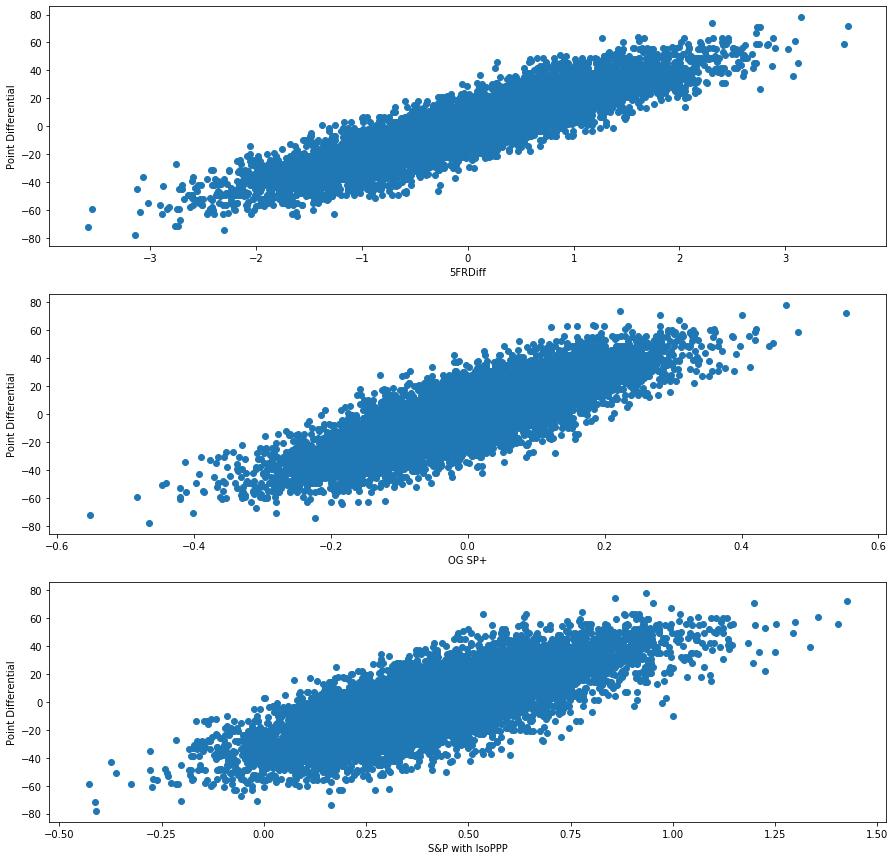

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [15]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912285,0.757657
S&PIsoPPPDiff,0.912285,1.000000,0.814933
PtsDiff,0.757657,0.814933,1.000000


In [16]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203,0.943246,1.899151
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828,0.451861,0.180871
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828,0.451861,0.180871
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657,0.581451,0.497397


In [17]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [18]:
# outliers

In [19]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.041520,0.006633,5.436102,0.872203,0.943246,1.899151
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.422320,0.042920,5.208914,0.417828,0.451861,0.180871
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.422320,-0.042920,4.791086,-0.417828,0.451861,0.180871
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0.00,0,-0.087917,6.578618,-0.261670,-0.059391,5.268829,0.537657,0.581451,0.497397
0,UMass,2012,322430041,0.0,-37.0,0.000005,0.148936,0.042553,2.382979,1.437239,...,-0.22,-1,-0.193136,-19.651101,0.428001,-0.134043,4.076416,-1.847168,1.997624,1.673061


In [20]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [21]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 21.27596x + -0.01746
Mean Pred Score: -0.0917615791648345
Pred Std Dev: 19.59861848770124
Mean Abs Error: 8.004151274632516
Mdn Abs Error: 6.379816418945521
R-squared: 0.792868313692844



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.772542,0.600980,0.483745,0.792129,0.610786,0.590114,0.963245,0.556294,0.785619,-0.468353,-0.441416,0.731433,0.748290,0.264881,0.545719,0.890512,0.890512,0.890512
OffSRDiff,0.772542,1.000000,0.510411,0.305877,0.714399,0.391667,0.415051,0.758861,0.742843,0.717681,-0.300773,-0.173210,0.647998,0.764757,-0.021603,0.550814,0.863308,0.863308,0.863308
OffERDiff,0.600980,0.510411,1.000000,0.167039,0.521778,0.327206,0.341945,0.583892,0.380735,0.824095,-0.210862,-0.149151,0.782642,0.644914,0.590514,0.217035,0.531031,0.531031,0.531031
FPDiff,0.483745,0.305877,0.167039,1.000000,0.609412,0.096518,0.087550,0.453840,0.077656,0.234182,-0.280713,-0.336512,0.229099,0.229831,0.014752,0.264376,0.582414,0.582414,0.582414
OppRateDiff,0.792129,0.714399,0.521778,0.609412,1.000000,0.218230,0.212452,0.783095,0.319927,0.675770,-0.308460,-0.284154,0.597876,0.736782,0.143838,0.505012,0.810866,0.810866,0.810866
OppEffDiff,0.610786,0.391667,0.327206,0.096518,0.218230,1.000000,0.723264,0.590832,0.509926,0.434490,-0.315049,-0.307681,0.406454,0.357562,0.195308,0.331852,0.488378,0.488378,0.488378
OppPPDDiff,0.590114,0.415051,0.341945,0.087550,0.212452,0.723264,1.000000,0.563533,0.526191,0.461493,-0.338814,-0.299326,0.440502,0.362774,0.219359,0.343367,0.537719,0.537719,0.537719
PPDDiff,0.963245,0.758861,0.583892,0.453840,0.783095,0.590832,0.563533,1.000000,0.544971,0.756438,-0.438147,-0.412057,0.705174,0.716004,0.242865,0.538005,0.863331,0.863331,0.863331
OppSRDiff,0.556294,0.742843,0.380735,0.077656,0.319927,0.509926,0.526191,0.544971,1.000000,0.537459,-0.264336,-0.138434,0.498656,0.484196,0.020908,0.394599,0.632160,0.632160,0.632160
YPPDiff,0.785619,0.717681,0.824095,0.234182,0.675770,0.434490,0.461493,0.756438,0.537459,1.000000,-0.329673,-0.224152,0.918896,0.805663,0.553452,0.445196,0.723166,0.723166,0.723166


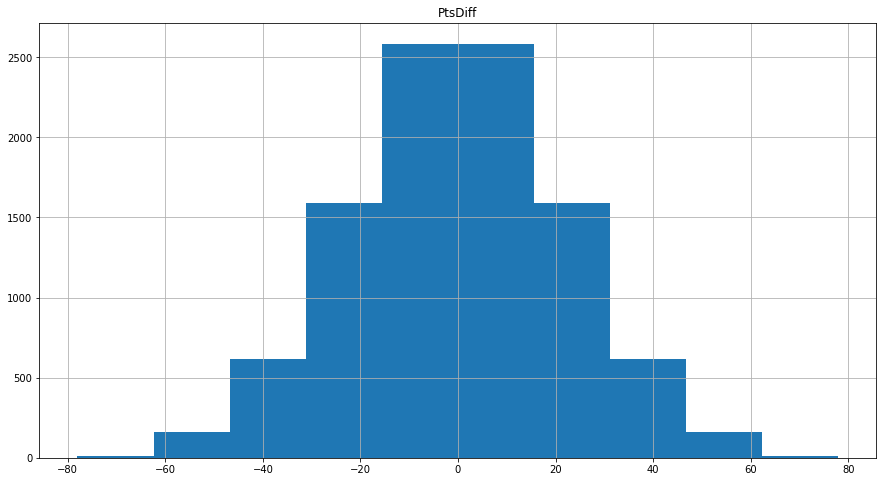

In [22]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

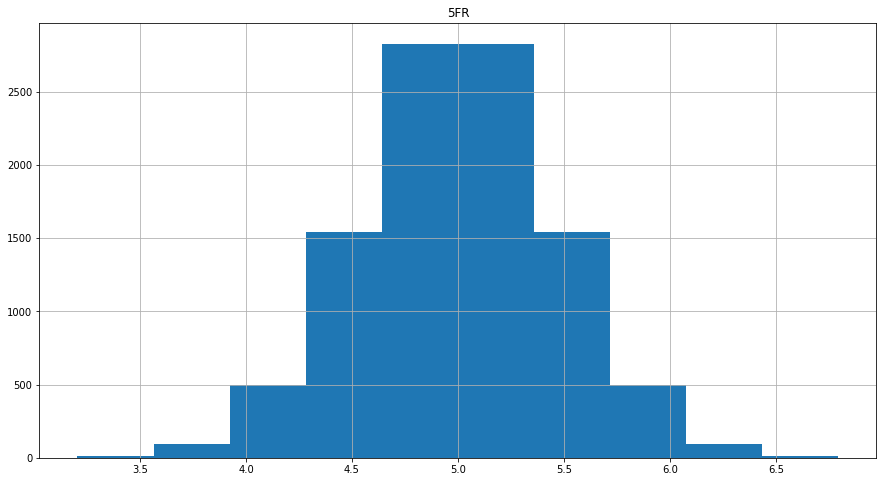

In [23]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

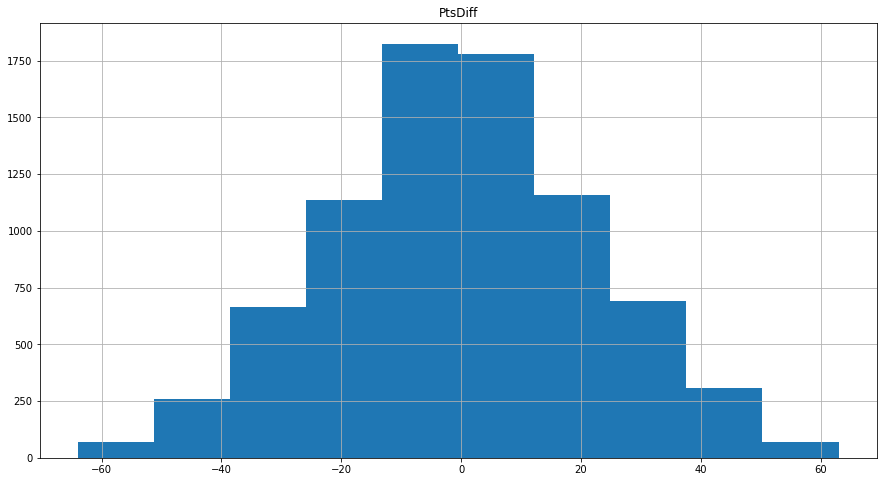

In [24]:
train_data.hist(column='PtsDiff', figsize=(15,8));

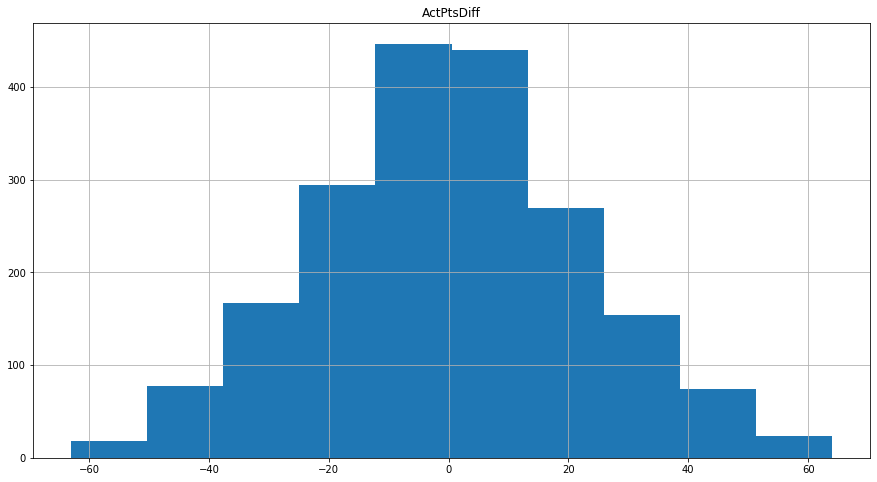

In [25]:
test.hist(column='ActPtsDiff', figsize=(15,8));

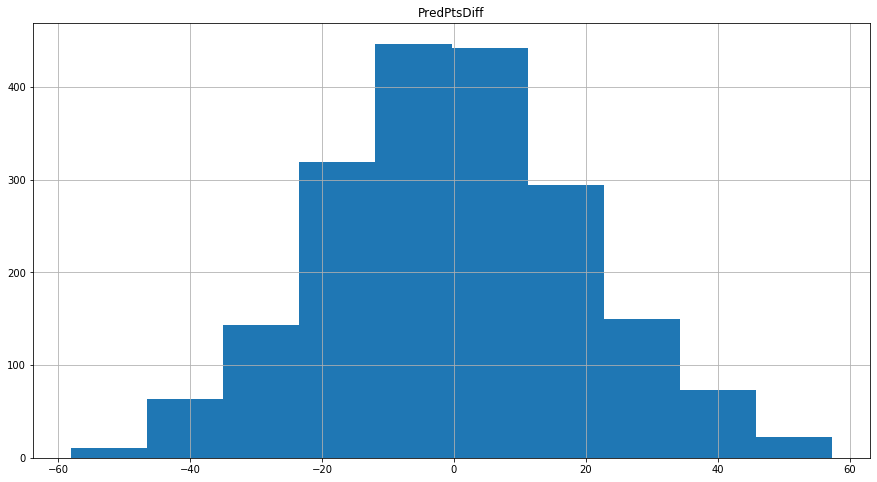

In [26]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [27]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [28]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -4.393391299396948)
Z score: -0.2194863746611285
Win Prob for Virginia Tech: 41.31%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [29]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -16.0 (exact value: -15.74254834651277)
Z score: -0.7985658161145033
Win Prob for Georgia Tech: 21.23%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [30]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -6.0 (exact value: -6.403292236502598)
Z score: -0.32203956933487177
Win Prob for Georgia Tech: 37.37%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [31]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 5.586608198478516)
Z score: 0.2897331656926078
Win Prob for Mississippi State: 61.40%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [32]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -7.96712820739342)
Z score: -0.40183274311761463
Win Prob for Texas A&M: 34.39%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [33]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.936230,13,12.0,1.0
2,Clemson,0.930644,13,12.0,1.0
3,Alabama,0.918134,12,11.0,1.0
4,LSU,0.905594,13,12.0,1.0
5,Wisconsin,0.843722,13,11.0,2.0
...,...,...,...,...,...
126,Connecticut,0.138543,12,2.0,10.0
127,Bowling Green,0.134774,12,2.0,10.0
128,UMass,0.109925,12,1.0,11.0
129,Akron,0.101791,12,1.0,11.0


In [34]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.269362,1.730638
21,Clemson,10.511794,2.488206
53,LSU,10.328741,2.671259
2,Alabama,9.314775,2.685225
128,Wisconsin,9.258320,3.741680
...,...,...,...
92,South Alabama,2.285050,9.714950
25,Connecticut,2.103872,9.896128
1,Akron,2.033452,9.966548
112,UMass,2.021947,9.978053


In [53]:
# Matchup Predictor?
def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
#     if (~(teams[teams.school == team1].conference.isin(p5).all())):
#         team1_avg_ffr *= 0.85 # arbitrary
#     if (~(teams[teams.school == team2].conference.isin(p5).all())):
#         team2_avg_ffr *= 0.85 # arbitrary
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.03926738948673684, -34.570663025699396]

In [54]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    ['UCF','Marshall',15],
    ['BYU',"Hawai'i",2],
    ['Miami','Louisiana Tech',6],
    ['Pittsburgh','Eastern Michigan',11],
    ['North Carolina','Temple',5],
    ['Michigan State','Wake Forest',3.5],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Iowa', 'USC', 2.5],
    ['Air Force', 'Washington State', 3],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Notre Dame', 'Iowa State', 4],
    ['Western Kentucky', 'Western Michigan', 3.5],
    ['Mississippi State', 'Louisville', 4],
    ['California', 'Illinois', 6.5],
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    ['Ohio', 'Nevada', 7.5],
    ['Tulane', 'Southern Mississippi', 7],
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Clemson,Ohio State,2.5,12.493812,0.739617,True,Clemson,Clemson
0,Notre Dame,Iowa State,4.0,10.691219,0.708906,True,Notre Dame,Notre Dame
0,Michigan State,Wake Forest,3.5,9.139991,0.681194,True,Michigan State,Michigan State
0,Ohio,Nevada,7.5,8.078673,0.661620,True,Ohio,Ohio
0,Navy,Kansas State,2.0,7.718601,0.654875,True,Navy,Navy
0,Air Force,Washington State,3.0,6.323049,0.628283,True,Air Force,Air Force
0,Virginia Tech,Kentucky,3.0,4.049120,0.583667,True,Virginia Tech,Virginia Tech
0,Western Kentucky,Western Michigan,3.5,3.814616,0.578993,True,Western Kentucky,Western Kentucky
0,BYU,Hawai'i,2.0,3.175597,0.566202,True,BYU,BYU
0,LSU,Oklahoma,11.0,7.993692,0.660033,False,LSU,Oklahoma


In [ ]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

In [ ]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

In [ ]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

In [ ]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

In [ ]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

In [ ]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

In [ ]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)